<a href="https://colab.research.google.com/github/omnyx2/arc-solver-2020/blob/main/Winning_Solution_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%pip install colorama

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
!git clone https://github.com/fchollet/ARC-AGI.git
!cp -r ./ARC-AGI/* ./

fatal: destination path 'ARC-AGI' already exists and is not an empty directory.


In [18]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'arc-prize-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F67357%2F8951125%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T023817Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D797a28c039d27a160de1378960db3eb7718b1fb125f3cb4c660eba6a27ff9e5e9350d830ea83ce94cae79d27bb969480df99c44bc491d87ca621c8af2665e3c33647aa995dc66e0b9e4d5435791182deead8cf8cd7fb396a516a9a8d39650efc94460ad1c02990e41f8281b8c572e36c5375a588a5373f4b6a9093539ffd3c13c0dfc54040cb2b2ec3fd02edd3bc5a6c3de5905b4aaf755a2d03b3d2eaf7f8f26b4e65ba032fbefd670208e5c17f26166b5a440a5290cf15d60039a4e913f3687c05d601f711921bfe5825d80b281c54e4e6b7d616a19783b67fdea934fa7ec39d39ee17341174ad2fa6bdbe5e9e1ee801eb0e7f31130b590ac4f34709665892,arc-solution-source-files-by-icecuber:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5156304%2F8615222%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T023817Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D145d43c8ec935dc6eeb532c14d0fa1712b9e5bec99936fb675d4d425d7342836130b1c1cd263222ad33466b2adf143417ae67154b9d00f8eacd2b820bf6f3fee8e83c07ded38b2020ec5108430226e703d5573406307e2cb59608363bd4311185c720f1c7f92b44e6761db4210fcedb82efaae91564c3375d674235e7808f323739a0cd6063f870aa2398160be2cbe38adff24c33983a85aa1237dce182b15b1a8580caff79194cc825d3c854a361fa7e2b77b4037f53f6491c4a787e7a2e805970adada1fb1796c8dae3fc7f7c4109441457ea19db66c564f6bf4ee3e4e8117873ff6ff62389e39324f4404d098122b0e779941f947668b530030b2543710db'
# DATA_SOURCE_MAPPING = 'ARC-AGI/data'
# KAGGLE_INPUT_PATH='/kaggle/input/evaluation'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


<p style="border-bottom: 5px solid red"></p>

<div style="padding: 30px; background-color: darkcyan; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <div style="border: 2px solid darkcyav; padding: 20px; text-align: center; border-radius: 10px; background-color: white;">
        <h1 style="color: #00000; font-size: 26px; text-transform: uppercase; letter-spacing: 2px; margin-bottom: 20px;">🧮Abstraction and Reasoning CORPUS🧠Prize 2024</h1>
        <div><em>
       By: Somayyeh Gholami & Mehran Kazeminia
    </em></div>
</div>
                
## <div style="color:black;background-color:white;padding:1.0%;border-radius:10px 10px;font-size:1em;text-align:center">Solver 7 | Developed 2020 Winning Solutions</div>

In [19]:
from IPython.display import HTML
import time

handle = display(HTML("""<marquee>👌</marquee>"""), display_id='html_marquee1')
time.sleep(2)
handle = display(HTML("""<marquee>🧠 Can a computer learn complex, abstract tasks from just a few examples?</marquee>"""), display_id='html_marquee1', update=True)

<p style="border-bottom: 5px solid red"></p>
<p style="border-bottom: 15px solid darkcyan"></p>

In [34]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scipy
!pip install networkx


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00-:--:--


In [29]:
import os, gc
import sys, pdb
import copy, time
import json, random

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

In [30]:
!ls ../input/*

ls: cannot access '../input/*': No such file or directory


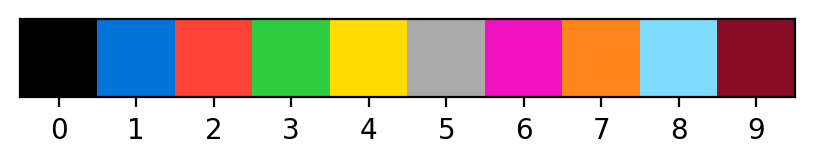

In [31]:
# train1_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
# train2_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

# eval1_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
# eval2_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

# test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
# sample_path = '../input/arc-prize-2024/sample_submission.json'

# ......................................................................................................
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# ......................................................................................................
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

![](https://cdn-images-1.medium.com/max/1000/1*LOy2VpqaYCpwOqoKUZoazg.png)

# <span style="color:darkcyan;">Auxiliary Functions</span>

<p style="border-bottom: 5px solid red"></p>
<p style="border-bottom: 15px solid darkcyan"></p>

In [32]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_data(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1

    plt.tight_layout()
    plt.show()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1

    plt.tight_layout()
    plt.show()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


![](https://cdn-images-1.medium.com/max/1000/1*7s_cV4TLZ1L31MJNj2Rk5w.png)

# <span style="color:darkred;">Solver 7 | Developed ARC 2020</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [47]:
!pip install tqdm
!pip install xgboost
!pip install scikit-image
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 11.2 MB/s eta 0:00:00a 0:00:01


In [48]:
import signal
import psutil
import itertools
import subprocess
import base64, gzip
import networkx as nx
import multiprocessing
#::::::::::::::::::::::::::::::::::::::::::::::
from numpy import array
from pathlib import Path
from scipy import ndimage
from scipy.stats import mode
from tqdm.auto import trange
from functools import partial
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from xgboost import XGBClassifier
from itertools import combinations, product
from collections import defaultdict, Counter
from skimage.measure import label, regionprops
#::::::::::::::::::::::::::::::::::::::::::::::
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from skimage.measure import label, regionprops
from sklearn.preprocessing import MinMaxScaler
#::::::::::::::::::::::::::::::::::::::::::::::
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#::::::::::::::::::::::::::::::::::::::::::::::

<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*WWWVPaYg_eKA-8g8MKrOjw.png'>
</div>

# <span style="color:darkred;">1 - Different Solvers</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [49]:
################################################################################
# 40 Functions - Via Different Solvers
################################################################################ 1
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

################################################################################ 2
def get_objects(task):
    xs, ys = [], []
    for obj in task['train']:
        xs.append(np.array(obj['input']))
        ys.append(np.array(obj['output']))
    return xs, ys

################################################################################ 3
def find_sub(matrix, sub, ignore=None):
    positions = []
    mask = sub != ignore
    sub_ = sub[mask]
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.array_equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]][mask], sub_):
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

################################################################################ 4
def check_subitem(task):
    for x, y in zip(*get_objects(task)):
        positions = find_sub(x, y)
        if len(positions) == 0:
            return False
    return True

################################################################################ 5
def check_samesize(task):
    for x,y in zip(*get_objects(task)):
        if x.shape != y.shape:
            return False
    return True

################################################################################ 6
def check_sub_mask(task):
    if check_samesize(task):
        return False
    for x,y in zip(*get_objects(task)):
        colors, counts = np.unique(x, return_counts=True)
        found = 0
        for c, area in zip(colors, counts):
            cxs, cys = np.where(x == c)
            xmin,ymin,xmax,ymax = min(cxs),min(cys),max(cxs)+1,max(cys)+1
            shape = (xmax-xmin, ymax-ymin)
            if shape == y.shape and area == np.prod(y.shape):
                found += 1
        if found != 1:
            return False
    return True

################################################################################ 7
def get_cells(x, cols, rows):
    if cols[0] != 0:
        cols = [-1]+cols
    if rows[0] != 0:
        rows = [-1]+rows
    if cols[-1] != x.shape[0]-1:
        cols.append(x.shape[0])
    if rows[-1] != x.shape[1]-1:
        rows.append(x.shape[1])
    cells = np.full((len(cols)-1, len(rows)-1), object)
    for i in range(len(cols)-1):
        for j in range(len(rows)-1):
            cells[i][j] = x[cols[i]+1:cols[i+1], rows[j]+1:rows[j+1]]
    return cells

################################################################################ 8
def get_grid(x):
    cols = defaultdict(list)
    rows = defaultdict(list)
    if x.shape[0] < 3 or x.shape[1] < 3:
        return -1, [], []
    for i in range(x.shape[0]):
        if len(np.unique(x[i])) == 1:
            cols[x[i,0]].append(i)
    for i in range(x.shape[1]):
        if len(np.unique(x[:,i])) == 1:
            rows[x[0,i]].append(i)
    for c in cols:
        if c in rows and all(np.diff(cols[c])>1) and all(np.diff(rows[c])>1):
            return c, cols[c], rows[c]
    return -1, [], []

################################################################################ 9
def check_grid(task):
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
    return True

################################################################################ 10
def mul_ratio(x, x_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    return x_

################################################################################ 11
def predict_transforms(xs, ys, test):
    fn = get_transform(xs, ys)
    if fn:
        return [fn(test)]
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            test = mul_ratio(test, x_ratio)
            return [fn(test)]
        fns = np.full(x_ratio, object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return []
        return [np.concatenate([np.concatenate([fns[i,j](test) for i in range(x_ratio[0])], axis=0) for j in range(x_ratio[1])], axis=1)]
    return []

################################################################################ 12
def predict_grid_transforms(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms(xs, ys, grid_filter(test))

################################################################################ 13
def get_transform(xs, ys):
    for tranform in get_all_transforms():
        tranformed = True
        for x, y in zip(xs, ys):
            if tranform(x).shape != y.shape:
                tranformed = False
                break
            if not np.equal(tranform(x), y).all():
                tranformed = False
        if tranformed:
            return tranform
    return None

################################################################################ 14
def get_transforms(xs, ys):
    fn = get_transform(xs, ys)
    if fn:
        return fn
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            return fn
        fns = np.full(x_ratio, object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return None
        return fns
    return None

################################################################################ 15
def check_grid_transforms(task):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return get_transforms(xs, ys) is not None

################################################################################ 16
def get_mode_color(ar):
    colors, counts = np.unique(ar, return_counts=True)
    return colors[np.argmax(counts)]

################################################################################ 17
def grid_filter(x):
    color_of_grid, cols, rows = get_grid(x)
    if color_of_grid == -1:
        return x
    cells = get_cells(x, cols, rows)
    return np.array([get_mode_color(cell) for cell in cells.reshape(-1)]).reshape(cells.shape)

################################################################################ 18
def mul_ratios(x, y, x_ratio, y_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    y_shape = (y.shape[0]*y_ratio[0], y.shape[1]*y_ratio[1])
    y_ = np.array([y[i//y_ratio[0]][j//y_ratio[1]] for i, j in np.ndindex(y_shape)]).reshape(y_shape)
    return x_, y_

################################################################################ 19
def get_ratio(xs, ys):
    x_ratio = []
    y_ratio = []
    for i in range(2):
        if   all(x.shape[i]%y.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(x.shape[i]//y.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(1)
                y_ratio.append(xs[0].shape[i]//ys[0].shape[i])
        elif all(y.shape[i]%x.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(y.shape[i]//x.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(ys[0].shape[i]//xs[0].shape[i])
                y_ratio.append(1)
    if len(x_ratio) != 2:
        return None
    return tuple(x_ratio), tuple(y_ratio)

################################################################################ 20
def check_sub_grid_2x(task):
    if check_samesize(task) or check_subitem(task):
        return False
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
        cells = grid_filter(x)
        if (cells.shape[0]*2 != y.shape[0] or cells.shape[1]*2 != y.shape[1]):
            return False
    return True

################################################################################ 21
def check_chess(task, input=False, output=True):
    xs, ys = get_objects(task)
    if input:
        for x in xs:
            if not has_chess(x) and not has_antichess(x):
                return False
    if output:
        for y in ys:
            if not has_chess(y) and not has_antichess(y):
                return False
    return True

################################################################################ 22
def has_chess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(x+y)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

################################################################################ 23
def has_antichess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(g.shape[0]-x+y-1)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

################################################################################ 24
def find_colors(g):
    colors = np.unique(g)
    counts = len(colors)
    for cnt in range(counts, 1, -1):
        q_colors = np.full(cnt, -1, int)
        for c in colors:
            pts = np.where(g == c)
            s = set([(x+y)%cnt for x, y in zip(*pts)])
            if len(s) > 1:
                continue
            index = s.pop()
            q_colors[index] = c

        if -1 not in q_colors:
            return q_colors
    return None

################################################################################ 25
def predict_chess(g):
    q_colors = find_colors(g)
    if q_colors is None:
        colors, counts = np.unique(g, return_counts=True)
        q_colors = colors[np.argsort(counts)][:2]

    results = []
    counts = len(q_colors)
    for i in range(counts):
        result = g.copy()
        for x, y in np.ndindex(g.shape):
            result[x,y] = q_colors[(x+y)%counts]
        results.append(result)
        q_colors = np.roll(q_colors, 1)
    return results

################################################################################ 26
def predict_transforms_grid_2x(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms_2x(xs, ys, grid_filter(test))

################################################################################ 27
def predict_transforms_2x(xs, ys, test):
    predictions = []
    transforms = [
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x, k=2),
        lambda x: x,
    ]
    quads = [(1,3,2,0),(3,1,0,2),(2,0,1,3)] # 3 full symmetrical shapes
    for f1,f2,f3,f4 in quads:
        fns = np.array([[transforms[f1],transforms[f2]],[transforms[f3],transforms[f4]]])
        x_ = np.concatenate([np.concatenate([fns[i,j](test) for i in range(2)], axis=0) for j in range(2)], axis=1)
        predictions.append(x_)
    return predictions

################################################################################ 28
def has_repeating(g, ignore=0):
    size0b = int(.6 * g.shape[0])
    size1b = int(.6 * g.shape[1])
    t = np.full((g.shape[0]+2*size0b,g.shape[1]+2*size1b), -1)
    t[size0b:-size0b,size1b:-size1b] = g
    t[t==ignore] = -1
    for size0 in range(2, size0b+1):
        for size1 in range(2, size1b+1):
            for shift0 in range(size0):
                for shift1 in range(size1):
                    pattern = t[size0b+shift0:size0b+shift0+size0,size1b+shift1:size1b+shift1+size1].copy()
                    found = True
                    for d0 in range(size0b+shift0-size0, t.shape[0]-size0, size0):
                        for d1 in range(size1b+shift1-size1, t.shape[1]-size1, size1):
                            test = t[d0:d0+size0,d1:d1+size1]
                            mask = (test != -1) & (pattern != -1)
                            if np.array_equal(test[mask], pattern[mask]):
                                ind = test != -1
                                pattern[ind] = test[ind]
                            else:
                                found = False
                                break
                    if found:
                        return shift0, shift1, pattern
    return None

################################################################################ 29
def check_repeating(task, has_complete=False):
    patterns = []
    for x, y in zip(*get_objects(task)):
        if len(np.unique(x)) < 3 or not has_repeating(y,-1):
            return False
        result = None
        for c in np.unique(x):
            # if c not in np.unique(y):
            result = has_repeating(x,c)
            if result:
                sh0,sh1,pattern = result
                pattern[pattern == -1] = c
                if has_complete:
                    pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
                    pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
                    pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
                    pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
                    if np.array_equal(pred1, y) or np.array_equal(pred2, y) or np.array_equal(pred3, y):
                        break
                    result = None
                else:
                    break
        if not result:
            return False
    return True

################################################################################ 30
def predict_repeating(x):
    for c in np.unique(x):
        result = has_repeating(x, c)
        if result:
            sh0,sh1,pattern = result
            pattern[pattern == -1] = c
            pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
            pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
            pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
            pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
            return [pred1,pred2,pred3]
    return []

################################################################################ 31
def predict_repeating_mask(x):
    predictions = predict_repeating(x)
    if len(predictions) > 0:
        rows, cols = np.where(predictions[0] != x)
        return [predictions[0][min(rows):max(rows)+1,min(cols):max(cols)+1]]
    return []

################################################################################ 32
def trim_matrix(x):
    if len(np.unique(x)) == 1:
        return x
    for c in np.unique(x):
        xs,ys = np.where(x!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < x.shape[0] or ymax < x.shape[1]:
            return x[xmin:xmax,ymin:ymax]
    return x

################################################################################ 33
def trim_matrix_box(g, mask=None):
    if mask is None:
        mask = np.unique(g)
    if len(np.unique(g)) == 1:
        return None
    for c in mask:
        xs,ys = np.where(g!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < g.shape[0] or ymax < g.shape[1]:
            return (xmin,ymin,xmax,ymax)
    return None

################################################################################ 34
def has_tiles(g, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        for size0 in range(min_size0, size0b+1):
            for size1 in range(min_size1, size1b+1):
                pattern = t[:size0,:size1].copy()
                found = True
                for d0 in range(0, t.shape[0]-size0, size0):
                    for d1 in range(0, t.shape[1]-size1, size1):
                        test = t[d0:d0+size0,d1:d1+size1]
                        mask = (test != -1) & (pattern != -1)
                        if np.array_equal(test[mask], pattern[mask]):
                            ind = test != -1
                            pattern[ind] = test[ind]
                        else:
                            found = False
                            break
                if found:
                    return pattern
    return None

################################################################################ 35
def roll_color(g):
    from_values = np.unique(g)
    to_values = np.roll(from_values, 1)

    sort_idx = np.argsort(from_values)
    idx = np.searchsorted(from_values, g, sorter = sort_idx)
    return to_values[sort_idx][idx]

################################################################################ 36
def get_all_transforms():
    return [
        lambda x: roll_color(x),
        lambda x: np.roll(x, -1, axis=0),
        lambda x: np.roll(x,  1, axis=0),
        lambda x: np.roll(x, -1, axis=1),
        lambda x: np.roll(x,  1, axis=1),
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=2),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x.T, k=4),
        lambda x: np.rot90(x, k=1),
        lambda x: np.rot90(x, k=2),
        lambda x: np.rot90(x, k=3),
        lambda x: x,
    ]

################################################################################ 37
def has_tiles_shape(g, shape, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        size0 = shape[0]
        size1 = shape[1]
        pattern = t[:size0,:size1].copy()
        found = True
        for d0 in range(0, t.shape[0]-size0, size0):
            for d1 in range(0, t.shape[1]-size1, size1):
                test = t[d0:d0+size0,d1:d1+size1]
                mask = (test != -1) & (pattern != -1)
                if np.array_equal(test[mask], pattern[mask]):
                    ind = test != -1
                    pattern[ind] = test[ind]
                else:
                    found = False
                    break
        if found:
            return pattern
    return None

################################################################################ 38
def check_tiles_shape(task, has_complete=0):
    patterns = []
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return False
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                if has_complete:
                    for transform in get_all_transforms():
                        transformed_pattern = transform(pattern)
                        pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                        pred = pred[:x.shape[0],:x.shape[1]]
                        if np.array_equal(pred, y):
                            found = True
                            patterns.append(pattern)
                            break
                else:
                    found = True
                    patterns.append(pattern)
        if not found:
            return False
    return True

################################################################################ 39
def predict_tiles_shape(task, test_input):
    has_transforms = set()
    has_shapes = set()
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return []
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                for transform in get_all_transforms():
                    transformed_pattern = transform(pattern)
                    pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                    pred = pred[:x.shape[0],:x.shape[1]]
                    if np.array_equal(pred, y):
                        found = True
                        has_transforms.add(transform)
                        has_shapes.add(o_pattern.shape)
                        break
        if not found:
            return []

    preds = []
    for c in np.unique(test_input):
        for shape in has_shapes:
            pattern = has_tiles_shape(test_input, shape, c)
            if pattern is None:
                continue
            pattern[pattern == -1] = c

            pred = np.tile(pattern, (test_input.shape[0]//pattern.shape[0]+2, test_input.shape[1]//pattern.shape[1]+2))
            for transform in has_transforms:
                transformed_pattern = transform(pattern)
                pred = np.tile(transformed_pattern, (test_input.shape[0]//transformed_pattern.shape[0]+2, test_input.shape[1]//transformed_pattern.shape[1]+2))
                pred = pred[:test_input.shape[0],:test_input.shape[1]]
                preds.append(pred)
    return preds

################################################################################ 40



<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*UurBdaImPTYbKVk2POYpJQ.png'>
</div>

# <span style="color:darkred;">2 - Sklearn tree</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [50]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <array>
#include <algorithm>
#include <vector>
#include <random>
#include <sstream>
#include <cassert>

using namespace std;
typedef float feature_type;
typedef vector<vector<int>> grid;
struct box {
    int xmin = 999, ymin = 999, xmax = -999, ymax = -999;
    double width()  const {return xmin != 999 && xmax != -999 ? xmax - xmin : 0.0;}
    double height() const {return ymin != 999 && ymax != -999 ? ymax - ymin : 0.0;}
    double area() const {return width()*height();}
    double perimeter() const {return 2*(width()+height());}
    static box grid(const grid& g) {return box{0, 0, int(g.size()), int(g[0].size())};}
    box reshape(int t) const {return box{xmin-t, ymin-t, xmax+t, ymax+t};}
    bool has_box(box b) const {
        return area() > 0 && b.area() > 0 && xmin <= b.xmin && xmax >= b.xmax && ymin <= b.ymin && ymax >= b.ymax;
    }
    bool has_intersection(box b) const {
        return area() > 0 && b.area() > 0 && ymin < b.ymax && ymax > b.ymin && xmin < b.xmax && xmax > b.xmin;
    }
    double iou(box b) const {
        double xmaxmin = max(xmin, b.xmin);
        double ymaxmin = max(ymin, b.ymin);
        double xminmax = min(xmax, b.xmax);
        double yminmax = min(ymax, b.ymax);

        bool has_inter = has_intersection(b);
        double inter_area = has_inter ? (xminmax - xmaxmin) * (yminmax - ymaxmin) : 0.0;
        double whole_area = area() + b.area() - inter_area;
        return inter_area / whole_area;
    }
};
vector<string> split(istream& ss, char sep = ' ') {
    vector<string> output;
    string line;
    for (;getline(ss, line, sep);) {
        output.emplace_back(line);
    }
    return output;
}
vector<string> split(string input, char sep = ' ') {
    istringstream ss(input);
    return split(ss, sep);
}
array<int, 10> count(const grid& g, box b) {
    array<int, 10> result;
    result.fill(0);
    for (auto x = b.xmin; x < b.xmax; ++x)
        for (auto y = b.ymin; y < b.ymax; ++y)
            ++result[g[x][y]];
    return result;
}
array<int, 10> count(const grid& g) {
    return count(g, box::grid(g));
}
bool has_vertical_symmetry(const grid& g, box b) {
    for (int x = b.xmin; x<b.xmax; ++x)
        for (int dy = 0; dy < (b.ymax-b.ymin)/2; ++dy) {
            if (g[x][b.ymin+dy] != g[x][b.ymax-dy-1])
                return false;
        }
    return true;
}
bool has_horizontal_symmetry(const grid& g, box b) {
    for (int y = b.ymin; y < b.ymax; ++y)
        for (int dx = 0; dx < (b.xmax-b.xmin)/2; ++dx) {
            if (g[b.xmin+dx][y] != g[b.xmax-dx-1][y])
                return false;
        }
    return true;
}
bool has_frame(const grid& g, box b, bool unique_frame = false) {
    vector<int> cs;
    int mx = int(g.size()), my = int(g[0].size());
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmin][y]);
    if (b.xmax == xmax_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmax-1][y]);
    if (b.ymin == ymin_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymin]);
    if (b.ymax == ymax_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymax-1]);
    for (int i = 1; i < cs.size(); ++i)
        if (cs[i] != cs[i-1])
            return false;
    if (unique_frame && !cs.empty())
        for (int x = max(0, b.xmin+1); x < min(b.xmax-1, mx); ++x)
            for (int y = max(0, b.ymin+1); y < min(b.ymax-1, my); ++y)
                if (g[x][y] == cs[0])
                    return false;
    return true;
}
int cnt_strime(const grid& g, box b) {
    int n = 0;
    int mx = int(g.size()), my = int(g[0].size());
    if (b.xmin >= b.xmax || b.ymin >= b.ymax)
        return n;
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmin][y-1] != g[b.xmin][y]) {
                --n;
                break;
            }
    }
    if (b.xmax == xmax_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmax-1][y-1] != g[b.xmax-1][y]) {
                --n;
                break;
            }
    }
    if (b.ymin == ymin_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymin] != g[x][b.ymin]) {
                --n;
                break;
            }
    }
    if (b.ymax == ymax_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymax-1] != g[x][b.ymax-1]) {
                --n;
                break;
            }
    }
    return n;
}
bool is_same_box(const grid& g, box l, box r) {
    for (int dx = 0; dx < l.width(); ++dx)
        for (int dy = 0; dy < l.height(); ++dy)
            if (g[l.xmin+dx][l.ymin+dy] != g[r.xmin+dx][r.ymin+dy])
                return false;
    return true;
}
int cnt_same_boxes(const grid& g, box b) {
    int n = 0;
    int width = b.width();
    int height = b.height();
    for (int x = 0; x < g.size() - width; ++x)
        for (int y = 0; y < g[0].size() - height; ++y) {
            if (is_same_box(g, b, {x, y, width, height}))
                ++n;
        }
    return n;
}
array<box, 10> get_boxes_of_colors(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            int c = g[x][y];
            boxes[c].xmin = min(boxes[c].xmin, x);
            boxes[c].ymin = min(boxes[c].ymin, y);
            boxes[c].xmax = max(boxes[c].xmax, x+1);
            boxes[c].ymax = max(boxes[c].ymax, y+1);
        }
    return boxes;
}
array<box, 10> get_boxes_of_colors_inverse(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            for (int c = 0; c < 10; ++c) if (c != g[x][y]) {
                boxes[c].xmin = min(boxes[c].xmin, x);
                boxes[c].ymin = min(boxes[c].ymin, y);
                boxes[c].xmax = max(boxes[c].xmax, x+1);
                boxes[c].ymax = max(boxes[c].ymax, y+1);
            }
        }
    return boxes;
}
void boxes_features(vector<feature_type>& row, box l, box r) {
//    row.emplace_back(l.area()/r.area());
//    row.emplace_back(l.iou(r));
    row.emplace_back(l.iou(r) > 0.99);
}
vector<int> get_colors(const grid& g, const array<box, 10>& boxes_of_colors, box bx) {
    vector<int> colors;
    auto cnt_colors = count(g, bx);
    auto all_colors = count(g);
    int used_color = -1;
    int used_color2 = -1;
    for (int  c = 9; c >= 0; --c) {
        if (used_color != -1 && cnt_colors[c] > 0) {
            used_color2 = c;
            break;
        }
        if (used_color == -1 && cnt_colors[c] > 0) {
            used_color = c;
        }
    }
    int gr_percent = used_color;
    int gr_area_not_black = used_color;
    int gr_area = used_color;
    int ls_area = used_color;
    int gr_iou = used_color;
    for (int c = 0; c < 10; ++c) {
//        colors.emplace_back(c);
        if (cnt_colors[gr_percent] / float(all_colors[gr_percent]) < cnt_colors[c] / float(all_colors[c]))
            gr_percent = c;
        if (boxes_of_colors[gr_area].area() < boxes_of_colors[c].area())
            gr_area = c;
        if (c != 0 && boxes_of_colors[gr_area_not_black].area() < boxes_of_colors[c].area())
            gr_area_not_black = c;
        if (boxes_of_colors[c].area() > 0 && boxes_of_colors[ls_area].area() > boxes_of_colors[c].area())
            ls_area = c;
        if (boxes_of_colors[gr_iou].iou(bx) < boxes_of_colors[c].iou(bx))
            gr_iou = c;
    }
    int gr_area2 = gr_area == used_color ? used_color2 : used_color;
    for (int c = 0; c < 10; ++c) {
        if (c != gr_area && boxes_of_colors[gr_area2].area() < boxes_of_colors[c].area())
            gr_area2 = c;
    }
    colors.emplace_back(gr_percent);        // 0
    colors.emplace_back(gr_area_not_black); // 1
    colors.emplace_back(gr_area);           // 2
    colors.emplace_back(gr_area2);          // 3
    colors.emplace_back(ls_area);           // 4
    colors.emplace_back(gr_iou);            // 5

    return colors;
}
vector<feature_type> make_feature(const grid& g, const array<box, 10>& boxes_of_colors, const box bx) {
    vector<feature_type> row;
    row.emplace_back(bx.xmin);
    row.emplace_back(bx.ymin);
    row.emplace_back(bx.xmax);
    row.emplace_back(bx.ymax);

    auto ibx = box::grid(g);

    int has_boxes = 0;
    int in_boxes = 0;
    auto boxes_of_colors_inverse = get_boxes_of_colors_inverse(g);
    for (auto c : get_colors(g, boxes_of_colors, bx)) {
        boxes_features(row, bx, boxes_of_colors[c]);
        boxes_features(row, bx, boxes_of_colors_inverse[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors_inverse[c]);
    }
    auto cnt_colors = count(g, bx);
    int ucnt_colors = 0;
    for (int c = 0; c < 10; ++c) {
        ucnt_colors += cnt_colors[c] > 0;
        has_boxes += bx.has_box(boxes_of_colors[c]);
        in_boxes += boxes_of_colors[c].has_box(bx);
    }

    boxes_features(row, bx, ibx);
    bool has_frame_ = has_frame(g, bx);
    bool has_frame_1 = has_frame(g, bx.reshape(1));
//    bool has_frame_m1 = has_frame(g, bx.reshape(-1));
    int cnt_trime_ = cnt_strime(g, bx);
    row.emplace_back(cnt_same_boxes(g, bx));
    row.emplace_back(has_frame_ ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(cnt_trime_ == 0 ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(has_vertical_symmetry(g, bx));
    row.emplace_back(has_horizontal_symmetry(g, bx));

    row.emplace_back(ucnt_colors);
    row.emplace_back(has_boxes);
    row.emplace_back(in_boxes);
    row.emplace_back(has_frame(g, bx, true));
    row.emplace_back(has_frame(g, bx.reshape(1), true));
    row.emplace_back(has_frame_);
    row.emplace_back(has_frame_1);
//    row.emplace_back(has_frame_m1);
    row.emplace_back(has_frame_1 || has_frame_);
    row.emplace_back(has_frame_1 && has_frame_);
    row.emplace_back(has_frame_1 == has_frame_);
    row.emplace_back(bx.width());
    row.emplace_back(bx.height());
    row.emplace_back(bx.area());
    row.emplace_back(cnt_trime_);
    row.emplace_back(cnt_strime(g, bx.reshape(1)));
    row.emplace_back(cnt_strime(g, bx.reshape(-1)));

//    row.emplace_back(perimeter);
    return row;
}
string get_columns() {
    stringstream ss;
    ss << "xmin" << "\t";
    ss << "ymin" << "\t";
    ss << "xmax" << "\t";
    ss << "ymax" << "\t";
    for (int i = 0; i < 7; ++i) {
        for (int j = 0; j < 1 + 3*(i < 6); ++j) {
//            ss << "[" << i << j << "] div_areas" << "\t";
//            ss << "[" << i << j << "] iou" << "\t";
            ss << "[" << i << j << "] iou_1" << "\t";
        }
    }
    ss << "cnt_same_boxes" << "\t";
    ss << "cnt_same_boxes_w_fr" << "\t";
    ss << "cnt_same_boxes_wo_tr" << "\t";
    ss << "has_vertical_symmetry" << "\t";
    ss << "has_horizontal_symmetry" << "\t";

    ss << "ucnt_colors" << "\t";

    ss << "has_boxes" << "\t";
    ss << "in_boxes" << "\t";
    ss << "has_uframe" << "\t";
    ss << "has_uframe_1" << "\t";
    ss << "has_frame" << "\t";
    ss << "has_frame_1" << "\t";
//    ss << "has_frame_1m" << "\t";
    ss << "has_frame_or" << "\t";
    ss << "has_frame_and" << "\t";
    ss << "has_frame_eq" << "\t";
    ss << "width" << "\t";
    ss << "height" << "\t";
    ss << "area" << "\t";
    ss << "cnt_strim" << "\t";
    ss << "cnt_strim_1" << "\t";
    ss << "cnt_strim_m1";
//    ss << "perimeter";
    return ss.str();
}
void make_features(const grid& g, ostream& out) {
    auto boxes_of_colors = get_boxes_of_colors(g);
    int n = 0;
    box l = box::grid(g);
    for (int xmin = 0; xmin < g.size(); ++xmin)
        for (int ymin = 0; ymin < g[0].size(); ++ymin)
            for (int xmax = xmin+1; xmax < g.size()+1; ++xmax)
                for (int ymax = ymin+1; ymax < g[0].size()+1; ++ymax) {
                    box r = {xmin, ymin, xmax, ymax};
                    if (r.area() == l.area()) // || r.area() == 1) || (!has_frame(g, r) && !has_frame(g, r.reshape(1)))
                        continue;
                    auto row = make_feature(g, boxes_of_colors, r);
                    out.write((char*)&row[0], row.size() * sizeof(row[0]));
                    n += 1;
                }
    cout << "rows: " << n << endl;
}
inline bool exists(const std::string& name) {
    ifstream f(name.c_str());
    return f.good();
}
int main() {
    string dir = "jupyter/arc/";
    if (!exists(dir+"ex.txt"))
        dir = "./";
    vector<grid> inputs;
    ifstream fin(dir + "ex.txt");
    ofstream fout(dir + "features.bin", ios::out | ios::binary);
    ofstream fcolumns(dir + "features.tsv");
    fcolumns << get_columns();
    for (auto input: split(fin, ' ')) {
        vector<vector<int>> g;
        for (auto line : split(input, '|')) {
            vector<int> row;
            for (char& c : line)
                row.emplace_back(c-'0');
            g.emplace_back(row);
        }
        inputs.emplace_back(g);
    }
    cout << "inputs: " << inputs.size() << endl;
    auto features = make_feature({{1}}, get_boxes_of_colors({{1}}),{0, 0, 1, 1});
    cout << "features: " << features.size() << endl;
    cout << "columns: " << split(get_columns(), '\t').size() << endl;
    assert(features.size() == split(get_columns(), '\t').size());
    for (auto input : inputs) {
        cout << "shape: " << input.size() << "x" << input[0].size() << endl;
        make_features(input, fout);
    }
    return 0;
}

Writing main.cpp


In [51]:
!g++ -pthread -lpthread -O3 -std=c++17 -o main main.cpp
!./main

inputs: 0
features: 50
columns: 50


In [52]:
################################################################################
# 8 Functions - Via Tree
################################################################################ 1
def plot_objects(objects, titles=None):
    if titles is None:
        titles = np.full(len(objects), '')
    cmap = matplotlib.colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(objects), figsize=(30,3), gridspec_kw = {'wspace':0.02, 'hspace':0.02}, squeeze=False)

    for i, (obj, title) in enumerate(zip(objects, titles)):
        obj = np.array(obj)
        axs[0,i].grid(True,which='both',color='lightgrey', linewidth=0.5)
#         axs[i].axis('off')
        shape = ' '.join(map(str, obj.shape))
        axs[0,i].set_title(f"{title} {shape}")
        axs[0,i].set_yticks([x-0.5 for x in range(1+len(obj))])
        axs[0,i].set_xticks([x-0.5 for x in range(1+len(obj[0]))])
        axs[0,i].set_yticklabels([])
        axs[0,i].set_xticklabels([])
        axs[0,i].imshow(obj, cmap=cmap, norm=norm)
    plt.show()

################################################################################ 2
def find_sub(matrix, sub):
    positions = []
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]], sub).all():
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

################################################################################ 3
def check_subitem(task):
    for key in ['train', 'test']:
        for obj in task[key]:
            if 'output' in obj:
                x = np.array(obj['input'])
                y = np.array(obj['output'])
                if len(find_sub(x, y)) == 0:
                    return False
    return True

################################################################################ 4
def get_objects(task, has_train=True, has_test=False):
    xs, ys = [], []
    names = []
    if has_train:
        names.append('train')
    if has_test:
        names.append('test')
    for key in names:
        for obj in task[key]:
            xs.append(np.array(obj['input']))
            if 'output' not in obj:
                continue
            ys.append(np.array(obj['output']))
    return xs, ys

################################################################################ 5
def make_features(x, has_frame=False):
    def short_flattener(pred):
        str_pred = str([row for row in pred])
        str_pred = str_pred.replace(', ', '')
        str_pred = str_pred.replace('[[', '')
        str_pred = str_pred.replace('][', '|')
        str_pred = str_pred.replace(']]', '')
        return str_pred
    with open("ex.txt", "w") as f:
        f.write(short_flattener(x.tolist()))
    !./main > /dev/null
    columns = pd.read_csv('features.tsv', sep='\t').columns
    columns = ["".join (c if c.isalnum() else "_" for c in str(col)) for col in columns]
    df = pd.DataFrame(np.fromfile('features.bin', dtype = [(col, '<f4') for col in columns]))

    df['rps4'] = False
    df['rps8'] = False
    labels = label(x, background=-1, connectivity=2)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps8'] = True
    labels = label(x, background=-1, connectivity=1)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps4'] = True

    if has_frame:
        df = df[(df['has_frame']==1)|(df['has_frame_1']==1)]
    for col in ['cnt_same_boxes', 'cnt_same_boxes_w_fr', 'cnt_same_boxes_wo_tr', 'ucnt_colors']:
        df[f"{col}_rank"]  = df[col].rank(method="dense")
        df[f"{col}_rank_"] = df[col].rank(method="dense", ascending=False)
    for col in df.columns:
        if 'iou' in col or col in ['has_frame', 'has_frame_1']:
            df[f"{col}_rank"]  = df.groupby([col])['area'].rank(method="dense")
            df[f"{col}_rank_"] = df.groupby([col])['area'].rank(method="dense", ascending=False)
    return df

################################################################################ 6
def decision_tree(train, test, test_input):
    y = train.pop('label')
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=4372).fit(train.drop(['xmin','ymin','xmax','ymax'], axis=1), y)
    preds = model.predict_proba(test.drop(['xmin','ymin','xmax','ymax'], axis=1))[:,1]

    indexes = np.argsort(preds)[::-1]
    objects,objs,titles = [],[],[]
    for score, (xmin,ymin,xmax,ymax) in zip(preds[indexes], test[['xmin','ymin','xmax','ymax']].astype(int).values[indexes]):
        obj = test_input[xmin:xmax,ymin:ymax]
        str_obj = flattener(obj.tolist())
        if str_obj not in objects:
            objects.append(str_obj)
            objs.append(obj)
            titles.append(str(np.round(score, 4)))
        if len(objects) > 10:
            break
    plot_objects(objs, titles)
    return objects

################################################################################ 7
def tree1(train, test, test_input):
    y = train.pop('label')
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=4372).fit(train.drop(['xmin','ymin','xmax','ymax'], axis=1), y)
    preds = model.predict_proba(test.drop(['xmin','ymin','xmax','ymax'], axis=1))[:,1]

    indexes = np.argsort(preds)[::-1]
    objects,objs,titles = [],[],[]
    for score, (xmin,ymin,xmax,ymax) in zip(preds[indexes], test[['xmin','ymin','xmax','ymax']].astype(int).values[indexes]):
        obj = test_input[xmin:xmax,ymin:ymax]
        str_obj = flattener(obj.tolist())
        if str_obj not in objects:
            objects.append(str_obj)
            objs.append(obj)
            titles.append(str(np.round(score, 4)))
        if len(objects) > 1:
            break
    #plot_objects(objs, titles)
    return objs

################################################################################ 8
def format_features(task):
    train = []
    for ttid, obj in enumerate(task['train']):
        x = np.array(obj['input'])
        y = np.array(obj['output'])
        df = make_features(x)
        df['label'] = False
#         df['tid'] = ttid
        positions = find_sub(x, y)
        for xmin,ymin,xmax,ymax in positions:
            df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'label'] = True
        train.append(df)
    train = pd.concat(train).reset_index(drop=True)
    return train


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*x8hLqHg5rgGJv1kZHpIGjg.png'>
</div>

# <span style="color:darkred;">3 - Symmetry Repairing</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [53]:
################################################################################
# 31 Functions - Via Symmetry Repairing
################################################################################ 1
def Translation(x):
    n = len(x)
    k = len(x[0])
    Best_r = n
    Best_s = k
    x0 = np.array(x, dtype = int)
    for r in range(1,n):
        if x0[:n-r,:].tolist() == x0[r:,:].tolist():
            Best_r = r
            break
    for s in range(1,k):
        if x0[:,:k-s].tolist() == x0[:,s:].tolist():
            Best_s = s
            break
    if (Best_r, Best_s) == (n,k):
        return []
    r = Best_r
    s = Best_s
    E = {}
    for i in range(n):
        for j in range(k):
            u = i%r
            v = j%s
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 2
def Translation1D(x):
    n = len(x)
    k = len(x[0])

    PossibleS = []

    for r in range(-n+1,n):
        for s in range(-k+1,k):
            if s == 0 and r == 0:
                continue
            Equiv_Colors = {}
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    u = i*s-j*r
                    v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
                    color = 0+  x[i][j]
                    if (u,v) not in Equiv_Colors:
                        Equiv_Colors[(u,v)] = color
                    elif color != Equiv_Colors[(u,v)]:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))

    if len(PossibleS) == 0:
        return []

    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r)+abs(s),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    E = {}
    for i in range(n):
        for j in range(k):
            u = i*s-j*r
            v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 3
def HorSym(x):
    n = len(x)
    k = len(x[0])
    PossibleR = []

    for r in range(1,2*n-2):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = r-i
                if i1 <0 or i1>=n:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j]
                if color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleR.append(r)
    if len(PossibleR) == 0:
        return []

    Scores = []
    for r in PossibleR:
        Scores.append((abs(r-n+1),r))
    Scores.sort()
    Best_r = Scores[0][1]
    r = Best_r
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = r-i
            if i1 <0 or i1 >= n:
                continue
            a = (i,j)
            b = (i1,j)
            i
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 4
def VertSym(x):
    n = len(x)
    k = len(x[0])
    PossibleS = []

    for s in range(1,2*k-2):
        possible = True
        for i in range(n):
            for j in range(k):
                j1 = s-j
                if j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []

    Scores = []
    for s in PossibleS:
        Scores.append((abs(s-k+1),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []

    for i in range(n):
        for j in range(k):
            j1 = s-j
            if j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans


################################################################################ 5
def NWSym(x):
    n = len(x)
    k = len(x[0])
    PossibleS= []

    for s in range(-k+2,n-1):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s+j
                j1 = -s+i

                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []

    Scores = []
    for s in PossibleS:
        Scores.append((abs(s),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []

    for i in range(n):
        for j in range(k):
            i1 = s+j
            j1 = -s+i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 6
def NESym(x):
    n = len(x)
    k = len(x[0])
    PossibleS = []

    for s in range(2,n+k-3):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s-j
                j1 = s-i

                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []

    Scores = []
    for s in PossibleS:
        Scores.append((abs(2*s-n-k-2),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []

    for i in range(n):
        for j in range(k):
            i1 = s-j
            j1 = s-i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 7
def Rotate180Sym(x):

    n = len(x)
    k = len(x[0])

    PossibleS = []

    for r in range(1,2*n-2):
        for s in range(1,2*k-2):#sum of indexes = r min 1, max = 2n-3

            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    i1 = r-i
                    j1 = s-j
                    if j1 <0 or j1>=k or i1<0 or i1 >=n:
                        continue
                    color1 = x[i][j]
                    color2 = x[i1][j1]
                    if color1 != color2:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))
    if len(PossibleS) == 0:
        return []

    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    Ans = []

    for i in range(n):
        for j in range(k):
            i1 = r-i
            j1 = s-j
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 8
def Rotate90Sym(x):
    n = len(x)
    k = len(x[0])

    PossibleS = []


    for r in range(1,2*n-2):
        for s in range(1,2*k-2):
            if (s+r)%2 != 0:
                continue
            u = (r-s)//2
            v = (r+s)//2
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
                    for i1, j1 in Neig:
                        if j1 <0 or j1>=k or i1<0 or i1 >=n:
                            continue
                        color1 = x[i][j]
                        color2 = x[i1][j1]
                        if color1 != color2:
                            possible = False
                            break
            if possible:
                PossibleS.append((r,s))

    if len(PossibleS) == 0:
        return []

    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    u = (r-s)//2
    v = (r+s)//2
    Ans = []
    for i in range(n):
        for j in range(k):
            Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
            N2 = [(i,j)]
            for i1, j1 in Neig:
                if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                    continue
                else:
                    N2.append((i1,j1))
            N2.sort()
            if len(N2) ==1 or N2 in Ans:
                continue
            Ans.append(N2)

    return Ans

################################################################################ 9
def ReportColorChange(x,y):
    n= len(x)
    k = len(x[0])
    if len(x)!= len(y) or len(x[0]) != len(y[0]):
        return -1

    ChangingColors = []
    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color1 != color2 and color1 not in ChangingColors:
                ChangingColors.append(color1)

    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color1 != color2 and color2 in ChangingColors:
                return -1
    ColorsP = [] #Partially Disappearing Colors
    ColorsC = [] #Completely Disappearing Colors

    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color2 in ChangingColors and color2 not in ColorsP:
                ColorsP.append(color2)
    for c in ChangingColors:
        if c not in ColorsP:
            ColorsC.append(c)
    ColorsP.sort()
    ColorsC.sort()
    return ColorsP, ColorsC

################################################################################ 10
def Equivalence1(x,y,L):
    n= len(x)
    k = len(x[0])
    if len(x)!= len(y) or len(x[0]) != len(y[0]):
        return -1
    Report = ReportColorChange(x,y)
    if Report == -1:
        return -1
    ColorsP, ColorsC = Report
    F = [Translation, Translation1D, HorSym, VertSym, NWSym, NESym, Rotate90Sym, Rotate180Sym]
    A = [ ]
    for i in L:
        f = F[i]
        A = A+ f(y)
    G = {}
    for i in range(n):
        for j in range(k):
            G[(i,j)] = (i,j)
    for Class in A:
        for p in Class:
            for q in Class:
                if G[p] == G[q]:
                    continue
                else:
                    a = G[p]
                    b = G[q]
                    if a < b:
                        G[q] = a
                    else:
                        G[p] = b
    H = {}
    for i in range(n):
        for j in range(k):
            p = (i,j)
            while G[p] != p:
                p = G[p]
            if p not in H:
                H[p] = [(i,j)]
            else:
                H[p] = H[p]+[(i,j)]

    for key in H: #key gives an equivalence class, where key is the smallest element
        item = H[key]
        Colors1 = [] #will contain the different colors of the eqivalence class
        Colors2 = [] # the new color of the orbit
        for i, j in item:
            c1 = x[i][j]
            c2 = y[i][j]
            if c1 not in Colors1:
                Colors1.append(c1)

            if c2 not in Colors2:
                Colors2.append(c2)

        if len(Colors2) != 1:
            plot_picture(y)
            print("Problem")
            print(item)
            return -1

        # Allowed cases :
        # 1 : both Colors1 and Colors2 contain one element and they agree
        # 2 : Colors1 contain exactly one element that is not partially or completely disappearing and that
        # agrees with the new color for the orbit

        Colors3 = []
        for c in Colors1:
            if c not in ColorsP+ColorsC:
                Colors3.append(c)
        if (len(Colors3) > 1 or (len(Colors3) == 1 and Colors3 != Colors2) or
            (len(Colors3) == 0 and Colors1 != Colors2)):
            return -1

    return 1

################################################################################ 11
Cut = 30
def Translation_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    x0 = np.array(x, dtype = int)
    R = []
    S = []
    for r in range(1,n):
        possible = True
        for j in range(k):
            if possible == False:
                break
            for t in range(r):
                Col = []
                for i in range(t,n,r):
                    color = x[i][j]
                    if color != badcolor and color not in Col:
                        Col.append(color)
                if len(Col) >1:
                    possible = False
                    break
        if possible:
            R.append(r)

    for s in range(1,k):
        possible = True
        for i in range(n):
            if possible == False:
                break
            for t in range(s):
                Col = []
                for j in range(t,k,s):
                    color = x[i][j]
                    if color != badcolor and color not in Col:
                        Col.append(color)
                if len(Col) >1:
                    possible = False
                    break
        if possible:
            S.append(s)


    R.append(n)
    S.append(k)
    Param = []
    Scores = []
    for t in range(1,n+k):
        for r in R:
            for s in S:
                if r+s == t:
                    Param.append((r,s))
                    Scores.append(t)

    Sym_Level = 0
    if Param != []:
        r,s = Param[0]
        Sym_Level = 2 - r/n - s/k


    return Param[:Cut], Scores[:Cut], Sym_Level

################################################################################ 12
def Translation1D_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])

    PossibleS = []

    for r in range(-n+1,n):
        for s in range(-k+1,k):
            if s == 0 and r == 0:
                continue
            Equiv_Colors = {}
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    u = i*s-j*r
                    v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
                    color = 0+  x[i][j]
                    if (u,v) not in Equiv_Colors or Equiv_Colors[(u,v)] == badcolor:
                        Equiv_Colors[(u,v)] = color
                    elif color != badcolor and color !=Equiv_Colors[(u,v)]:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))

    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r)+abs(s),p))
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        r,s = Ans[0]
        Sym_Level = 1 -(abs(r)+abs(s))/(n+k)

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 13
def HorSym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleR = []

    for r in range(1,2*n-2):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = r-i
                if i1 <0 or i1>=n:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j]
                if color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleR.append(r)

    if PossibleR == []:
        return [], [], 0
    Scores = []

    for r in PossibleR:
        Scores.append((abs(r-n+1),r))

    Scores.sort()
    Ans = [item[1] for item in Scores]

    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        r = Ans[0]
        Sym_Level = 1 - abs(r-n+1)/n

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 14
def VertSym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS = []

    for s in range(1,2*k-2):
        possible = True
        for i in range(n):
            for j in range(k):
                j1 = s-j
                if j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i][j1]
                if  color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)

    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s-k+1),s))

    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(s-k+1)/k

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 15
def NWSym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS= []

    for s in range(-k+2,n-1):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s+j
                j1 = -s+i

                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s),s))

    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(s)/(n+k)

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 16
def NESym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS = []

    for s in range(2,n+k-3):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s-j
                j1 = s-i

                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(2*s-n-k-2),s))


    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(2*s-n-k-2)/(n+k)

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 17
def Rotate180Sym_Params(x, badcolor = 20):

    n = len(x)
    k = len(x[0])

    PossibleS = []

    for r in range(1,2*n-2):
        for s in range(1,2*k-2):

            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    i1 = r-i
                    j1 = s-j
                    if j1 <0 or j1>=k or i1<0 or i1 >=n:
                        continue
                    color1 = x[i][j]
                    color2 = x[i1][j1]
                    if color1 != color2 and color1 != badcolor and color2 != badcolor:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))

    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))



    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        r, s = Ans[0]
        Sym_Level = 1 - ((abs(r-n+1)+abs(s-k+1))/(n+k))

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 18
def Rotate90Sym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])

    PossibleS = []


    for r in range(1,2*n-2):
        for s in range(1,2*k-2):
            if (s+r)%2 != 0:
                continue
            u = (r-s)//2
            v = (r+s)//2
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
                    for i1, j1 in Neig:
                        if j1 <0 or j1>=k or i1<0 or i1 >=n:
                            continue
                        color1 = x[i][j]
                        color2 = x[i1][j1]
                        if color1 != color2 and color1 !=badcolor and color2 !=badcolor:
                            possible = False
                            break
            if possible:
                PossibleS.append((r,s))
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))



    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]

    Sym_Level = 0
    if Ans != []:
        r, s = Ans[0]
        Sym_Level = 1 - ((abs(r-n+1)+abs(s-k+1))/(n+k))

    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 19
def SymScore(x,First_P):
    F = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params,
         NWSym_Params, NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]
    Score = 0
    for s in First_P:
        f = F[s]
        value = f(x)[2]
        Score += value
    return Score

################################################################################ 20
def Solvable2(task):
    V = [[0], [1], [0,1], [2], [3], [2,3], [4], [5], [4,5], [6], [7], [0,2], [0,3], [0,2,3],[0,4], [0,5],
         [0,4,5], [0,6], [0,7], [2,3,6], [0,2,3,6]]

    W = [1.5, 1, 2.3, 1, 1, 1.5, 1, 1, 1.5, 1, 1, 2.3, 2.3, 2.5, 2, 2, 2.3, 2, 2, 2, 3]

    Ans = []
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Example = Input[:-1]
    for x,y in zip(Input, Output):
        if ReportColorChange(x,y) == -1:
            return -1

    F = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params,
         NWSym_Params, NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]

    Input = Input[:-1]
    Can_Be_Solved = False
    Solutions = []


    for i  in range(len(V)):
        t = V[i]
        if len(t) >2:
            continue
        possible = True
        Sym_Scores = []
        for x, y in zip(Input, Output):

            if Equivalence1(x,y,t) == -1:
                possible = False
                break
            Local_Score = 0
            for s in t:
                f = F[s]
                value = f(y)[2]
                Local_Score+=value
            Local_Score = Local_Score/W[i]
            Sym_Scores.append(Local_Score)



        if possible:
            Can_Be_Solved = True
            Solutions.append((min(Sym_Scores), t))
    Solutions.sort()
    Solutions.reverse()
    Solutions2 = [ item[1] for item in Solutions]
    # if Solutions2 != []:
        # print("Symmetries found : " ,Solutions2)
    if Can_Be_Solved :
        return Solutions2

    return -1

################################################################################ 21
Cut = 30
def Translation_Eq(x, Param):
    r, s = Param
    n = len(x)
    k = len(x[0])

    E = {}
    for i in range(n):
        for j in range(k):
            u = i%r
            v = j%s
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 22
def Translation1D_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    r, s = Param
    E = {}
    for i in range(n):
        for j in range(k):
            u = i*s-j*r
            v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 23
def HorSym_Eq(x, Param): # symmetric for reflection along a line parallel to the x axis
    n = len(x)
    k = len(x[0])
    r = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = r-i
            if i1 <0 or i1 >= n:
                continue
            a = (i,j)
            b = (i1,j)
            i
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 24
def VertSym_Eq(x, Param):
    n = len(x)
    k = len(x[0])

    s = Param
    Ans = []

    for i in range(n):
        for j in range(k):
            j1 = s-j
            if j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 25
def NWSym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    s = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = s+j
            j1 = -s+i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 26
def NESym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    s = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = s-j
            j1 = s-i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 27
def Rotate180Sym_Eq(x, Param):

    n = len(x)
    k = len(x[0])
    r, s = Param

    Ans = []

    for i in range(n):
        for j in range(k):
            i1 = r-i
            j1 = s-j
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 28
def Rotate90Sym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    r, s = Param

    u = (r-s)//2
    v = (r+s)//2
    Ans = []
    for i in range(n):
        for j in range(k):
            Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
            N2 = [(i,j)]
            for i1, j1 in Neig:
                if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                    continue
                else:
                    N2.append((i1,j1))
            N2.sort()
            if len(N2) ==1 or N2 in Ans:
                continue
            Ans.append(N2)

    return Ans

################################################################################ 29
def Make_Picture(x, Relations, badcolor):
    # returns -1 if there are conflicts between non-badcolors
    n = len(x)
    k = len(x[0])
    A = Relations
    G = {}
    x0 = np.array(x, dtype = int)
    for i in range(n):
        for j in range(k):
            G[(i,j)] = (i,j)
    for Class in A:
        for p in Class:
            for q in Class:
                if G[p] == G[q]:
                    continue
                else:
                    a = G[p]
                    b = G[q]
                    if a < b:
                        G[q] = a
                    else:
                        G[p] = b
    H = {}
    for i in range(n):
        for j in range(k):
            p = (i,j)
            while G[p] != p:
                p = G[p]
            if p not in H:
                H[p] = [(i,j)]
            else:
                H[p] = H[p]+[(i,j)]

    for key in H:
        item = H[key]
        Colors = []
        for i, j in item:
            c = x[i][j]
            if c not in Colors:
                Colors.append(c)
        if len(Colors) <= 1:
            continue #nothing to recolor
        if len(Colors) > 2:
            return -1 #collision
        if len(Colors) ==2 and badcolor not in Colors:
            return -1 #collision
        if len(Colors) == 2 and badcolor == Colors[0]:
            fillcolor = Colors[1]
        else :
            fillcolor = Colors[0]
        for i, j in item:
            x0[i,j] = fillcolor
    return x0.tolist()

################################################################################ 30
def Proba(task, Bad, First_P):
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Picture = Input[-1]
    Input = Input[:-1]

    V1 = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params, NWSym_Params,
          NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]

    V2 = [Translation_Eq, Translation1D_Eq, HorSym_Eq, VertSym_Eq, NWSym_Eq,
          NESym_Eq, Rotate90Sym_Eq, Rotate180Sym_Eq]

    Ans = []

    if len(First_P) == 1:
        S = First_P[0]
        f = V1[S]
        g = V2[S]
        Params = f(Test_Picture,Bad)[0]
        for p in Params:
            A = g(Test_Picture,p)
            picture = Make_Picture(Test_Picture, A, Bad)
            if picture != -1 and picture not in Ans and np.min(picture) != np.max(picture):
                        Ans.append(picture)

    if len(First_P) == 2:
        S1 = First_P[0]
        S2 = First_P[1]
        f1 = V1[S1]
        f2 = V1[S2]
        g1 = V2[S1]
        g2 = V2[S2]
        Params1 = f1(Test_Picture, Bad)[0]
        Params2 = f2(Test_Picture, Bad)[0]
        for K in range(6):
            for i in range(len(Params1)):
                for j in range(len(Params2)):
                    if i+j == K:
                        p1 = Params1[i]
                        p2 = Params2[j]
                        A1 = g1(Test_Picture,p1)
                        A2 = g2(Test_Picture,p2)
                        A = A1+A2
                        picture = Make_Picture(Test_Picture,A,Bad)
                        if picture != -1 and picture not in Ans and np.min(picture) != np.max(picture):
                            Ans.append(picture)


    if len(Ans) == 0:
        return -1
    return Ans[:6]

################################################################################ 31
def symmetry_repairing(task):
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    Colors = []
    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1
        Disappearing = []
        n = len(x)
        k = len(x[0])
        for i in range(n):
            for j in range(k):
                color1 = 0+x[i][j]
                color2 = 0 + y[i][j]
                if color2 != color1 and color1 not in Disappearing:
                    Disappearing.append(color1)
        if len(Disappearing) > 1:
            return -1
        if len(Disappearing) == 1:
            c = Disappearing[0]
        if c not in Colors:
            Colors.append(c)
    AAA = Solvable2(task)

    if AAA == -1:
        return -1

    if len(Colors) == 1:
        C2 = [Colors[0]]
    else:
        C2 = []
        for row in Test_Picture:
            for c in row:
                if c not in C2:
                    C2.append(c)


    Ans = []
    First_P = -1

    for P in AAA:
        for c in C2:
            Candidates = Proba(task, c, P)
            if Candidates != -1:
                Ans = Ans+Candidates[:6]
        if Ans != []:
            First_P = P
            break

    if Ans == []:
        return -1

    Scores = []
    for picture in Ans:
        S = SymScore(picture, First_P)
        Scores.append((S,picture))
    Scores.sort()
    Scores.reverse()
    Ans2 =[]
    for _, picture in Scores:
        if picture not in Ans2:
            Ans2.append(picture)
    return Ans2[: 3]


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*YZbgCNyNdycsrTUn_JNGLQ.png'>
</div>

# <span style="color:darkred;">4 - Colors Counter</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [54]:
################################################################################
# 9 Functions - Via Colors Counter
################################################################################ 1
def Defensive_Copy(A):
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

################################################################################ 2
def Create(task, task_id=0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

################################################################################ 3
def colors_counter(task):
    Input = task[0]
    Output = task[1]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    N = len(Input)

    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1

    Best_Dict = -1
    Best_Q1 = -1
    Best_Q2 = -1
    Best_v = -1
    # v ranges from 0 to 3. This gives an extra flexibility of measuring distance from any of the 4 corners
    Pairs = []
    for t in range(15):
        for Q1 in range(1,8):
            for Q2 in range(1,8):
                if Q1+Q2 == t:
                    Pairs.append((Q1,Q2))

    for Q1, Q2 in Pairs:
        for v in range(4):


            if Best_Dict != -1:
                continue
            possible = True
            Dict = {}

            for x, y in zip(Input, Output):
                n = len(x)
                k = len(x[0])
                for i in range(n):
                    for j in range(k):
                        if v == 0 or v ==2:
                            p1 = i%Q1
                        else:
                            p1 = (n-1-i)%Q1
                        if v == 0 or v ==3:
                            p2 = j%Q2
                        else :
                            p2 = (k-1-j)%Q2
                        color1 = x[i][j]
                        color2 = y[i][j]
                        if color1 != color2:
                            rule = (p1, p2, color1)
                            if rule not in Dict:
                                Dict[rule] = color2
                            elif Dict[rule] != color2:
                                possible = False
            if possible:

                # Let's see if we actually solve the problem
                for x, y in zip(Input, Output):
                    n = len(x)
                    k = len(x[0])
                    for i in range(n):
                        for j in range(k):
                            if v == 0 or v ==2:
                                p1 = i%Q1
                            else:
                                p1 = (n-1-i)%Q1
                            if v == 0 or v ==3:
                                p2 = j%Q2
                            else :
                                p2 = (k-1-j)%Q2

                            color1 = x[i][j]
                            rule = (p1,p2,color1)

                            if rule in Dict:
                                color2 = 0 + Dict[rule]
                            else:
                                color2 = 0 + y[i][j]
                            if color2 != y[i][j]:
                                possible = False
                if possible:
                    Best_Dict = Dict
                    Best_Q1 = Q1
                    Best_Q2 = Q2
                    Best_v = v


    if Best_Dict == -1:
        return -1 #meaning that we didn't find a rule that works for the traning cases

    #Otherwise there is a rule: so let's use it:
    n = len(Test_Picture)
    k = len(Test_Picture[0])

    answer = np.zeros((n,k), dtype = int)

    for i in range(n):
        for j in range(k):
            if Best_v == 0 or Best_v ==2:
                p1 = i%Best_Q1
            else:
                p1 = (n-1-i)%Best_Q1
            if Best_v == 0 or Best_v ==3:
                p2 = j%Best_Q2
            else :
                p2 = (k-1-j)%Best_Q2

            color1 = Test_Picture[i][j]
            rule = (p1, p2, color1)
            if (p1, p2, color1) in Best_Dict:
                answer[i][j] = 0 + Best_Dict[rule]
            else:
                answer[i][j] = 0 + color1


    return answer.tolist()

################################################################################ 4
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

################################################################################ 5
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1

    plt.tight_layout()
    plt.show()

################################################################################ 6
def plot_task1(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1

    plt.tight_layout()
    plt.show()

################################################################################ 7
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# plt.figure(figsize=(5, 2), dpi=200)
# plt.imshow([list(range(10))], cmap=cmap, norm=norm)
# plt.xticks(list(range(10)))
# plt.yticks([])
# plt.show()

def plot_picture(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()

################################################################################ 8
def color_count(testing_path):
    testing_tasks = sorted(os.listdir(testing_path))
    void = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    count_correct = 0
    count_solved = 0

    solved = []
    output_id = []
    testing_files = []
    testing_solved = []
    testing_correct = []

    for t in testing_tasks:
        with open(str(testing_path + '/' + t), 'r') as read_file:
            task = json.load(read_file)
            testing_files.append(task)

        L = len(task['test'])
        for i in range(L):
            basic_task = Create(task, i)
            answer = Recolor(basic_task)
            task_id = t.replace('.json', '_' + str(i))
            output_id.append(task_id)

            if (answer == -1):
                solved.append(void)

            if (answer != -1):
                solved.append(answer)
                testing_solved.append(task_id)
                count_solved += 1

                # print(24*'=')
                # print('No.', count_solved, '- Solved Answer')
                # print('Task:', task_id)
                # print(24*'=')
                # print('\nTask:', answer)

                # plot_picture(answer)
                # plot_task(task)


            if (answer != -1) and (task['test'][i]['output'] == answer):
                testing_correct.append(task_id)
                count_correct += 1

                print(24*'=')
                print('No.', count_correct, '- Correct Answer')
                print('Task:', task_id)
                print(24*'=')
                print('\nTask:', answer)

                plot_picture(answer)
                plot_task(task)

    print('=' * 100)
    print('Solved List:  Len =', len(testing_solved))
    print(testing_solved)
    print('=' * 100)
    print('Correct List:  Len =', len(testing_correct))
    print(testing_correct)
    print('=' * 100)
    print('END', '='*96, '\n')

    sub = pd.DataFrame({'output_id': output_id , 'solved': solved})
    return sub

################################################################################ 9
def color_count_test(testing_path, sample_path):
    testing_tasks = sorted(os.listdir(test_path))
    void = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    count_solved = 0

    solved = []
    output = []
    output_id = []
    testing_files = []
    testing_solved = []

    for t in testing_tasks:
        with open(str(testing_path + '/' + t), 'r') as read_file:
            task = json.load(read_file)
            testing_files.append(task)

        L = len(task['test'])
        for i in range(L):
            basic_task = Create(task, i)
            answer = Recolor(basic_task)
            task_id = t.replace('.json', '_' + str(i))
            output_id.append(task_id)

            if (answer == -1):
                solved.append(void)
                flv = flattener(void)
                output.append(flv+' '+flv+' '+flv)

            if (answer != -1):
                solved.append(answer)
                fla = flattener(answer)
                output.append(fla+' '+fla+' '+fla)
                testing_solved.append(task_id)
                count_solved += 1

                print(24*'=')
                print('No.', count_solved, '- Solved Answer')
                print('Task:', task_id)
                print(24*'=')
                print('\nTask:', answer)

                plot_picture(answer)

    print('=' * 100)
    print('Solved List:  Len =', len(testing_solved))
    print(testing_solved)
    print('=' * 100)

    sub = pd.DataFrame({'output_id': output_id , 'solved': solved})

    submission = pd.read_csv(sample_path)
    submission['output'] = output

    if(list(submission['output_id']) == output_id):
        print('END', '='*96, '\n')

    return sub, submission


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*uFJjR4reMvGfGtXp4I_ZLA.png'>
</div>

# <span style="color:darkred;">5 - ICECube</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [55]:
data = arc_kit_data_to_general(train_set)


NameError: name 'arc_kit_data_to_general' is not defined

In [56]:
data

NameError: name 'data' is not defined

In [57]:
!git clone https://github.com/top-quarks/ARC-solution.git
!cd  ARC-solution

Cloning into 'ARC-solution'...
remote: Enumerating objects: 1018, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1018 (delta 11), reused 8 (delta 8), pack-reused 989 (from 1)
Receiving objects: 100% (1018/1018), 570.23 KiB | 916.00 KiB/s, done.
Resolving deltas: 100% (537/537), done.


In [ ]:
!cd ../

In [100]:
data["007bbfb7"]

{'id': '007bbfb7',
 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]],
   'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7]]},
  {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]],
   'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 2, 0, 2],
    [

In [152]:
arc_dict_data = arc_kit_data_to_general(train_set)
 # Create the 'test' directory
output_dir = './working/abstraction-and-reasoning-challenge/test'
os.makedirs(output_dir, exist_ok=True)

# Split the JSON content into individual files
for task_id, task_data in arc_dict_data.items():
    output_file_path = os.path.join(output_dir, f'{task_id}.json')
    display(task_data)
    # 형식의 이유, 이걸 벗어나면 아무것도 되질 않음 절대로 해당 형식을 지켜줄것 
    # a
    dump_data = {
      "test":   task_data["test"],
      "train":  task_data["train"]
    }
    with open(output_file_path, 'w') as output_file:
        json.dump(dump_data, output_file, indent=4)

{'id': '007bbfb7',
 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]],
   'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7]]},
  {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]],
   'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 2, 0, 2],
    [

{'id': '00d62c1b',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0],
    [0, 3, 0, 3, 0, 0],
    [0, 0, 3, 0, 3, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0],
    [0, 3, 4, 3, 0, 0],
    [0, 0, 3, 4, 3, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 3, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 3, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 4, 3, 0, 0],
    [0, 0, 0, 3, 0, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0

{'id': '017c7c7b',
 'train': [{'input': [[0, 1, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 1],
    [0, 1, 0],
    [1, 1, 0]],
   'output': [[0, 2, 0],
    [2, 2, 0],
    [0, 2, 0],
    [0, 2, 2],
    [0, 2, 0],
    [2, 2, 0],
    [0, 2, 0],
    [0, 2, 2],
    [0, 2, 0]]},
  {'input': [[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]],
   'output': [[0, 2, 0],
    [2, 0, 2],
    [0, 2, 0],
    [2, 0, 2],
    [0, 2, 0],
    [2, 0, 2],
    [0, 2, 0],
    [2, 0, 2],
    [0, 2, 0]]},
  {'input': [[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]],
   'output': [[0, 2, 0],
    [2, 2, 0],
    [0, 2, 0],
    [0, 2, 0],
    [2, 2, 0],
    [0, 2, 0],
    [0, 2, 0],
    [2, 2, 0],
    [0, 2, 0]]}],
 'test': [{'input': [[1, 1, 1],
    [0, 1, 0],
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
    [0, 1, 0]],
   'output': [[2, 2, 2],
    [0, 2, 0],
    [0, 2, 0],
    [2, 2, 2],
    [0, 2, 0],
    [0, 2, 0],
    [2, 2, 2],
    [0, 2, 0],
    [0, 2, 0]]}]}

{'id': '025d127b',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 6, 0, 0, 0, 0, 0],
    [0, 6, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 6, 6, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 6, 0, 6, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 

{'id': '045e512c',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

{'id': '0520fde7',
 'train': [{'input': [[1, 0, 0, 5, 0, 1, 0],
    [0, 1, 0, 5, 1, 1, 1],
    [1, 0, 0, 5, 0, 0, 0]],
   'output': [[0, 0, 0], [0, 2, 0], [0, 0, 0]]},
  {'input': [[1, 1, 0, 5, 0, 1, 0],
    [0, 0, 1, 5, 1, 1, 1],
    [1, 1, 0, 5, 0, 1, 0]],
   'output': [[0, 2, 0], [0, 0, 2], [0, 2, 0]]},
  {'input': [[0, 0, 1, 5, 0, 0, 0],
    [1, 1, 0, 5, 1, 0, 1],
    [0, 1, 1, 5, 1, 0, 1]],
   'output': [[0, 0, 0], [2, 0, 0], [0, 0, 2]]}],
 'test': [{'input': [[1, 0, 1, 5, 1, 0, 1],
    [0, 1, 0, 5, 1, 0, 1],
    [1, 0, 1, 5, 0, 1, 0]],
   'output': [[2, 0, 2], [0, 0, 0], [0, 0, 0]]}]}

{'id': '05269061',
 'train': [{'input': [[2, 8, 3, 0, 0, 0, 0],
    [8, 3, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[2, 8, 3, 2, 8, 3, 2],
    [8, 3, 2, 8, 3, 2, 8],
    [3, 2, 8, 3, 2, 8, 3],
    [2, 8, 3, 2, 8, 3, 2],
    [8, 3, 2, 8, 3, 2, 8],
    [3, 2, 8, 3, 2, 8, 3],
    [2, 8, 3, 2, 8, 3, 2]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 2],
    [0, 0, 0, 0, 1, 2, 4],
    [0, 0, 0, 1, 2, 4, 0],
    [0, 0, 1, 2, 4, 0, 0]],
   'output': [[2, 4, 1, 2, 4, 1, 2],
    [4, 1, 2, 4, 1, 2, 4],
    [1, 2, 4, 1, 2, 4, 1],
    [2, 4, 1, 2, 4, 1, 2],
    [4, 1, 2, 4, 1, 2, 4],
    [1, 2, 4, 1, 2, 4, 1],
    [2, 4, 1, 2, 4, 1, 2]]},
  {'input': [[0, 0, 0, 0, 8, 3, 0],
    [0, 0, 0, 8, 3, 0, 0],
    [0, 0, 8, 3, 0, 0, 0],
    [0, 8, 3, 0, 0, 0, 4],
    [8, 3, 0, 0, 0, 4, 0],
    [3, 0, 0, 0, 4, 0, 0],
 

{'id': '05f2a901',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0],
    [2, 2, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0],
    [2, 2, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 

{'id': '06df4c85',
 'train': [{'input': [[0,
     0,
     8,
     0,
     0,
     8,
     0,
     0,
     8,
     0,
     0,
     8,
     0,
     0,
     8,
     0,
     0,
     8,
     0,
     0],
    [0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 8, 2, 2, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 2, 2, 8, 0, 0],
    [0, 0, 8, 2, 2, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 2, 2, 8, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 8, 0, 0, 8, 0, 0, 8, 1, 1, 8, 0, 0, 8, 0, 0, 8, 0, 0],
    [0, 0, 8, 0, 0, 8, 0, 0, 8, 1, 1, 8, 0, 0, 8, 0, 0, 8, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 2, 2, 8, 0, 0],
    [0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 2, 2, 8, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 8, 3, 3, 8, 0, 0, 8, 3, 3, 8, 0, 0, 8, 0, 0, 8, 0, 0],
    [0, 0,

{'id': '08ed6ac7',
 'train': [{'input': [[0, 0, 0, 0, 0, 5, 0, 0, 0],
    [0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 5, 0, 5, 0, 5, 0, 0, 0],
    [0, 5, 0, 5, 0, 5, 0, 0, 0],
    [0, 5, 0, 5, 0, 5, 0, 0, 0],
    [0, 5, 0, 5, 0, 5, 0, 5, 0],
    [0, 5, 0, 5, 0, 5, 0, 5, 0],
    [0, 5, 0, 5, 0, 5, 0, 5, 0]],
   'output': [[0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 2, 0, 0, 0, 1, 0, 0, 0],
    [0, 2, 0, 0, 0, 1, 0, 0, 0],
    [0, 2, 0, 3, 0, 1, 0, 0, 0],
    [0, 2, 0, 3, 0, 1, 0, 0, 0],
    [0, 2, 0, 3, 0, 1, 0, 0, 0],
    [0, 2, 0, 3, 0, 1, 0, 4, 0],
    [0, 2, 0, 3, 0, 1, 0, 4, 0],
    [0, 2, 0, 3, 0, 1, 0, 4, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0],
    [0, 0, 0, 5, 0, 5, 0, 5, 0],
    [0, 0, 0, 5, 0, 5, 0, 5, 0],
    [0, 5, 0, 5, 0, 5, 0, 5, 0],
    [0, 5, 0, 5, 0, 5, 0, 5, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0

{'id': '09629e4f',
 'train': [{'input': [[2, 0, 0, 5, 0, 6, 2, 5, 0, 0, 4],
    [0, 4, 3, 5, 4, 0, 8, 5, 3, 0, 6],
    [6, 0, 0, 5, 3, 0, 0, 5, 8, 0, 2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [3, 8, 0, 5, 6, 2, 0, 5, 0, 4, 8],
    [0, 0, 4, 5, 0, 0, 4, 5, 6, 0, 0],
    [6, 2, 0, 5, 3, 8, 0, 5, 0, 3, 2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 3, 6, 5, 0, 2, 0, 5, 0, 6, 0],
    [2, 0, 0, 5, 4, 0, 8, 5, 0, 0, 8],
    [8, 0, 4, 5, 6, 3, 0, 5, 2, 3, 4]],
   'output': [[2, 2, 2, 5, 0, 0, 0, 5, 0, 0, 0],
    [2, 2, 2, 5, 0, 0, 0, 5, 0, 0, 0],
    [2, 2, 2, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 4, 4, 4, 5, 3, 3, 3],
    [0, 0, 0, 5, 4, 4, 4, 5, 3, 3, 3],
    [0, 0, 0, 5, 4, 4, 4, 5, 3, 3, 3],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [6, 6, 6, 5, 0, 0, 0, 5, 0, 0, 0],
    [6, 6, 6, 5, 0, 0, 0, 5, 0, 0, 0],
    [6, 6, 6, 5, 0, 0, 0, 5, 0, 0, 0]]},
  {'input': [[2, 0, 3, 5, 4, 6, 0, 5, 0, 6, 0],
    [0, 0, 8, 5, 0, 0, 2, 5, 4, 0, 3],
    [

{'id': '0962bcdd',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 2, 7, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 2, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [7, 7, 2, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 7, 0, 2, 0, 2, 0, 7, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 7, 2, 7, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '0a938d79',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,

{'id': '0b148d64',
 'train': [{'input': [[8,
     8,
     8,
     8,
     8,
     0,
     8,
     8,
     8,
     8,
     0,
     0,
     0,
     0,
     8,
     8,
     8,
     8,
     0,
     8,
     8],
    [8, 0, 0, 8, 0, 8, 0, 8, 8, 8, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 8, 8, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 8, 8, 0, 8, 8, 8, 8],
    [8, 8, 0, 8, 8, 8, 8, 0, 8, 8, 0, 0, 0, 0, 8, 8, 0, 0, 0, 8, 8],
    [8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 0, 0, 0, 0, 8, 8, 8, 0, 8, 8, 8],
    [0, 0, 0, 8, 8, 0, 8, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [8, 8, 8, 8, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 8, 8, 8, 0, 8, 8, 8],
    [8, 0, 0, 8, 0, 0, 8, 8, 0, 8, 0, 0, 0, 0, 8, 0, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 0, 8, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 8, 8, 0, 8, 8, 0, 8],
    [2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 

{'id': '0ca9ddb6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 7, 1, 7, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0

{'id': '0d3d703e',
 'train': [{'input': [[3, 1, 2], [3, 1, 2], [3, 1, 2]],
   'output': [[4, 5, 6], [4, 5, 6], [4, 5, 6]]},
  {'input': [[2, 3, 8], [2, 3, 8], [2, 3, 8]],
   'output': [[6, 4, 9], [6, 4, 9], [6, 4, 9]]},
  {'input': [[5, 8, 6], [5, 8, 6], [5, 8, 6]],
   'output': [[1, 9, 2], [1, 9, 2], [1, 9, 2]]},
  {'input': [[9, 4, 2], [9, 4, 2], [9, 4, 2]],
   'output': [[8, 3, 6], [8, 3, 6], [8, 3, 6]]}],
 'test': [{'input': [[8, 1, 3], [8, 1, 3], [8, 1, 3]],
   'output': [[9, 5, 4], [9, 5, 4], [9, 5, 4]]}]}

{'id': '0dfd9992',
 'train': [{'input': [[3,
     6,
     5,
     6,
     3,
     2,
     3,
     6,
     5,
     6,
     3,
     2,
     3,
     6,
     5,
     6,
     3,
     2,
     3,
     6,
     5],
    [6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2],
    [5, 2, 1, 2, 5, 4, 5, 2, 1, 2, 5, 4, 5, 2, 1, 2, 5, 4, 5, 2, 1],
    [6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2],
    [3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 0, 0, 0, 0, 0, 5],
    [2, 5, 4, 5, 2, 1, 2, 5, 0, 0, 2, 1, 2, 5, 4, 0, 0, 0, 0, 0, 4],
    [3, 6, 5, 6, 3, 2, 3, 0, 0, 0, 0, 2, 3, 6, 5, 0, 0, 0, 0, 0, 5],
    [6, 3, 2, 3, 6, 5, 6, 0, 0, 0, 0, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2],
    [5, 2, 1, 2, 5, 4, 5, 0, 0, 0, 0, 4, 5, 2, 1, 2, 5, 4, 5, 2, 1],
    [6, 3, 2, 3, 6, 5, 6, 3, 0, 0, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2],
    [3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5, 6, 3, 2, 3, 6, 5],
    [2, 5, 4, 0, 0, 1, 2, 5, 4, 5, 2, 1, 2, 5, 4, 5, 2, 1, 2, 5, 4],
    [3, 6, 5, 0, 0, 2, 3, 6, 5, 6, 

{'id': '0e206a2e',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 8, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '10fcaaa3',
 'train': [{'input': [[0, 0, 0, 0], [0, 5, 0, 0]],
   'output': [[8, 0, 8, 0, 8, 0, 8, 0],
    [0, 5, 0, 0, 0, 5, 0, 0],
    [8, 0, 8, 0, 8, 0, 8, 0],
    [0, 5, 0, 0, 0, 5, 0, 0]]},
  {'input': [[0, 0, 6, 0], [0, 0, 0, 0], [0, 6, 0, 0]],
   'output': [[0, 0, 6, 0, 0, 0, 6, 0],
    [8, 8, 8, 8, 8, 8, 8, 8],
    [0, 6, 0, 8, 0, 6, 0, 8],
    [8, 0, 6, 0, 8, 0, 6, 0],
    [8, 8, 8, 8, 8, 8, 8, 8],
    [0, 6, 0, 0, 0, 6, 0, 0]]},
  {'input': [[0, 0, 0], [0, 4, 0], [0, 0, 0], [0, 0, 0], [4, 0, 0]],
   'output': [[8, 0, 8, 8, 0, 8],
    [0, 4, 0, 0, 4, 0],
    [8, 0, 8, 8, 0, 8],
    [0, 8, 8, 0, 8, 0],
    [4, 0, 0, 4, 0, 0],
    [8, 8, 8, 8, 8, 8],
    [0, 4, 0, 0, 4, 0],
    [8, 0, 8, 8, 0, 8],
    [0, 8, 8, 0, 8, 0],
    [4, 0, 0, 4, 0, 0]]},
  {'input': [[0, 0, 0, 0], [0, 2, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
   'output': [[8, 0, 8, 0, 8, 0, 8, 0],
    [0, 2, 0, 0, 0, 2, 0, 0],
    [8, 0, 8, 0, 8, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 8, 0, 8, 0, 8, 0],

{'id': '11852cab',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 8, 0, 3, 0, 8, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 8, 0, 3, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 8, 0, 3, 0, 8, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 3, 0, 8, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [0, 0, 3, 0, 4, 0, 3, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [

{'id': '1190e5a7',
 'train': [{'input': [[3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3],
    [3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3]],
   'output': [[3, 3, 3, 3], [3, 3, 3, 3]]},
  {'input': [[1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8

{'id': '137eaa0f',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 7], [0, 5, 7], [4, 4, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 7, 5, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 3, 3, 3, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 2, 2], [7, 5, 7], [3, 3, 3]

{'id': '150deff5',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 5, 5, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 

{'id': '178fcbfb',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 2, 0, 0],
    [3

{'id': '1a07d186',
 'train': [{'input': [[0,
     0,
     0,
     3,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     4,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0

{'id': '1b2d62fb',
 'train': [{'input': [[0, 9, 9, 1, 9, 9, 9],
    [0, 0, 9, 1, 9, 9, 0],
    [9, 0, 9, 1, 9, 9, 0],
    [0, 0, 0, 1, 9, 0, 0],
    [0, 9, 9, 1, 9, 9, 9]],
   'output': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 8, 8], [0, 0, 0]]},
  {'input': [[0, 0, 0, 1, 9, 0, 0],
    [9, 0, 9, 1, 9, 9, 9],
    [0, 9, 9, 1, 9, 9, 9],
    [0, 0, 0, 1, 9, 9, 9],
    [0, 9, 9, 1, 9, 9, 9]],
   'output': [[0, 8, 8], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[9, 0, 0, 1, 9, 0, 9],
    [9, 0, 0, 1, 0, 9, 0],
    [9, 0, 0, 1, 9, 0, 0],
    [0, 9, 9, 1, 0, 9, 9],
    [0, 0, 9, 1, 0, 9, 0]],
   'output': [[0, 8, 0], [0, 0, 8], [0, 8, 8], [8, 0, 0], [8, 0, 0]]},
  {'input': [[0, 9, 9, 1, 9, 0, 9],
    [9, 0, 0, 1, 9, 0, 0],
    [9, 9, 9, 1, 9, 9, 9],
    [0, 9, 0, 1, 0, 0, 0],
    [9, 0, 0, 1, 9, 0, 0]],
   'output': [[0, 0, 0], [0, 8, 8], [0, 0, 0], [8, 0, 8], [0, 8, 8]]},
  {'input': [[0, 9, 9, 1, 9, 0, 9],
    [9, 0, 9, 1, 9, 9, 9],
    [9, 9, 9, 1, 0, 0, 9],
    [9, 0, 0, 1, 9

{'id': '1b60fb0c',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 2, 2, 0, 1, 1, 1, 1, 1, 0],
    [0, 2, 2, 2, 1, 1, 0, 1, 1, 0],
    [0, 2, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [

{'id': '1bfc4729',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [7, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [7, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [7, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '1c786137',
 'train': [{'input': [[3,
     8,
     8,
     0,
     3,
     8,
     8,
     0,
     8,
     0,
     3,
     1,
     1,
     1,
     8,
     8,
     0,
     3,
     8,
     3,
     8],
    [3, 3, 0, 0, 5, 3, 0, 3, 8, 0, 3, 3, 8, 1, 1, 8, 1, 3, 1, 8, 3],
    [1, 5, 1, 3, 1, 1, 8, 3, 0, 0, 3, 8, 3, 0, 1, 0, 8, 8, 5, 5, 0],
    [5, 3, 0, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 3, 0, 0, 3],
    [0, 1, 3, 3, 2, 0, 0, 8, 0, 3, 3, 3, 3, 2, 0, 0, 8, 0, 3, 3, 1],
    [8, 0, 0, 8, 2, 1, 0, 0, 0, 3, 0, 3, 1, 2, 0, 0, 0, 8, 0, 1, 0],
    [1, 1, 5, 0, 2, 3, 3, 0, 3, 3, 0, 8, 1, 2, 1, 0, 8, 3, 1, 0, 0],
    [0, 0, 8, 8, 2, 3, 3, 5, 1, 0, 3, 0, 0, 2, 1, 0, 5, 0, 3, 0, 1],
    [0, 1, 0, 0, 2, 5, 1, 3, 0, 1, 3, 1, 1, 2, 8, 8, 0, 5, 0, 3, 8],
    [8, 3, 3, 3, 2, 5, 0, 8, 0, 3, 0, 8, 8, 2, 3, 3, 0, 0, 3, 3, 8],
    [1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 8, 1, 3, 0, 0],
    [3, 3, 3, 0, 8, 8, 0, 8, 3, 0, 8, 8, 3, 0, 3, 0, 8, 1, 0, 1, 0],
    [8, 0, 0, 3, 3, 0, 8, 3, 0, 3, 

{'id': '1caeab9d',
 'train': [{'input': [[0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 4, 4, 0, 1, 1, 0],
    [0, 0, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 4, 4, 0, 1, 1, 0],
    [0, 2, 2, 0, 4, 4, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 1, 1, 1, 4, 4

{'id': '1cf80156',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 2, 2], [0, 0, 2, 0], [2, 2, 2, 0], [2, 0, 2, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

{'id': '1e0a9b12',
 'train': [{'input': [[0, 4, 0, 9], [0, 0, 0, 0], [0, 4, 6, 0], [1, 0, 0, 0]],
   'output': [[0, 0, 0, 0], [0, 0, 0, 0], [0, 4, 0, 0], [1, 4, 6, 9]]},
  {'input': [[0, 0, 0, 0, 0, 9],
    [0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0],
    [4, 0, 7, 8, 0, 0],
    [4, 0, 7, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0],
    [4, 0, 7, 8, 0, 0],
    [4, 0, 7, 8, 0, 9]]},
  {'input': [[0, 0, 0, 1, 0],
    [0, 3, 0, 0, 0],
    [0, 3, 0, 1, 2],
    [6, 0, 0, 0, 0],
    [0, 3, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0],
    [0, 3, 0, 1, 0],
    [6, 3, 0, 1, 2]]}],
 'test': [{'input': [[0, 2, 0, 4, 3],
    [5, 0, 0, 0, 0],
    [0, 0, 6, 0, 0],
    [5, 2, 0, 4, 0],
    [5, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0],
    [5, 2, 0, 4, 0],
    [5, 2, 6, 4, 3]]}]}

{'id': '1e32b0e9',
 'train': [{'input': [[0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 8, 0, 0, 0, 0, 0, 8, 0, 2, 2, 2, 0],
    [0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 2, 0, 2, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0

{'id': '1f0c79e5',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 2, 0, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 0, 0, 0, 0, 4, 4, 4, 0],
    [0, 0, 0, 0, 4, 4, 4, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 3, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0

{'id': '1f642eb9',
 'train': [{'input': [[0, 0, 0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [6, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 9, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [6, 0, 0, 0, 6, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0, 2],
    [

{'id': '1f85a75f',
 'train': [{'input': [[1,
     0,
     0,
     0,
     0,
     1,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     1,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     1,
     0,
     0,
     0,
     0,
     0,
     0,
     0],

{'id': '1f876c06',
 'train': [{'input': [[0, 0, 2, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 0]],
   'output': [[0, 0, 2, 0, 0, 6, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 6, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 0]]},
  {'input': [[9, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 3],
    [0, 0, 0, 9, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
    [

{'id': '1fad071e',
 'train': [{'input': [[0, 0, 0, 0, 2, 2, 0, 0, 1],
    [0, 1, 1, 0, 2, 2, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 2, 2],
    [1, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1]],
   'output': [[1, 1, 0, 0, 0]]},
  {'input': [[1, 1, 0, 2, 0, 0, 0, 0, 2],
    [1, 1, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 2, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 0, 2, 2, 0, 0, 0],
    [0, 1, 1, 0, 2, 2, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 1, 1, 0],
    [0, 1, 0, 2, 2, 0, 1, 1, 0]],
   'output': [[1, 1, 1, 1, 0]]},
  {'input': [[2, 2, 0, 1, 1, 0, 0, 0, 0],
    [2, 2, 0, 1, 1, 0, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 2, 2],
    [0, 1, 1, 0, 0,

{'id': '2013d3e2',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 7, 0, 0, 0, 0],
    [0, 0, 0, 6, 8, 8, 6, 0, 0, 0],
    [0, 0, 7, 8, 4, 4, 8, 7, 0, 0],
    [0, 0, 7, 8, 4, 4, 8, 7, 0, 0],
    [0, 0, 0, 6, 8, 8, 6, 0, 0, 0],
    [0, 0, 0, 0, 7, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 7], [0, 6, 8], [7, 8, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 3, 6, 5, 3, 0, 0, 0, 0],
    [0, 0, 5, 2, 2, 6, 0, 0, 0, 0],
    [0, 0, 6, 2, 2, 5, 0, 0, 0, 0],
    [0, 0, 3, 5, 6, 3, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 0], [0, 3, 6], [0, 5, 2]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 

{'id': '2204b7a8',
 'train': [{'input': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 3, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 3, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 3, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2]],
   'output': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 2, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 2]]},
  {'input': [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '22168020',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 3, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0],
    [0, 0, 3, 3, 3, 3, 3, 3, 0, 0],
    [0, 0, 0, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [

{'id': '22233c11',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '2281f1f4',
 'train': [{'input': [[5, 0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[5, 0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 2, 0, 0, 0, 2, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 2, 0, 0, 0, 2, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 5, 0, 5, 5, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '228f6490',
 'train': [{'input': [[7, 0, 0, 0, 0, 0, 0, 0, 7, 7],
    [0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 5, 0, 6, 6, 0],
    [0, 5, 0, 0, 5, 5, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 5, 5, 5, 5, 5],
    [0, 8, 8, 0, 0, 5, 5, 0, 0, 5],
    [0, 8, 8, 0, 0, 5, 5, 5, 5, 5]],
   'output': [[7, 0, 0, 0, 0, 0, 0, 0, 7, 7],
    [0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 5, 8, 8, 5, 5, 0, 0, 0, 0],
    [0, 5, 8, 8, 5, 5, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 5, 5, 6, 6, 5],
    [0, 0, 0, 0, 0, 5, 5, 5, 5, 5]]},
  {'input': [[5, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 5, 0, 9, 9, 9, 9],
    [5, 5, 5, 0, 5, 0, 9, 9, 9, 9],
    [5, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 6, 0, 6],
    [3, 3, 3, 0, 0, 0, 6, 6, 0, 0],
    [

{'id': '22eb0ac0',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 4],
    [

{'id': '234bbc79',
 'train': [{'input': [[0, 5, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 5, 1, 0, 5, 2, 2],
    [0, 0, 0, 0, 5, 0, 0, 0, 0]],
   'output': [[0, 2, 1, 1, 0, 0, 0],
    [2, 2, 0, 1, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 5, 1, 5, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 3],
    [0, 5, 0, 0, 0, 0, 0, 5, 3, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 3, 3, 3],
    [0, 2, 1, 1, 1, 3, 3, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
    [2, 2, 2, 0, 5, 8, 8, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 5, 6, 6]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 8, 6, 6, 6],
    [0, 0, 2, 8, 8, 8, 0, 0, 0]]},
  {'input': [[0, 1, 5, 0, 0, 0, 0, 0, 2, 2, 0],
    [1, 1, 0, 0, 5, 2, 0, 5, 2, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0]],
   'output': [[0, 1, 1, 2, 2, 0, 2, 2],
    [1, 1, 0, 0, 2, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 5, 0, 5, 1, 0, 0, 5, 0, 5, 8],
    [2, 

{'id': '23581191',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 8, 0, 0, 0, 7, 0, 0],
    [0, 0, 8, 0, 0, 0, 7, 0, 0],
    [8, 8, 8, 8, 8, 8, 2, 8, 8],
    [0, 0, 8, 0, 0, 0, 7, 0, 0],
    [0, 0, 8, 0, 0, 0, 7, 0, 0],
    [0, 0, 8, 0, 0, 0, 7, 0, 0],
    [7, 7, 2, 7, 7, 7, 7, 7, 7],
    [0, 0, 8, 0, 0, 0, 7, 0, 0],
    [0, 0, 8, 0, 0, 0, 7, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 8, 0, 0, 7, 0, 0],
    [8

{'id': '239be575',
 'train': [{'input': [[0, 0, 8, 0, 8],
    [2, 2, 8, 0, 0],
    [2, 2, 0, 0, 8],
    [0, 0, 0, 2, 2],
    [8, 8, 0, 2, 2]],
   'output': [[0]]},
  {'input': [[0, 8, 0, 0, 0, 0, 0],
    [2, 2, 0, 8, 8, 8, 0],
    [2, 2, 8, 8, 0, 2, 2],
    [0, 0, 8, 0, 0, 2, 2],
    [0, 8, 0, 0, 8, 0, 0]],
   'output': [[8]]},
  {'input': [[8, 2, 2, 8, 8, 0, 0],
    [0, 2, 2, 0, 0, 0, 8],
    [0, 8, 8, 0, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8],
    [8, 0, 8, 8, 8, 2, 2],
    [8, 0, 0, 0, 0, 2, 2]],
   'output': [[8]]},
  {'input': [[8, 8, 0, 0, 2, 2, 0],
    [0, 8, 8, 0, 2, 2, 8],
    [0, 0, 0, 8, 0, 8, 0],
    [8, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 8, 0, 8],
    [0, 2, 2, 8, 8, 0, 8]],
   'output': [[0]]},
  {'input': [[8, 0, 0, 0, 0, 8, 0],
    [0, 0, 2, 2, 0, 8, 0],
    [8, 0, 2, 2, 0, 0, 0],
    [0, 0, 8, 0, 0, 8, 0],
    [0, 0, 8, 2, 2, 0, 8],
    [8, 0, 0, 2, 2, 8, 0]],
   'output': [[8]]},
  {'input': [[8, 0, 0, 2, 2, 8],
    [8, 0, 8, 2, 2, 0],
    [0, 0, 0, 0, 8, 0],
    [2, 2,

{'id': '23b5c85d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
    [0, 2, 2, 8, 8, 8, 2, 0, 0, 0],
    [0, 2, 2, 8, 8, 8, 2, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 8], [8, 8, 8], [8, 8, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 4, 4, 4, 8, 8, 8, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 4, 4, 4, 8, 8, 8, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 4, 4, 4, 8, 8, 8, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 4, 4, 4, 8, 8, 8, 0],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 3, 3, 3,

{'id': '253bf280',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 3, 3, 3, 3, 3, 3, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],

{'id': '25d487eb',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '25d8a9c8',
 'train': [{'input': [[4, 4, 4], [2, 3, 2], [2, 3, 3]],
   'output': [[5, 5, 5], [0, 0, 0], [0, 0, 0]]},
  {'input': [[7, 3, 3], [6, 6, 6], [3, 7, 7]],
   'output': [[0, 0, 0], [5, 5, 5], [0, 0, 0]]},
  {'input': [[2, 9, 2], [4, 4, 4], [9, 9, 9]],
   'output': [[0, 0, 0], [5, 5, 5], [5, 5, 5]]},
  {'input': [[2, 2, 4], [2, 2, 4], [1, 1, 1]],
   'output': [[0, 0, 0], [0, 0, 0], [5, 5, 5]]}],
 'test': [{'input': [[4, 4, 4], [3, 2, 3], [8, 8, 8]],
   'output': [[5, 5, 5], [0, 0, 0], [5, 5, 5]]}]}

{'id': '25ff71a9',
 'train': [{'input': [[1, 1, 1], [0, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [1, 1, 1], [0, 0, 0]]},
  {'input': [[0, 0, 0], [1, 1, 1], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 0, 0], [1, 1, 1]]},
  {'input': [[0, 1, 0], [1, 1, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 1, 0], [1, 1, 0]]},
  {'input': [[0, 2, 2], [0, 0, 2], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 2, 2], [0, 0, 2]]}],
 'test': [{'input': [[2, 0, 0], [2, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [2, 0, 0], [2, 0, 0]]},
  {'input': [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 0, 0], [0, 1, 0]]}]}

{'id': '264363fd',
 'train': [{'input': [[8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     8,
     8,
     8,
     8,
     8,
     8,
     2,
     8,
     8,
     8,
     8],
    [8,
     8,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     8,
     8,
     8,
     8,
     8,
     3,
     2,
     3,
     8,
     8,
     8],

{'id': '272f95fa',
 'train': [{'input': [[0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0

{'id': '27a28665',
 'train': [{'input': [[5, 5, 0], [5, 0, 5], [0, 5, 0]], 'output': [[1]]},
  {'input': [[8, 0, 8], [0, 8, 0], [8, 0, 8]], 'output': [[2]]},
  {'input': [[5, 0, 5], [0, 5, 0], [5, 0, 5]], 'output': [[2]]},
  {'input': [[0, 1, 1], [0, 1, 1], [1, 0, 0]], 'output': [[3]]},
  {'input': [[0, 8, 8], [0, 8, 8], [8, 0, 0]], 'output': [[3]]},
  {'input': [[4, 4, 0], [4, 0, 4], [0, 4, 0]], 'output': [[1]]},
  {'input': [[0, 5, 0], [5, 5, 5], [0, 5, 0]], 'output': [[6]]}],
 'test': [{'input': [[0, 8, 0], [8, 8, 8], [0, 8, 0]], 'output': [[6]]},
  {'input': [[7, 7, 0], [7, 0, 7], [0, 7, 0]], 'output': [[1]]},
  {'input': [[2, 0, 2], [0, 2, 0], [2, 0, 2]], 'output': [[2]]}]}

{'id': '28bf18c6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 0, 8, 8, 0], [0, 8, 0, 0, 8, 0], [8, 8, 8, 8, 8, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 2, 0], [2, 2, 2, 2, 2, 2], [2, 2, 0, 2, 2, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 1, 1, 0, 1, 1], [1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 

{'id': '28e73c20',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3],
    [3, 3, 3, 3, 0, 3],
    [3, 0, 3, 3, 0, 3],
    [3, 0, 0, 0, 0, 3],
    [3, 3, 3, 3, 3, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 3],
    [3, 3, 3, 3, 3, 3, 0, 3],
    [3, 0, 0, 0, 0, 3, 0, 3],
    [3, 0, 3, 3, 0, 3, 0, 3],
    [3, 0, 3, 3, 3, 3, 0, 3],
    [3, 0, 0, 0, 0, 0, 0, 3],
    [3, 3, 3, 3, 3, 3, 3, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

{'id': '29623171',
 'train': [{'input': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [1, 0, 0, 5, 0, 0, 0, 5, 0, 1, 0],
    [0, 0, 0, 5, 0, 0, 1, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 1, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 1, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 1, 0, 0],
    [0, 1, 0, 5, 0, 0, 0, 5, 0, 0, 1],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 1, 1, 1],
    [0, 0, 0, 5, 0, 0, 0, 5, 1, 1, 1],
    [0, 0, 0, 5, 0, 0, 0, 5, 1, 1, 1]]},
  {'input': [[0, 0, 0, 5, 0, 2, 0, 5, 2, 0, 0],
    [2, 0, 0, 5, 0, 0, 0, 5, 0, 0, 2],
    [

{'id': '29c11459',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 5, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 5, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0,

{'id': '29ec7d0e',
 'train': [{'input': [[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 2, 3, 0, 0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
    [1, 3, 5, 0, 0, 1, 3, 5, 2, 4, 0, 0, 5, 2, 4, 1, 3, 5],
    [1, 4, 2, 5, 3, 1, 4, 2, 5, 3, 0, 0, 2, 5, 3, 1, 4, 2],
    [1, 5, 4, 3, 2, 1, 0, 0, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4],
    [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
    [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 0, 0, 0, 5, 1, 2, 3],
    [1, 3, 5, 2, 4, 1, 3, 5, 2, 4, 1, 3, 5, 2, 4, 1, 3, 5],
    [1, 4, 2, 5, 3, 1, 4, 2, 5, 3, 1, 4, 2, 5, 3, 1, 4, 2],
    [1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
    [0, 0, 0, 0, 4, 1, 3, 5, 2, 4, 1, 3, 5, 2, 4, 1, 3, 5],
    [1, 4, 2, 5, 3, 1, 4, 2, 5, 3, 1, 4, 2, 5, 3, 1, 4, 2],
    [1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   

{'id': '2bcee788',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 2, 0, 0, 0, 0],
    [0, 0, 4, 4, 4, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 4, 4, 3, 3, 3, 3],
    [3, 3, 4, 4, 4, 4, 4, 4, 3, 3],
    [3, 3, 3, 3, 4, 4, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [

{'id': '2bee17df',
 'train': [{'input': [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [8, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2],
    [8, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 0, 8, 8, 0, 0, 0, 8],
    [8, 8, 8, 0, 0, 8, 8, 8, 0, 0, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [8, 0, 0, 3, 2, 2, 0, 2, 2, 2, 2, 2],
    [8, 0, 0, 3, 0, 2, 0, 0, 2, 2, 0, 2],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8],
    [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8],
    [8, 8, 0, 3, 0, 0, 8, 8, 0, 0, 0, 8],
    [8, 8, 8, 3, 0, 8, 8, 8,

{'id': '2c608aff',
 'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 4, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 3, 3, 3, 4, 4, 4, 4, 4, 8, 8],
    [8, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]},
  {'input': [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 1, 

{'id': '2dc579da',
 'train': [{'input': [[8, 8, 3, 8, 8],
    [8, 8, 3, 8, 8],
    [3, 3, 3, 3, 3],
    [8, 8, 3, 8, 8],
    [4, 8, 3, 8, 8]],
   'output': [[8, 8], [4, 8]]},
  {'input': [[4, 4, 4, 2, 4, 4, 4],
    [4, 4, 4, 2, 4, 1, 4],
    [4, 4, 4, 2, 4, 4, 4],
    [2, 2, 2, 2, 2, 2, 2],
    [4, 4, 4, 2, 4, 4, 4],
    [4, 4, 4, 2, 4, 4, 4],
    [4, 4, 4, 2, 4, 4, 4]],
   'output': [[4, 4, 4], [4, 1, 4], [4, 4, 4]]},
  {'input': [[3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 8, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3]],
   'output': [[3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 8, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3]]}],
 'test': [{'input': 

{'id': '2dd70a9a',
 'train': [{'input': [[0,
     0,
     0,
     0,
     8,
     8,
     8,
     8,
     8,
     0,
     0,
     8,
     0,
     8,
     8,
     8,
     0,
     8,
     0,
     8],
    [0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 0, 8, 0, 8, 0, 0, 0, 8, 8, 8, 0, 0, 2, 0, 0],
    [8, 0, 8, 8, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 0, 2, 0, 0],
    [8, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 8, 8],
    [0, 8, 0, 0, 0, 0, 8, 8, 8, 0, 8, 0, 0, 8, 0, 8, 8, 0, 0, 0],
    [8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0, 8, 8, 8, 0, 8, 0, 0, 8, 8],
    [0, 0,

{'id': '2dee498d',
 'train': [{'input': [[4, 5, 1, 1, 5, 4, 4, 5, 1],
    [5, 5, 5, 5, 5, 5, 5, 5, 5],
    [1, 5, 4, 4, 5, 1, 1, 5, 4]],
   'output': [[4, 5, 1], [5, 5, 5], [1, 5, 4]]},
  {'input': [[2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1],
    [4, 2, 1, 4, 4, 2, 1, 4, 4, 2, 1, 4],
    [4, 1, 2, 4, 4, 1, 2, 4, 4, 1, 2, 4],
    [1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2]],
   'output': [[2, 0, 0, 1], [4, 2, 1, 4], [4, 1, 2, 4], [1, 0, 0, 2]]},
  {'input': [[2, 1, 2, 1, 2, 1], [2, 3, 2, 3, 2, 3]],
   'output': [[2, 1], [2, 3]]}],
 'test': [{'input': [[0, 2, 0, 4, 4, 0, 2, 0, 4, 4, 0, 2, 0, 4, 4],
    [2, 2, 0, 4, 4, 2, 2, 0, 4, 4, 2, 2, 0, 4, 4],
    [0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0],
    [1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2],
    [1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0]],
   'output': [[0, 2, 0, 4, 4],
    [2, 2, 0, 4, 4],
    [0, 2, 2, 2, 0],
    [1, 1, 0, 2, 2],
    [1, 1, 0, 2, 0]]}]}

{'id': '31aa019c',
 'train': [{'input': [[0, 0, 0, 1, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 2, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 8, 1, 0, 0, 0, 1, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 4, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[2, 7, 7, 1, 0, 3, 0, 0, 0, 3],
    [0, 0, 0, 9, 0, 0, 0, 0, 3, 7],
    [0, 0, 0, 1, 0, 0, 0, 6, 0, 9],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 3, 0],
    [

{'id': '321b1fc6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 4, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 8]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 6, 0, 0, 0],
    [0, 0, 0, 0, 0, 9, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 6, 0, 0, 0, 0, 0, 0],
    [0, 0, 9, 4, 0, 0, 0, 0, 7, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 9, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 8, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 7, 0, 0, 0],
    [

{'id': '32597951',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 1, 1, 8, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 1, 8, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'id': '3345333e',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 6, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 6, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '3428a4f5',
 'train': [{'input': [[0, 0, 0, 2, 2],
    [0, 0, 2, 0, 2],
    [2, 0, 0, 2, 2],
    [2, 2, 0, 0, 2],
    [0, 0, 0, 0, 2],
    [0, 2, 0, 0, 0],
    [4, 4, 4, 4, 4],
    [2, 0, 0, 0, 0],
    [2, 2, 0, 0, 0],
    [2, 0, 2, 0, 0],
    [0, 0, 2, 0, 0],
    [0, 0, 0, 2, 2],
    [2, 0, 0, 2, 0]],
   'output': [[3, 0, 0, 3, 3],
    [3, 3, 3, 0, 3],
    [0, 0, 3, 3, 3],
    [3, 3, 3, 0, 3],
    [0, 0, 0, 3, 0],
    [3, 3, 0, 3, 0]]},
  {'input': [[0, 2, 2, 2, 2],
    [0, 0, 0, 0, 2],
    [2, 0, 2, 2, 2],
    [0, 0, 2, 2, 0],
    [2, 2, 2, 2, 0],
    [2, 2, 0, 0, 2],
    [4, 4, 4, 4, 4],
    [0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0],
    [2, 0, 0, 0, 2],
    [0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0],
    [0, 2, 2, 2, 0]],
   'output': [[0, 3, 3, 3, 3],
    [0, 0, 3, 0, 3],
    [0, 0, 3, 3, 0],
    [0, 0, 3, 0, 0],
    [3, 0, 3, 0, 0],
    [3, 0, 3, 3, 3]]},
  {'input': [[2, 2, 0, 2, 2],
    [2, 0, 2, 2, 2],
    [2, 0, 0, 0, 0],
    [0, 2, 0, 2, 0],
    [2, 2, 2, 0, 2],
    [2, 0, 2, 0,

{'id': '3618c87e',
 'train': [{'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 5, 0, 0],
    [5, 5, 5, 5, 5]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0],
    [5, 5, 1, 5, 5]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 5, 0, 5, 0],
    [5, 5, 5, 5, 5]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 5, 0, 5, 0],
    [5, 1, 5, 1, 5]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 5, 0, 0, 5],
    [5, 5, 5, 5, 5]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5],
    [5, 1, 5, 5, 1]]}],
 'test': [{'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 5, 0, 5],
    [5, 5, 5, 5, 5]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 5, 0, 5],
    [5, 5, 1, 5, 1]]}]}

{'id': '3631a71a',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     6,
     6,
     5,
     5,
     0,
     1,
     0,
     0,
     0,
     0,
     1,
     0,
     5,
     5,
     6,
     6,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     6,
     6,
     5,
     0,
     1,
     0,
     0,
     7,
     7,
     0,
     0,
     1,
     0,
     5,
     6,
     6,
     0,
     0,
     5,
     0,
     0,
     0],
    [0,
     0,
     7,
     7,
     0,
     0,
     0,
     7,
     5,
     5,
     4,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     4,
     5,
     5,
     7,
     0,
     0,
     0,
     7,
     7],
    [0,
     0,
     7,
     7,
     0,
     0,
     7,
     0,
     5,
     0,
     0,
     4,
     0,
     7,
     0,
     2,
     2,
     0,
     7,
     0,
     4,
     0,
     0,
     5,
     0,
     7,
     0,
     0,
     7,
     7],

{'id': '363442ee',
 'train': [{'input': [[4, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 6, 2, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [6, 4, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 2, 2, 5, 4, 2, 2, 0, 0, 0, 0, 0, 0],
    [2, 6, 2, 5, 2, 6, 2, 0, 0, 0, 0, 0, 0],
    [6, 4, 4, 5, 6, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 4, 2, 2, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 2, 6, 2, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 6, 4, 4, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 4, 2, 2, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 2, 6, 2, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 6, 4, 4, 0, 0, 0]]},
  {'input': [[2, 7, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 3, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [3, 7, 7, 5, 0, 0, 0, 0, 0, 0, 0, 0, 

{'id': '36d67576',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 0, 0],
    [0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 3, 4, 0, 0],
    [0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 4, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 0],
    [0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0],
    [0,

{'id': '36fdfd69',
 'train': [{'input': [[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0],
    [1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
   

{'id': '3906de3d',
 'train': [{'input': [[0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 2, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 2, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '39a8645d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 8, 0, 0, 0, 2, 0, 2, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 0, 2, 0, 0],
    [0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 0, 8], [0, 8, 0], [8, 0, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '39e1d7f9',
 'train': [{'input': [[0,
     0,
     0,
     0,
     8,
     3,
     3,
     3,
     3,
     8,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [3, 3, 3, 3, 8, 6, 6, 6, 6, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [3, 3, 3, 3, 8, 6, 6, 6, 6, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [3, 3, 3, 3, 8, 6, 6, 6, 6, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [3, 3, 3, 3, 8, 6, 6, 6, 6, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 8, 3, 3, 3, 3, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 

{'id': '3aa6fb7a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 8, 1, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 1, 8, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 8, 0, 0]],
   'output': [[0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 1, 8, 0],
    [0, 0, 8, 1, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 8, 0, 0],
    [0, 0, 0, 8, 8, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 8, 8],
    [8, 8, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0],
    [0, 8, 0, 0, 0,

{'id': '3ac3eb23',
 'train': [{'input': [[0, 2, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 0, 8, 0, 0, 0, 0],
    [2, 0, 2, 0, 8, 0, 8, 0, 0, 0],
    [0, 2, 0, 0, 0, 8, 0, 0, 0, 0],
    [2, 0, 2, 0, 8, 0, 8, 0, 0, 0],
    [0, 2, 0, 0, 0, 8, 0, 0, 0, 0],
    [2, 0, 2, 0, 8, 0, 8, 0, 0, 0]]},
  {'input': [[0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 4, 0, 0, 0, 0, 0],
    [4, 0, 4, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0],
    [4, 0, 4, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0],
    [4, 0, 4, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 3, 0, 0, 0, 6, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '3af2c5a8',
 'train': [{'input': [[0, 0, 8, 0], [0, 8, 0, 8], [0, 0, 8, 0]],
   'output': [[0, 0, 8, 0, 0, 8, 0, 0],
    [0, 8, 0, 8, 8, 0, 8, 0],
    [0, 0, 8, 0, 0, 8, 0, 0],
    [0, 0, 8, 0, 0, 8, 0, 0],
    [0, 8, 0, 8, 8, 0, 8, 0],
    [0, 0, 8, 0, 0, 8, 0, 0]]},
  {'input': [[0, 0, 3, 3], [0, 3, 0, 3], [3, 3, 3, 0]],
   'output': [[0, 0, 3, 3, 3, 3, 0, 0],
    [0, 3, 0, 3, 3, 0, 3, 0],
    [3, 3, 3, 0, 0, 3, 3, 3],
    [3, 3, 3, 0, 0, 3, 3, 3],
    [0, 3, 0, 3, 3, 0, 3, 0],
    [0, 0, 3, 3, 3, 3, 0, 0]]},
  {'input': [[3, 3, 3, 3], [3, 0, 0, 0], [3, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 3, 3, 3],
    [3, 0, 0, 0, 0, 0, 0, 3],
    [3, 0, 0, 0, 0, 0, 0, 3],
    [3, 0, 0, 0, 0, 0, 0, 3],
    [3, 0, 0, 0, 0, 0, 0, 3],
    [3, 3, 3, 3, 3, 3, 3, 3]]}],
 'test': [{'input': [[4, 0, 0, 0], [0, 0, 0, 4], [4, 4, 0, 0]],
   'output': [[4, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 4, 4, 0, 0, 0],
    [4, 4, 0, 0, 0, 0, 4, 4],
    [4, 4, 0, 0, 0, 0, 4, 4],
    [0, 0, 0, 4, 4, 0, 0, 0],
   

{'id': '3bd67248',
 'train': [{'input': [[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '3bdb4ada',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     0],
    [4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     0],
    [4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     0],

{'id': '3befdf3e',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 4, 6, 4, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 4, 6, 6, 6, 4, 0, 0, 0],
    [0, 0, 4, 6, 4, 6, 4, 0, 0, 0],
    [0, 0, 4, 6, 6, 6, 4, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 2, 7, 7, 2, 0, 0, 0],
    [0, 0, 0, 2, 7, 7, 2, 0, 0, 0],
    [

{'id': '3c9b0459',
 'train': [{'input': [[2, 2, 1], [2, 1, 2], [2, 8, 1]],
   'output': [[1, 8, 2], [2, 1, 2], [1, 2, 2]]},
  {'input': [[9, 2, 4], [2, 4, 4], [2, 9, 2]],
   'output': [[2, 9, 2], [4, 4, 2], [4, 2, 9]]},
  {'input': [[8, 8, 8], [5, 5, 8], [8, 5, 5]],
   'output': [[5, 5, 8], [8, 5, 5], [8, 8, 8]]},
  {'input': [[3, 2, 9], [9, 9, 9], [2, 3, 3]],
   'output': [[3, 3, 2], [9, 9, 9], [9, 2, 3]]}],
 'test': [{'input': [[6, 4, 4], [6, 6, 4], [4, 6, 7]],
   'output': [[7, 6, 4], [4, 6, 6], [4, 4, 6]]}]}

{'id': '3de23699',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 4, 0],
    [0, 0, 0, 2, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0],
    [0, 0, 0, 2, 2, 0, 0],
    [0, 4, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 4, 0], [4, 4, 4], [0, 4, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 2, 0, 0],
    [0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 3, 3, 0, 0], [0, 3, 3, 0, 3], [3, 0, 0, 3, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  

{'id': '3e980e27',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,

{'id': '3eda0437',
 'train': [{'input': [[5,
     1,
     1,
     1,
     1,
     1,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     1,
     1,
     0,
     1,
     0,
     0,
     1,
     0,
     0,
     0,
     0,
     1,
     0],
    [0,
     1,
     0,
     1,
     0,
     0,
     0,
     1,
     1,
     1,
     1,
     0,
     1,
     1,
     1,
     0,
     0,
     0,
     0,
     1,
     1,
     1,
     0,
     1,
     0,
     1,
     1,
     1,
     1,
     1],
    [1,
     1,
     0,
     0,
     0,
     1,
     0,
     1,
     0,
     1,
     1,
     1,
     0,
     1,
     1,
     0,
     0,
     0,
     0,
     1,
     0,
     0,
     1,
     1,
     0,
     0,
     1,
     0,
     0,
     0]],
   'output': [[5,
     1,
     1,
     1,
     1,
     1,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     1,
     1,
     0,
     1,
     0,
     0,
     1,
     0,
     0,
     0,
     0,
     

{'id': '3f7978a0',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 0, 8],
    [0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 5, 0, 8, 0, 5, 0, 8, 0],
    [0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 0, 0, 0, 8],
    [5, 0, 0, 0, 5],
    [5, 0, 8, 0, 5],
    [5, 0, 0, 0, 5],
    [8, 0, 0, 0, 8]]},
  {'input': [[0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8],
    [0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0],
    [8, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 8, 8, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 8, 8, 0]],
   'output': [[8, 0, 0, 0, 0, 0, 8],
    [5, 0, 0, 0, 0, 0, 5],
    [5, 0, 0, 8, 8, 0, 5],
    [5, 0, 0, 0, 0, 0, 5],
    [8, 0, 8, 0, 0, 0, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '40853293',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0,

{'id': '4093f84a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

{'id': '41e4d17e',
 'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 1, 8, 6, 8, 1, 8, 8, 8, 8, 8, 8, 8],
    [6, 6, 6, 1, 6, 6, 6, 1, 6, 6,

{'id': '4258a5f9',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 5, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 5, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 5, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0

{'id': '4290ef0e',
 'train': [{'input': [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4],
    [4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 3, 4, 3, 4, 4],
    [4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 3, 3, 3, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 4, 6, 6],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6]],
   'output': [[6, 6, 4, 4, 4, 6, 6],
    [6, 1, 1, 4, 1, 1, 6],
    [4, 1, 3, 3, 3, 1, 4],
    [4, 4, 3, 4, 3, 4, 4],
    [4, 1, 3, 3, 3, 1, 4],
    [6, 1, 1, 4, 1, 1, 6],
    [6, 6, 4, 4, 4, 6, 6]]},
  {'input': [[8, 8, 

{'id': '42a50994',
 'train': [{'input': [[0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 8, 0, 8, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0]],
   'output': [[0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,

{'id': '4347f46a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'id': '444801d8',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 2, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 1, 1, 2, 1, 1, 0, 0, 0, 0],
    [0, 1, 2, 2, 2, 1, 0, 0, 0, 0],
    [0, 1, 2, 2, 2, 1, 0, 0, 0, 0],
    [0, 1, 2, 2, 2, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 2, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [

{'id': '445eab21',
 'train': [{'input': [[0, 7, 7, 7, 7, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 7, 7, 7, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8], [8, 8]]},
  {'input': [[6, 6, 6, 6, 6, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [6, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [6, 6, 6, 6, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 7, 7, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 7, 7, 7, 7, 7, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[7, 7], [7, 7]]},
  {'input': [[0, 4, 4, 4, 4, 4, 4, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 4, 0, 0

{'id': '447fd412',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 1, 1, 1,

{'id': '44d8ac46',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 0],
    [0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 2, 2, 5, 0, 0, 5, 5, 5, 5, 0],
    [0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 2, 5, 5, 0, 0,

{'id': '44f52bb0',
 'train': [{'input': [[2, 0, 2], [0, 2, 0], [2, 0, 2]], 'output': [[1]]},
  {'input': [[2, 0, 0], [2, 0, 0], [0, 2, 0]], 'output': [[7]]},
  {'input': [[2, 0, 2], [2, 0, 2], [2, 0, 2]], 'output': [[1]]},
  {'input': [[0, 0, 0], [2, 0, 2], [0, 0, 0]], 'output': [[1]]},
  {'input': [[2, 2, 0], [0, 2, 2], [0, 0, 0]], 'output': [[7]]},
  {'input': [[2, 2, 0], [0, 2, 0], [0, 0, 0]], 'output': [[7]]}],
 'test': [{'input': [[2, 0, 2], [2, 2, 2], [2, 0, 2]], 'output': [[1]]},
  {'input': [[0, 0, 0], [2, 0, 0], [2, 0, 0]], 'output': [[7]]}]}

{'id': '4522001f',
 'train': [{'input': [[3, 3, 0], [3, 2, 0], [0, 0, 0]],
   'output': [[3, 3, 3, 3, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0], [0, 2, 3], [0, 3, 3]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3]]}],
 'test': [{'input': [[0, 3, 3], [0, 2, 3], [0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3, 3, 3, 3],
    [0, 3, 3, 3, 3, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0, 0, 0, 

{'id': '4612dd53',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 

{'id': '46442a0e',
 'train': [{'input': [[8, 6], [6, 8]],
   'output': [[8, 6, 6, 8], [6, 8, 8, 6], [6, 8, 8, 6], [8, 6, 6, 8]]},
  {'input': [[7, 7, 8], [7, 7, 8], [8, 8, 8]],
   'output': [[7, 7, 8, 8, 7, 7],
    [7, 7, 8, 8, 7, 7],
    [8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8],
    [7, 7, 8, 8, 7, 7],
    [7, 7, 8, 8, 7, 7]]},
  {'input': [[6, 9, 9], [6, 4, 4], [6, 4, 4]],
   'output': [[6, 9, 9, 6, 6, 6],
    [6, 4, 4, 4, 4, 9],
    [6, 4, 4, 4, 4, 9],
    [9, 4, 4, 4, 4, 6],
    [9, 4, 4, 4, 4, 6],
    [6, 6, 6, 9, 9, 6]]}],
 'test': [{'input': [[1, 4, 1], [4, 9, 4], [9, 1, 9]],
   'output': [[1, 4, 1, 9, 4, 1],
    [4, 9, 4, 1, 9, 4],
    [9, 1, 9, 9, 4, 1],
    [1, 4, 9, 9, 1, 9],
    [4, 9, 1, 4, 9, 4],
    [1, 4, 9, 1, 4, 1]]}]}

{'id': '469497ad',
 'train': [{'input': [[0, 0, 0, 0, 3],
    [0, 8, 8, 0, 3],
    [0, 8, 8, 0, 3],
    [0, 0, 0, 0, 3],
    [3, 3, 3, 3, 3]],
   'output': [[2, 0, 0, 0, 0, 0, 0, 2, 3, 3],
    [0, 2, 0, 0, 0, 0, 2, 0, 3, 3],
    [0, 0, 8, 8, 8, 8, 0, 0, 3, 3],
    [0, 0, 8, 8, 8, 8, 0, 0, 3, 3],
    [0, 0, 8, 8, 8, 8, 0, 0, 3, 3],
    [0, 0, 8, 8, 8, 8, 0, 0, 3, 3],
    [0, 2, 0, 0, 0, 0, 2, 0, 3, 3],
    [2, 0, 0, 0, 0, 0, 0, 2, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]},
  {'input': [[0, 0, 0, 0, 7],
    [4, 4, 0, 0, 7],
    [4, 4, 0, 0, 6],
    [0, 0, 0, 0, 6],
    [7, 7, 6, 6, 6]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7, 7, 7],
    [4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 7, 7, 7],
    [4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 7, 7, 7],
    [4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 7, 7, 7],
    [4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 6, 6, 6],
   

{'id': '46f33fce',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]],
   'output': [[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0]

{'id': '47c1f68c',
 'train': [{'input': [[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 2, 0],
    [2, 2, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [2, 2, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 2, 0, 0, 0, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[3, 0, 3, 0, 8, 0, 0, 0, 0],
    [3, 3, 0, 0, 8, 0, 0, 0, 0],
    [3, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 

{'id': '484b58aa',
 'train': [{'input': [[5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1],
    [4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2],
    [5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5,
     4,
     5,
     6,
     1,
     2,
     5],
    [2,
     1,
     2,
     3,
     4,
     5,
     0,
     0,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4,
     5,
     2,
     1,
     2,
     3,
     4],
    [1,
     2,
     5,
     4,

{'id': '48d8fb45',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 5, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]],
   'output': [[0, 1, 0], [1, 1, 1], [0, 1, 1]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 4, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 4, 0],
    [0, 4, 0, 4, 0, 0, 0, 4, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 4, 0], [0, 0, 4], [0, 4, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 

{'id': '4938f0c2',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     2,
     0,
     0,
     2,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],

{'id': '496994bd',
 'train': [{'input': [[2, 2, 2],
    [2, 2, 2],
    [3, 3, 3],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
   'output': [[2, 2, 2],
    [2, 2, 2],
    [3, 3, 3],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [3, 3, 3],
    [2, 2, 2],
    [2, 2, 2]]},
  {'input': [[2, 2, 2, 2, 2],
    [8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[2, 2, 2, 2, 2],
    [8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8],
    [2, 2, 2, 2, 2]]}],
 'test': [{'input': [[3, 3, 3, 3, 3, 3],
    [5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]

{'id': '49d1d64f',
 'train': [{'input': [[1, 2], [3, 8]],
   'output': [[0, 1, 2, 0], [1, 1, 2, 2], [3, 3, 8, 8], [0, 3, 8, 0]]},
  {'input': [[1, 8, 4], [8, 3, 8]],
   'output': [[0, 1, 8, 4, 0],
    [1, 1, 8, 4, 4],
    [8, 8, 3, 8, 8],
    [0, 8, 3, 8, 0]]},
  {'input': [[2, 1, 4], [8, 0, 2], [3, 2, 8]],
   'output': [[0, 2, 1, 4, 0],
    [2, 2, 1, 4, 4],
    [8, 8, 0, 2, 2],
    [3, 3, 2, 8, 8],
    [0, 3, 2, 8, 0]]}],
 'test': [{'input': [[2, 8], [1, 4], [3, 4]],
   'output': [[0, 2, 8, 0],
    [2, 2, 8, 8],
    [1, 1, 4, 4],
    [3, 3, 4, 4],
    [0, 3, 4, 0]]}]}

{'id': '4be741c5',
 'train': [{'input': [[4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 8, 8],
    [4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 8, 8, 8],
    [4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8],
    [4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8],
    [4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8],
    [4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8],
    [4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8]],
   'output': [[4, 2, 8]]},
  {'input': [[2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2],
    [2, 8, 8, 8, 2, 2, 8],
    [8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8],
    [8, 

{'id': '4c4377d9',
 'train': [{'input': [[9, 9, 5, 9], [5, 5, 9, 9], [9, 5, 9, 9]],
   'output': [[9, 5, 9, 9],
    [5, 5, 9, 9],
    [9, 9, 5, 9],
    [9, 9, 5, 9],
    [5, 5, 9, 9],
    [9, 5, 9, 9]]},
  {'input': [[4, 1, 1, 4], [1, 1, 1, 1], [4, 4, 4, 1]],
   'output': [[4, 4, 4, 1],
    [1, 1, 1, 1],
    [4, 1, 1, 4],
    [4, 1, 1, 4],
    [1, 1, 1, 1],
    [4, 4, 4, 1]]},
  {'input': [[9, 4, 9, 4], [9, 9, 4, 4], [4, 4, 4, 4]],
   'output': [[4, 4, 4, 4],
    [9, 9, 4, 4],
    [9, 4, 9, 4],
    [9, 4, 9, 4],
    [9, 9, 4, 4],
    [4, 4, 4, 4]]},
  {'input': [[3, 3, 5, 5], [3, 5, 5, 3], [5, 5, 3, 3]],
   'output': [[5, 5, 3, 3],
    [3, 5, 5, 3],
    [3, 3, 5, 5],
    [3, 3, 5, 5],
    [3, 5, 5, 3],
    [5, 5, 3, 3]]}],
 'test': [{'input': [[4, 4, 9, 9], [4, 4, 4, 4], [4, 4, 9, 9]],
   'output': [[4, 4, 9, 9],
    [4, 4, 4, 4],
    [4, 4, 9, 9],
    [4, 4, 9, 9],
    [4, 4, 4, 4],
    [4, 4, 9, 9]]}]}

{'id': '4c5c2cf0',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0,

{'id': '50846271',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     5,
     5,
     5,
     5,
     5,
     5,
     0,
     0,
     5,
     0,
     0,
     0],
    [0, 5, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 0, 5, 0, 0, 5, 0, 0, 5, 5],
    [5, 0, 5, 5, 0, 5, 5, 5, 0, 0, 5, 5, 2, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [5, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 2, 5, 5, 5, 0, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 2, 5, 5, 0, 0, 5, 0, 5, 5, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 5, 2, 5, 2, 5, 5, 5, 2, 5, 0, 5, 0, 0, 0],
    [0, 5, 5, 0, 5, 0, 0, 0, 0, 0, 5, 0, 2, 5, 0, 0, 5, 0, 0, 5, 5, 5],
    [0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5, 0, 2, 5, 0, 5, 5, 0, 5, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 5, 0, 5],
    [5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 5, 0, 5, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0, 5, 0, 5, 5, 5, 0, 5, 5],
    [0, 5, 5, 0, 0, 5, 0, 0, 5, 0, 5, 5, 0, 5, 5, 0, 5, 5, 0, 0, 5

{'id': '508bd3b6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 2, 2]],
   'output': [[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 8, 0, 0, 0, 0,

{'id': '50cb2852',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 2, 8, 8, 8, 2, 0, 0, 0, 1, 8, 1, 0, 0],
    [0, 0, 2, 8, 8, 8, 2, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 2, 8, 8, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 8, 8, 8, 2, 0, 0, 0,

{'id': '5117e062',
 'train': [{'input': [[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 8, 4, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 4, 0], [4, 4, 4], [0, 4, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    

{'id': '5168d44c',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 2, 2, 2, 0],
    [0, 0, 0, 2, 3, 2, 0],
    [0, 0, 0, 2, 2, 2, 0],
    [0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 

{'id': '539a4f51',
 'train': [{'input': [[2, 2, 2, 3, 0],
    [2, 2, 2, 3, 0],
    [2, 2, 2, 3, 0],
    [3, 3, 3, 3, 0],
    [0, 0, 0, 0, 0]],
   'output': [[2, 2, 2, 3, 2, 2, 2, 3, 2, 2],
    [2, 2, 2, 3, 2, 2, 2, 3, 2, 2],
    [2, 2, 2, 3, 2, 2, 2, 3, 2, 2],
    [3, 3, 3, 3, 2, 2, 2, 3, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 3, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 3, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 3, 2, 2],
    [3, 3, 3, 3, 3, 3, 3, 3, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]},
  {'input': [[1, 1, 4, 6, 0],
    [1, 1, 4, 6, 0],
    [4, 4, 4, 6, 0],
    [6, 6, 6, 6, 0],
    [0, 0, 0, 0, 0]],
   'output': [[1, 1, 4, 6, 1, 1, 4, 6, 1, 1],
    [1, 1, 4, 6, 1, 1, 4, 6, 1, 1],
    [4, 4, 4, 6, 1, 1, 4, 6, 1, 1],
    [6, 6, 6, 6, 1, 1, 4, 6, 1, 1],
    [1, 1, 1, 1, 1, 1, 4, 6, 1, 1],
    [1, 1, 1, 1, 1, 1, 4, 6, 1, 1],
    [4, 4, 4, 4, 4, 4, 4, 6, 1, 1],
    [6, 6, 6, 6, 6, 6, 6, 6, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

{'id': '53b68214',
 'train': [{'input': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],
   'output': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0

{'id': '543a7ed5',
 'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 6, 8, 8, 8],
    [8, 8, 8, 6, 6, 8, 8, 8, 6, 8, 8, 6, 8, 8, 8],
    [8, 8, 8, 6, 6, 8, 8, 8, 6, 8, 8, 6, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 3, 6, 6, 6, 6, 3, 8, 8],
    [8, 8, 3, 3, 3, 3, 8, 3, 6, 4,

{'id': '54d82841',
 'train': [{'input': [[0, 6, 6, 6, 0, 0, 0, 0],
    [0, 6, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 6, 6],
    [0, 0, 0, 0, 0, 6, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 6, 6, 6, 0, 0, 0, 0],
    [0, 6, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 6, 6],
    [0, 0, 0, 0, 0, 6, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 4, 0]]},
  {'input': [[0, 3, 3, 3, 0],
    [0, 3, 0, 3, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 3, 3, 3, 0],
    [0, 3, 0, 3, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0],
    [0, 8, 0, 8, 6, 6, 6],
    [0, 0, 0, 0, 6, 0, 6],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0],
    [0, 8, 0, 8, 6, 6, 6],
  

{'id': '54d9e175',
 'train': [{'input': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 1, 0, 5, 0, 2, 0, 5, 0, 1, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[6, 6, 6, 5, 7, 7, 7, 5, 6, 6, 6],
    [6, 6, 6, 5, 7, 7, 7, 5, 6, 6, 6],
    [6, 6, 6, 5, 7, 7, 7, 5, 6, 6, 6]]},
  {'input': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 2, 0, 5, 0, 3, 0, 5, 0, 1, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[7, 7, 7, 5, 8, 8, 8, 5, 6, 6, 6],
    [7, 7, 7, 5, 8, 8, 8, 5, 6, 6, 6],
    [7, 7, 7, 5, 8, 8, 8, 5, 6, 6, 6]]},
  {'input': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 3, 0, 5, 0, 1, 0, 5, 0, 4, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[8, 8, 8, 5, 6, 6, 6, 5, 9, 9, 9],
    [8, 8, 8, 5, 6, 6, 6, 5, 9, 9, 9],
    [8, 8, 8, 5, 6, 6, 6, 5, 9, 9, 9]]},
  {'input': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 4, 0, 5, 0, 1, 0, 5, 0, 2, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],


{'id': '5521c0d9',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0],
    [0, 1, 1, 0, 2, 2, 2, 2, 0, 4, 4, 4, 4, 0, 0],
    [0, 1, 1, 0, 2, 2, 2, 2, 0, 4, 4, 4, 4, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '5582e5ca',
 'train': [{'input': [[4, 4, 8], [6, 4, 3], [6, 3, 0]],
   'output': [[4, 4, 4], [4, 4, 4], [4, 4, 4]]},
  {'input': [[6, 8, 9], [1, 8, 1], [9, 4, 9]],
   'output': [[9, 9, 9], [9, 9, 9], [9, 9, 9]]},
  {'input': [[4, 6, 9], [6, 4, 1], [8, 8, 6]],
   'output': [[6, 6, 6], [6, 6, 6], [6, 6, 6]]}],
 'test': [{'input': [[8, 8, 6], [4, 6, 9], [8, 3, 0]],
   'output': [[8, 8, 8], [8, 8, 8], [8, 8, 8]]}]}

{'id': '5614dbcf',
 'train': [{'input': [[3, 3, 3, 0, 0, 0, 8, 8, 8],
    [3, 3, 3, 0, 0, 0, 8, 5, 8],
    [3, 3, 3, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 7, 5, 7, 0, 0, 0],
    [0, 0, 0, 7, 7, 7, 0, 0, 0],
    [0, 0, 0, 7, 7, 7, 0, 0, 0],
    [6, 6, 6, 0, 0, 5, 9, 9, 9],
    [6, 6, 6, 0, 0, 0, 9, 9, 9],
    [6, 5, 6, 0, 5, 0, 9, 9, 5]],
   'output': [[3, 0, 8], [0, 7, 0], [6, 0, 9]]},
  {'input': [[0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 5, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 7, 7, 7, 0, 0, 0],
    [0, 0, 0, 7, 7, 5, 0, 0, 0],
    [0, 0, 0, 7, 7, 7, 0, 0, 0]],
   'output': [[0, 2, 0], [0, 0, 0], [0, 7, 0]]}],
 'test': [{'input': [[4, 4, 4, 0, 0, 0, 0, 5, 0],
    [5, 4, 4, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 3, 0, 5, 0],
    [0, 0, 0, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 3, 3, 3, 0, 0, 0],
    [0, 0, 5, 9, 9, 9, 0, 0, 0],
    [0, 0, 

{'id': '56dc2b01',
 'train': [{'input': [[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 8, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 3, 3, 3, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 3, 3, 3, 2, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0],
    [3, 0, 0, 0, 0],
    [3, 3, 0, 3, 3],
    [0, 3, 3, 3, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0

{'id': '56ff96f3',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 3, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output

{'id': '57aa92db',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 4, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 4, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '5ad4f10b',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     8,
     8,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 8, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 

{'id': '5bd6f4ac',
 'train': [{'input': [[3, 0, 0, 7, 0, 0, 9, 7, 0],
    [8, 4, 0, 6, 6, 0, 4, 8, 4],
    [1, 7, 0, 0, 0, 0, 4, 0, 0],
    [1, 1, 0, 9, 1, 0, 7, 0, 0],
    [0, 0, 0, 0, 7, 7, 0, 0, 0],
    [8, 0, 0, 1, 7, 0, 8, 4, 0],
    [0, 7, 0, 9, 9, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 2, 4, 0, 8, 0, 0]],
   'output': [[9, 7, 0], [4, 8, 4], [4, 0, 0]]},
  {'input': [[9, 0, 0, 0, 0, 0, 0, 6, 0],
    [0, 4, 0, 7, 0, 5, 0, 8, 1],
    [0, 2, 0, 0, 7, 1, 4, 4, 5],
    [0, 6, 0, 0, 4, 0, 0, 0, 0],
    [8, 3, 0, 4, 2, 0, 0, 9, 7],
    [0, 0, 2, 3, 0, 2, 0, 6, 7],
    [4, 0, 4, 0, 3, 4, 7, 0, 7],
    [7, 1, 0, 0, 0, 0, 3, 0, 0],
    [3, 2, 0, 0, 4, 0, 0, 0, 0]],
   'output': [[0, 6, 0], [0, 8, 1], [4, 4, 5]]},
  {'input': [[2, 5, 0, 0, 6, 0, 0, 0, 0],
    [2, 5, 5, 7, 0, 0, 6, 0, 1],
    [0, 3, 0, 0, 0, 1, 9, 4, 0],
    [0, 7, 0, 6, 0, 0, 0, 0, 0],
    [0, 9, 0, 0, 0, 1, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 

{'id': '5c0a986e',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0]]},
  {'input': [[0, 0, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '5c2c9af4',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '5daaa586',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     3,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     0],
    [1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0

{'id': '60b61512',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 0],
    [4, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 4, 0],
    [0, 0, 0, 0, 0, 4, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 0],
    [4, 7, 4, 0, 0, 0, 0, 0, 0],
    [7, 7, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 4, 7, 0],
    [0, 0, 0, 0, 0, 7, 4, 4, 0],
    [0, 0, 0, 0, 0, 4, 7, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 4, 4, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4

{'id': '6150a2bd',
 'train': [{'input': [[3, 3, 8], [3, 7, 0], [5, 0, 0]],
   'output': [[0, 0, 5], [0, 7, 3], [8, 3, 3]]},
  {'input': [[5, 5, 2], [1, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 0, 1], [2, 5, 5]]}],
 'test': [{'input': [[6, 3, 5], [6, 8, 0], [4, 0, 0]],
   'output': [[0, 0, 4], [0, 8, 6], [5, 3, 6]]}]}

{'id': '623ea044',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0,

{'id': '62c24649',
 'train': [{'input': [[3, 3, 3], [0, 2, 2], [1, 1, 0]],
   'output': [[3, 3, 3, 3, 3, 3],
    [0, 2, 2, 2, 2, 0],
    [1, 1, 0, 0, 1, 1],
    [1, 1, 0, 0, 1, 1],
    [0, 2, 2, 2, 2, 0],
    [3, 3, 3, 3, 3, 3]]},
  {'input': [[3, 3, 1], [1, 3, 0], [0, 2, 2]],
   'output': [[3, 3, 1, 1, 3, 3],
    [1, 3, 0, 0, 3, 1],
    [0, 2, 2, 2, 2, 0],
    [0, 2, 2, 2, 2, 0],
    [1, 3, 0, 0, 3, 1],
    [3, 3, 1, 1, 3, 3]]},
  {'input': [[2, 1, 0], [0, 2, 3], [0, 3, 0]],
   'output': [[2, 1, 0, 0, 1, 2],
    [0, 2, 3, 3, 2, 0],
    [0, 3, 0, 0, 3, 0],
    [0, 3, 0, 0, 3, 0],
    [0, 2, 3, 3, 2, 0],
    [2, 1, 0, 0, 1, 2]]}],
 'test': [{'input': [[1, 1, 0], [0, 3, 2], [3, 3, 0]],
   'output': [[1, 1, 0, 0, 1, 1],
    [0, 3, 2, 2, 3, 0],
    [3, 3, 0, 0, 3, 3],
    [3, 3, 0, 0, 3, 3],
    [0, 3, 2, 2, 3, 0],
    [1, 1, 0, 0, 1, 1]]}]}

{'id': '63613498',
 'train': [{'input': [[1, 1, 0, 5, 0, 0, 0, 7, 0, 0],
    [0, 1, 1, 5, 0, 0, 7, 7, 7, 0],
    [0, 0, 1, 5, 0, 0, 0, 7, 0, 0],
    [5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 6, 0, 0, 0],
    [7, 7, 7, 0, 0, 0, 6, 6, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0]],
   'output': [[1, 1, 0, 5, 0, 0, 0, 7, 0, 0],
    [0, 1, 1, 5, 0, 0, 7, 7, 7, 0],
    [0, 0, 1, 5, 0, 0, 0, 7, 0, 0],
    [5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 0, 0, 0],
    [7, 7, 7, 0, 0, 0, 5, 5, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0]]},
  {'input': [[0, 3, 0, 5, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 4, 4, 0, 0],
    [5, 5, 5, 5, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '6430c8c4',
 'train': [{'input': [[7, 7, 0, 7],
    [0, 7, 7, 0],
    [0, 7, 7, 7],
    [0, 7, 7, 0],
    [4, 4, 4, 4],
    [0, 0, 0, 0],
    [0, 2, 0, 2],
    [2, 2, 2, 0],
    [2, 0, 0, 2]],
   'output': [[0, 0, 3, 0], [3, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]},
  {'input': [[0, 0, 7, 7],
    [0, 0, 7, 7],
    [0, 7, 7, 0],
    [7, 7, 0, 0],
    [4, 4, 4, 4],
    [2, 0, 2, 0],
    [0, 2, 0, 2],
    [0, 2, 2, 0],
    [0, 0, 2, 0]],
   'output': [[0, 3, 0, 0], [3, 0, 0, 0], [3, 0, 0, 3], [0, 0, 0, 3]]},
  {'input': [[0, 0, 0, 7],
    [0, 7, 7, 7],
    [0, 7, 0, 0],
    [0, 7, 7, 7],
    [4, 4, 4, 4],
    [0, 0, 2, 0],
    [0, 2, 2, 2],
    [2, 2, 0, 0],
    [0, 2, 0, 2]],
   'output': [[3, 3, 0, 0], [3, 0, 0, 0], [0, 0, 3, 3], [3, 0, 0, 0]]},
  {'input': [[7, 0, 7, 0],
    [0, 0, 7, 7],
    [7, 0, 7, 7],
    [7, 7, 0, 0],
    [4, 4, 4, 4],
    [0, 0, 2, 2],
    [0, 0, 0, 0],
    [2, 0, 0, 2],
    [0, 2, 0, 2]],
   'output': [[0, 3, 0, 0], [3, 3, 0, 0], [0, 3, 0, 0], [0, 0, 3, 0]

{'id': '6455b5f5',
 'train': [{'input': [[0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
    [0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
    [0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0,

{'id': '662c240a',
 'train': [{'input': [[8, 9, 8],
    [9, 8, 8],
    [8, 8, 8],
    [2, 2, 1],
    [2, 2, 1],
    [1, 1, 2],
    [4, 4, 4],
    [4, 4, 3],
    [3, 3, 3]],
   'output': [[4, 4, 4], [4, 4, 3], [3, 3, 3]]},
  {'input': [[1, 5, 5],
    [5, 1, 1],
    [5, 1, 1],
    [3, 3, 3],
    [3, 6, 3],
    [3, 6, 6],
    [7, 7, 7],
    [7, 2, 2],
    [7, 2, 2]],
   'output': [[3, 3, 3], [3, 6, 3], [3, 6, 6]]},
  {'input': [[2, 2, 2],
    [2, 2, 3],
    [2, 3, 3],
    [5, 7, 7],
    [7, 5, 5],
    [7, 5, 5],
    [8, 8, 1],
    [1, 8, 1],
    [1, 8, 1]],
   'output': [[8, 8, 1], [1, 8, 1], [1, 8, 1]]},
  {'input': [[8, 8, 4],
    [4, 4, 4],
    [4, 4, 8],
    [1, 1, 3],
    [1, 3, 3],
    [3, 3, 1],
    [6, 2, 2],
    [2, 2, 2],
    [2, 2, 6]],
   'output': [[8, 8, 4], [4, 4, 4], [4, 4, 8]]}],
 'test': [{'input': [[5, 4, 4],
    [4, 5, 4],
    [4, 5, 4],
    [3, 3, 2],
    [3, 3, 2],
    [2, 2, 3],
    [1, 1, 1],
    [1, 8, 8],
    [1, 8, 8]],
   'output': [[5, 4, 4], [4, 5, 4], [4, 5,

{'id': '67385a82',
 'train': [{'input': [[3, 3, 0], [0, 3, 0], [3, 0, 3]],
   'output': [[8, 8, 0], [0, 8, 0], [3, 0, 3]]},
  {'input': [[0, 3, 0, 0, 0, 3],
    [0, 3, 3, 3, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [0, 3, 0, 0, 0, 0]],
   'output': [[0, 8, 0, 0, 0, 3],
    [0, 8, 8, 8, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [0, 3, 0, 0, 0, 0]]},
  {'input': [[3, 3, 0, 3], [3, 3, 0, 0], [3, 0, 0, 3], [0, 0, 3, 3]],
   'output': [[8, 8, 0, 3], [8, 8, 0, 0], [8, 0, 0, 8], [0, 0, 8, 8]]},
  {'input': [[3, 3, 0, 0, 0, 0],
    [0, 3, 0, 0, 3, 0],
    [3, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0],
    [0, 3, 3, 0, 0, 3]],
   'output': [[8, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 3, 0],
    [3, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0],
    [0, 8, 8, 0, 0, 3]]}],
 'test': [{'input': [[3, 0, 3, 0, 3],
    [3, 3, 3, 0, 0],
    [0, 0, 0, 0, 3],
    [0, 3, 3, 0, 0],
    [0, 3, 3, 0, 0]],
   'output': [[8, 0, 8, 0, 3],
    [8, 8, 8, 0, 0],
    [0, 0, 0, 0, 3],
    [0, 8, 8, 0, 0],
    [0, 8, 8, 0, 0]]}]}

{'id': '673ef223',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 8, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [2, 8, 8, 8, 4, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0,

{'id': '6773b310',
 'train': [{'input': [[0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [6, 0, 0, 8, 0, 6, 0, 8, 0, 0, 6],
    [0, 0, 6, 8, 0, 0, 0, 8, 0, 6, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 6, 0, 8, 0, 0, 6, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 6, 0, 8, 0, 0, 0, 8, 6, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 6, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 6, 0],
    [0, 0, 0, 8, 6, 0, 0, 8, 0, 0, 0]],
   'output': [[1, 0, 1], [1, 0, 0], [0, 0, 0]]},
  {'input': [[6, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 6, 8, 0, 0, 6],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [6, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 6, 0],
    [0, 0, 0, 8, 0, 0, 6, 8, 6, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [6, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 6, 0, 8, 0, 6, 0, 8, 0, 0, 6]],
   'output': [[0, 0, 0], [0, 0, 1], [1, 0, 0]

{'id': '67a3c6ac',
 'train': [{'input': [[6, 6, 6, 2], [6, 1, 6, 2], [7, 2, 7, 2], [1, 7, 2, 2]],
   'output': [[2, 6, 6, 6], [2, 6, 1, 6], [2, 7, 2, 7], [2, 2, 7, 1]]},
  {'input': [[7, 7, 7, 6, 6, 6, 2],
    [6, 7, 1, 1, 7, 7, 1],
    [7, 7, 2, 1, 2, 6, 6],
    [2, 2, 7, 7, 7, 2, 2],
    [7, 2, 7, 1, 2, 7, 2],
    [6, 6, 6, 2, 2, 1, 1],
    [6, 2, 6, 6, 6, 6, 6]],
   'output': [[2, 6, 6, 6, 7, 7, 7],
    [1, 7, 7, 1, 1, 7, 6],
    [6, 6, 2, 1, 2, 7, 7],
    [2, 2, 7, 7, 7, 2, 2],
    [2, 7, 2, 1, 7, 2, 7],
    [1, 1, 2, 2, 6, 6, 6],
    [6, 6, 6, 6, 6, 2, 6]]},
  {'input': [[1, 2, 7, 1, 1, 1],
    [2, 1, 7, 7, 2, 6],
    [2, 1, 2, 6, 2, 1],
    [1, 2, 1, 7, 6, 2],
    [2, 7, 1, 2, 7, 1],
    [2, 1, 6, 2, 7, 7]],
   'output': [[1, 1, 1, 7, 2, 1],
    [6, 2, 7, 7, 1, 2],
    [1, 2, 6, 2, 1, 2],
    [2, 6, 7, 1, 2, 1],
    [1, 7, 2, 1, 7, 2],
    [7, 7, 2, 6, 1, 2]]}],
 'test': [{'input': [[7, 6, 1], [6, 7, 6], [6, 2, 2]],
   'output': [[1, 6, 7], [6, 7, 6], [2, 2, 6]]}]}

{'id': '67a423a3',
 'train': [{'input': [[0, 3, 0, 0], [2, 2, 2, 2], [0, 3, 0, 0], [0, 3, 0, 0]],
   'output': [[4, 4, 4, 0], [4, 2, 4, 2], [4, 4, 4, 0], [0, 3, 0, 0]]},
  {'input': [[0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [8, 8, 8, 8, 6, 8, 8, 8],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0],
    [8, 8, 8, 4, 6, 4, 8, 8],
    [0, 0, 0, 4, 4, 4, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0]]},
  {'input': [[0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [9, 9, 1, 9, 9, 9],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]],
   'output': [[0, 0, 1, 0, 0, 0],
    [0, 4, 4, 4, 0, 0],
    [9, 4, 1, 4, 9, 9],
    [0, 4, 4, 4, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]]}],
 'test': [{'input

{'id': '67e8384a',
 'train': [{'input': [[5, 3, 4], [3, 4, 5], [3, 4, 4]],
   'output': [[5, 3, 4, 4, 3, 5],
    [3, 4, 5, 5, 4, 3],
    [3, 4, 4, 4, 4, 3],
    [3, 4, 4, 4, 4, 3],
    [3, 4, 5, 5, 4, 3],
    [5, 3, 4, 4, 3, 5]]},
  {'input': [[7, 1, 5], [7, 7, 1], [5, 3, 1]],
   'output': [[7, 1, 5, 5, 1, 7],
    [7, 7, 1, 1, 7, 7],
    [5, 3, 1, 1, 3, 5],
    [5, 3, 1, 1, 3, 5],
    [7, 7, 1, 1, 7, 7],
    [7, 1, 5, 5, 1, 7]]},
  {'input': [[2, 5, 2], [2, 6, 4], [2, 2, 2]],
   'output': [[2, 5, 2, 2, 5, 2],
    [2, 6, 4, 4, 6, 2],
    [2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2],
    [2, 6, 4, 4, 6, 2],
    [2, 5, 2, 2, 5, 2]]},
  {'input': [[1, 2, 1], [2, 8, 1], [8, 1, 6]],
   'output': [[1, 2, 1, 1, 2, 1],
    [2, 8, 1, 1, 8, 2],
    [8, 1, 6, 6, 1, 8],
    [8, 1, 6, 6, 1, 8],
    [2, 8, 1, 1, 8, 2],
    [1, 2, 1, 1, 2, 1]]}],
 'test': [{'input': [[1, 6, 6], [5, 2, 2], [2, 2, 2]],
   'output': [[1, 6, 6, 6, 6, 1],
    [5, 2, 2, 2, 2, 5],
    [2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2]

{'id': '681b3aeb',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7]],
   'output': [[3, 3, 7], [3, 7, 7], [3, 7, 7]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 4, 4],
    [0, 0, 0, 6, 6, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 6], [4, 6, 6], [4, 4, 6]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 

{'id': '6855a6e4',
 'train': [{'input': [[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0,

{'id': '68b16354',
 'train': [{'input': [[8, 1, 2, 1, 4],
    [4, 4, 2, 4, 8],
    [3, 7, 2, 4, 8],
    [2, 7, 7, 8, 7],
    [8, 7, 7, 4, 8]],
   'output': [[8, 7, 7, 4, 8],
    [2, 7, 7, 8, 7],
    [3, 7, 2, 4, 8],
    [4, 4, 2, 4, 8],
    [8, 1, 2, 1, 4]]},
  {'input': [[7, 3, 3, 1, 2],
    [1, 8, 2, 4, 1],
    [2, 7, 8, 7, 2],
    [7, 7, 4, 1, 8],
    [8, 1, 7, 7, 1]],
   'output': [[8, 1, 7, 7, 1],
    [7, 7, 4, 1, 8],
    [2, 7, 8, 7, 2],
    [1, 8, 2, 4, 1],
    [7, 3, 3, 1, 2]]},
  {'input': [[2, 7, 4, 3, 4, 8, 3],
    [2, 3, 7, 1, 2, 3, 3],
    [8, 7, 4, 3, 2, 2, 4],
    [1, 1, 2, 1, 4, 4, 7],
    [2, 4, 3, 1, 1, 4, 1],
    [4, 8, 7, 4, 4, 8, 2],
    [7, 3, 8, 4, 3, 2, 8]],
   'output': [[7, 3, 8, 4, 3, 2, 8],
    [4, 8, 7, 4, 4, 8, 2],
    [2, 4, 3, 1, 1, 4, 1],
    [1, 1, 2, 1, 4, 4, 7],
    [8, 7, 4, 3, 2, 2, 4],
    [2, 3, 7, 1, 2, 3, 3],
    [2, 7, 4, 3, 4, 8, 3]]}],
 'test': [{'input': [[2, 8, 1, 3, 2, 4, 1],
    [4, 4, 1, 1, 4, 3, 4],
    [1, 1, 1, 1, 4, 7, 3],
    [1, 1

{'id': '694f12f3',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 1, 1, 4, 0, 0, 0, 0, 0],
    [0, 4, 1, 1, 4, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0],
    [0, 0, 0, 4, 2, 2, 2, 2, 4, 0],
    [0, 0, 0, 4, 2, 2, 2, 2, 4, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 4, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 0, 0, 0, 0],
    [

{'id': '6a1e5592',
 'train': [{'input': [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0],
    [2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 5, 5, 0, 0, 5, 5, 5, 0, 0, 0, 0, 5, 0]],
   'output': [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
    [2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1],
    [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '6aa20dc0',
 'train': [{'input': [[1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1],
    [1, 1, 1, 1, 1, 2, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 8, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

{'id': '6b9890af',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 

{'id': '6c434453',
 'train': [{'input': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    [1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 1, 0, 0],
    [0, 2, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 1, 1],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
    [

{'id': '6cdd2623',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     2,
     2,
     0,
     0,
     0,
     0,
     3,
     0,
     0,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0],
    [2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 2, 0, 5, 2, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0],
    [5, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 2, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0],
    [3, 0, 0, 5, 5, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 5, 0, 5, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0]],
   'output': [[0,
     0,
     0,
     0,
     0,
     0,
     0,

{'id': '6cf79266',
 'train': [{'input': [[5,
     0,
     0,
     5,
     0,
     0,
     5,
     5,
     5,
     5,
     5,
     5,
     0,
     0,
     5,
     5,
     5,
     5,
     0,
     0],
    [5, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 5, 5, 0, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5],
    [0, 5, 5, 5, 5, 5, 0, 0, 0, 5, 0, 5, 5, 0, 5, 5, 0, 0, 0, 5],
    [5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 5, 5, 5, 0, 0, 0, 5, 5, 0, 5],
    [0, 5, 0, 5, 0, 5, 0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 5, 5, 5, 0, 0, 0, 5],
    [0, 0, 0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 5, 0, 5, 0, 0, 0, 5],
    [5, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 0, 0, 0, 5],
    [0, 0, 5, 0, 0, 0, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5],
    [5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 5, 5],
    [5, 0, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 0, 5, 5, 5, 0, 5],
    [5, 0, 0, 5, 5, 5, 5, 0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5],
    [5, 5,

{'id': '6d0160f0',
 'train': [{'input': [[3, 0, 0, 5, 7, 0, 6, 5, 8, 0, 7],
    [0, 0, 9, 5, 0, 3, 0, 5, 0, 6, 0],
    [7, 2, 0, 5, 0, 0, 2, 5, 0, 3, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [7, 0, 2, 5, 8, 7, 0, 5, 0, 2, 3],
    [0, 0, 6, 5, 0, 0, 3, 5, 0, 0, 7],
    [3, 0, 0, 5, 2, 0, 0, 5, 0, 6, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 3, 4, 5, 0, 2, 0, 5, 2, 0, 7],
    [7, 0, 0, 5, 7, 0, 3, 5, 0, 0, 1],
    [0, 0, 2, 5, 0, 6, 0, 5, 0, 3, 0]],
   'output': [[0, 0, 0, 5, 0, 0, 0, 5, 0, 3, 4],
    [0, 0, 0, 5, 0, 0, 0, 5, 7, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]]},
  {'input': [[3, 0, 0, 5, 0, 2, 0, 5, 0, 6, 0],
    [0, 0, 7, 5, 0, 0, 0, 5, 0, 0, 9],
    [

{'id': '6d0aefbc',
 'train': [{'input': [[6, 6, 6], [1, 6, 1], [8, 8, 6]],
   'output': [[6, 6, 6, 6, 6, 6], [1, 6, 1, 1, 6, 1], [8, 8, 6, 6, 8, 8]]},
  {'input': [[6, 8, 1], [6, 1, 1], [1, 1, 6]],
   'output': [[6, 8, 1, 1, 8, 6], [6, 1, 1, 1, 1, 6], [1, 1, 6, 6, 1, 1]]},
  {'input': [[1, 1, 1], [8, 1, 6], [6, 8, 8]],
   'output': [[1, 1, 1, 1, 1, 1], [8, 1, 6, 6, 1, 8], [6, 8, 8, 8, 8, 6]]},
  {'input': [[1, 1, 1], [1, 6, 6], [6, 6, 6]],
   'output': [[1, 1, 1, 1, 1, 1], [1, 6, 6, 6, 6, 1], [6, 6, 6, 6, 6, 6]]}],
 'test': [{'input': [[6, 8, 6], [8, 6, 8], [1, 6, 1]],
   'output': [[6, 8, 6, 6, 8, 6], [8, 6, 8, 8, 6, 8], [1, 6, 1, 1, 6, 1]]}]}

{'id': '6d58a25d',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,

{'id': '6d75e8bb',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 2, 0, 0, 0, 0, 0],
    [0, 8, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 8, 8, 2, 2, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 2, 0, 0, 0, 0, 0],
    [0, 8, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 2, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 2, 0, 0, 0, 0, 0],
    [0, 8, 8, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,

{'id': '6e02f1e3',
 'train': [{'input': [[2, 2, 2], [3, 2, 3], [3, 3, 3]],
   'output': [[5, 0, 0], [0, 5, 0], [0, 0, 5]]},
  {'input': [[3, 3, 3], [4, 2, 2], [4, 4, 2]],
   'output': [[0, 0, 5], [0, 5, 0], [5, 0, 0]]},
  {'input': [[4, 4, 4], [4, 4, 4], [4, 4, 4]],
   'output': [[5, 5, 5], [0, 0, 0], [0, 0, 0]]},
  {'input': [[3, 3, 3], [3, 3, 3], [3, 3, 3]],
   'output': [[5, 5, 5], [0, 0, 0], [0, 0, 0]]},
  {'input': [[4, 4, 4], [4, 4, 4], [3, 3, 3]],
   'output': [[5, 0, 0], [0, 5, 0], [0, 0, 5]]}],
 'test': [{'input': [[4, 4, 4], [2, 3, 2], [3, 2, 3]],
   'output': [[0, 0, 5], [0, 5, 0], [5, 0, 0]]}]}

{'id': '6e19193c',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 9, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '6e82a1ae',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 5, 0],
    [0, 5, 5, 0, 0, 0, 0, 5, 5, 0],
    [0, 0, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 5, 5, 0, 0, 5],
    [0, 5, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 5, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 2],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 3, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 5, 0, 0, 0, 0, 0],
    [

{'id': '6ecd11f4',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 

{'id': '6f8cd79b',
 'train': [{'input': [[0, 0, 0], [0, 0, 0], [0, 0, 0]],
   'output': [[8, 8, 8], [8, 0, 8], [8, 8, 8]]},
  {'input': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
   'output': [[8, 8, 8], [8, 0, 8], [8, 0, 8], [8, 8, 8]]},
  {'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]],
   'output': [[8, 8, 8, 8],
    [8, 0, 0, 8],
    [8, 0, 0, 8],
    [8, 0, 0, 8],
    [8, 8, 8, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 8, 8, 8, 8],
    [8, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 8],
    [8, 8, 8, 8, 8, 8]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 8, 8, 8, 8],
    [8, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 8],
    [8, 0, 0, 0, 0, 8],
 

{'id': '6fa7a44f',
 'train': [{'input': [[9, 1, 4], [9, 1, 4], [2, 1, 1]],
   'output': [[9, 1, 4],
    [9, 1, 4],
    [2, 1, 1],
    [2, 1, 1],
    [9, 1, 4],
    [9, 1, 4]]},
  {'input': [[4, 8, 4], [7, 6, 7], [8, 7, 8]],
   'output': [[4, 8, 4],
    [7, 6, 7],
    [8, 7, 8],
    [8, 7, 8],
    [7, 6, 7],
    [4, 8, 4]]},
  {'input': [[7, 7, 7], [9, 5, 5], [5, 1, 7]],
   'output': [[7, 7, 7],
    [9, 5, 5],
    [5, 1, 7],
    [5, 1, 7],
    [9, 5, 5],
    [7, 7, 7]]},
  {'input': [[2, 6, 9], [2, 6, 9], [2, 9, 2]],
   'output': [[2, 6, 9],
    [2, 6, 9],
    [2, 9, 2],
    [2, 9, 2],
    [2, 6, 9],
    [2, 6, 9]]}],
 'test': [{'input': [[2, 9, 2], [8, 5, 2], [2, 2, 8]],
   'output': [[2, 9, 2],
    [8, 5, 2],
    [2, 2, 8],
    [2, 2, 8],
    [8, 5, 2],
    [2, 9, 2]]}]}

{'id': '72322fa7',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0

{'id': '72ca375d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 7, 7, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 6, 6, 6, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 6, 6], [0, 6, 6, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 4], [4, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 5, 0, 0, 5, 0],
    [0, 0, 3, 0, 0, 5, 5, 5, 5, 0],
   

{'id': '73251a56',
 'train': [{'input': [[1,
     6,
     1,
     1,
     2,
     2,
     3,
     3,
     4,
     4,
     5,
     5,
     6,
     6,
     1,
     1,
     2,
     2,
     3,
     3,
     4],
    [6, 1, 6, 6, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6],
    [1, 6, 1, 6, 6, 6, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4],
    [1, 6, 6, 1, 6, 6, 6, 6, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3],
    [2, 1, 6, 6, 1, 6, 6, 6, 6, 6, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2],
    [2, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
    [3, 1, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1],
    [3, 2, 1, 6, 6, 6, 6, 1, 0, 0, 0, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1],
    [4, 2, 1, 1, 6, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1],
    [4, 2, 1, 1, 6, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1],
    [5, 3, 2, 1, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [5, 3, 2, 1, 1, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6],
    [6, 3, 2, 1, 1, 1, 6, 6, 6, 6, 

{'id': '7447852a',
 'train': [{'input': [[2, 0, 0, 0, 2, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0]],
   'output': [[2, 0, 0, 0, 2, 4, 4, 4, 2, 0],
    [4, 2, 0, 2, 0, 2, 4, 2, 0, 2],
    [4, 4, 2, 0, 0, 0, 2, 0, 0, 0]]},
  {'input': [[2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2]],
   'output': [[2, 0, 0, 0, 2, 4, 4, 4, 2, 0, 0, 0, 2, 0, 0],
    [4, 2, 0, 2, 0, 2, 4, 2, 0, 2, 0, 2, 4, 2, 0],
    [4, 4, 2, 0, 0, 0, 2, 0, 0, 0, 2, 4, 4, 4, 2]]},
  {'input': [[2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0]],
   'output': [[2, 0, 0, 0, 2, 4, 4, 4, 2, 0, 0, 0, 2, 0, 0, 0, 2, 4],
    [4, 2, 0, 2, 0, 2, 4, 2, 0, 2, 0, 2, 4, 2, 0, 2, 0, 2],
    [4, 4, 2, 0, 0, 0, 2, 0, 0, 0, 2, 4, 4, 4, 2, 0, 0, 0]]}],
 'test': [{'input': [[2

{'id': '7468f01a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 8, 8, 8, 8, 2, 8, 0, 0, 0, 0, 0],
    [0, 0, 8, 2, 2, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 2, 2, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 2, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 2, 2, 8],
    [8, 8, 8, 8, 2, 2, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 1, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 1, 4, 4, 0, 0, 0, 0, 

{'id': '746b3537',
 'train': [{'input': [[1, 1, 1], [2, 2, 2], [1, 1, 1]],
   'output': [[1], [2], [1]]},
  {'input': [[3, 4, 6], [3, 4, 6], [3, 4, 6]], 'output': [[3, 4, 6]]},
  {'input': [[2, 3, 3, 8, 1], [2, 3, 3, 8, 1], [2, 3, 3, 8, 1]],
   'output': [[2, 3, 8, 1]]},
  {'input': [[2, 2], [6, 6], [8, 8], [8, 8]], 'output': [[2], [6], [8]]},
  {'input': [[4, 4, 4, 4],
    [4, 4, 4, 4],
    [2, 2, 2, 2],
    [2, 2, 2, 2],
    [8, 8, 8, 8],
    [3, 3, 3, 3]],
   'output': [[4], [2], [8], [3]]}],
 'test': [{'input': [[1, 1, 2, 3, 3, 3, 8, 8, 4],
    [1, 1, 2, 3, 3, 3, 8, 8, 4],
    [1, 1, 2, 3, 3, 3, 8, 8, 4],
    [1, 1, 2, 3, 3, 3, 8, 8, 4]],
   'output': [[1, 2, 3, 8, 4]]}]}

{'id': '74dd1130',
 'train': [{'input': [[2, 2, 1], [1, 5, 1], [5, 2, 2]],
   'output': [[2, 1, 5], [2, 5, 2], [1, 1, 2]]},
  {'input': [[2, 2, 5], [6, 2, 2], [5, 5, 5]],
   'output': [[2, 6, 5], [2, 2, 5], [5, 2, 5]]},
  {'input': [[9, 9, 5], [5, 5, 8], [5, 8, 9]],
   'output': [[9, 5, 5], [9, 5, 8], [5, 8, 9]]},
  {'input': [[2, 6, 6], [2, 1, 1], [2, 6, 2]],
   'output': [[2, 2, 2], [6, 1, 6], [6, 1, 2]]}],
 'test': [{'input': [[9, 3, 4], [9, 4, 4], [9, 3, 4]],
   'output': [[9, 9, 9], [3, 4, 3], [4, 4, 4]]}]}

{'id': '75b8110e',
 'train': [{'input': [[4, 4, 0, 0, 0, 0, 5, 0],
    [4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 5, 0],
    [0, 4, 0, 0, 5, 5, 0, 0],
    [0, 0, 6, 0, 0, 0, 9, 0],
    [6, 6, 6, 0, 0, 0, 0, 9],
    [6, 0, 6, 6, 9, 9, 0, 0],
    [0, 6, 6, 0, 9, 0, 0, 0]],
   'output': [[4, 4, 5, 0], [6, 6, 6, 9], [6, 9, 5, 6], [5, 5, 6, 0]]},
  {'input': [[4, 0, 0, 4, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5],
    [4, 4, 0, 4, 0, 5, 0, 0],
    [4, 0, 4, 4, 0, 5, 5, 5],
    [0, 0, 0, 6, 0, 9, 0, 9],
    [0, 0, 6, 0, 0, 9, 0, 0],
    [6, 0, 0, 6, 0, 9, 0, 9],
    [0, 0, 6, 6, 0, 0, 0, 9]],
   'output': [[5, 5, 0, 6], [0, 9, 5, 5], [6, 5, 0, 6], [4, 5, 5, 5]]},
  {'input': [[0, 0, 0, 4, 5, 0, 0, 0],
    [4, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 4, 0, 0, 5, 0],
    [0, 4, 0, 4, 0, 0, 5, 0],
    [6, 0, 0, 0, 0, 9, 9, 0],
    [6, 0, 0, 0, 0, 9, 0, 9],
    [6, 0, 6, 0, 9, 9, 9, 0],
    [6, 0, 6, 0, 0, 0, 0, 0]],
   'output': [[5, 9, 9, 4], [6, 5, 0, 9], [6, 9, 5, 4], [6, 4, 5, 4]]},
  {'in

{'id': '760b3cac',
 'train': [{'input': [[0, 0, 0, 8, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]],
   'output': [[8, 0, 8, 8, 0, 8, 0, 0, 0],
    [8, 8, 0, 0, 8, 8, 0, 0, 0],
    [8, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 8, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 8, 0, 8, 8, 0, 8],
    [0, 0, 0, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 8, 8, 0, 0, 8, 8],
    [0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0,

{'id': '776ffc46',
 'train': [{'input': [[5,
     5,
     5,
     5,
     5,
     5,
     5,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [5, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [5, 0, 2, 2, 2, 0, 5, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [5, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,

{'id': '77fdfe62',
 'train': [{'input': [[2, 1, 0, 0, 0, 0, 1, 3],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 8, 0, 0, 1, 0],
    [0, 1, 8, 8, 0, 8, 1, 0],
    [0, 1, 0, 0, 8, 0, 1, 0],
    [0, 1, 8, 0, 8, 8, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [4, 1, 0, 0, 0, 0, 1, 6]],
   'output': [[0, 2, 0, 0], [2, 2, 0, 3], [0, 0, 6, 0], [4, 0, 6, 6]]},
  {'input': [[9, 1, 0, 0, 1, 4],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 8, 8, 1, 0],
    [0, 1, 8, 0, 1, 0],
    [1, 1, 1, 1, 1, 1],
    [2, 1, 0, 0, 1, 3]],
   'output': [[9, 4], [2, 0]]},
  {'input': [[6, 1, 0, 0, 0, 0, 1, 2],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 8, 0, 8, 1, 0],
    [0, 1, 8, 8, 8, 0, 1, 0],
    [0, 1, 8, 0, 8, 8, 1, 0],
    [0, 1, 8, 8, 8, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [7, 1, 0, 0, 0, 0, 1, 4]],
   'output': [[0, 6, 0, 2], [6, 6, 2, 0], [7, 0, 4, 4], [7, 7, 4, 0]]}],
 'test': [{'input': [[3, 1, 0, 0, 0, 0, 0, 0, 1, 4],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 8, 8, 0, 0, 0, 1, 0],
    [0, 1, 8, 8,

{'id': '780d0b14',
 'train': [{'input': [[1,
     1,
     1,
     1,
     0,
     0,
     1,
     1,
     0,
     0,
     0,
     8,
     8,
     8,
     8,
     8,
     0,
     8,
     8,
     8],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 1, 1, 0, 1, 1, 1, 1, 0, 8, 0, 8, 8, 0, 8, 8, 8, 0, 8, 8],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8],
    [1, 1, 0, 1, 1, 1, 1, 1, 0, 8, 8, 8, 0, 8, 8, 8, 0, 8, 0, 0],
    [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 8, 8, 0, 8, 8, 8, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 6, 6, 0, 6, 6, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0],
    [6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
    [0, 6, 0, 6, 6, 6, 0, 6, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
    [6, 6, 6, 0, 6, 6, 6, 6, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
    [6, 0,

{'id': '7837ac64',
 'train': [{'input': [[0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0],
    [0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0],
    [4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4,
     4],
    [0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0,
     4,
     0,
     0],
    [0,
     0,
     4,
     0,

{'id': '794b24be',
 'train': [{'input': [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
   'output': [[2, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 1, 0], [1, 0, 0], [0, 0, 0]],
   'output': [[2, 2, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 1], [0, 0, 0], [1, 0, 0]],
   'output': [[2, 2, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 1, 0], [0, 0, 1], [0, 0, 0]],
   'output': [[2, 2, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 1], [0, 0, 0], [0, 0, 0]],
   'output': [[2, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[1, 1, 0], [0, 0, 0], [1, 0, 0]],
   'output': [[2, 2, 2], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 1, 0], [1, 1, 0], [0, 0, 0]],
   'output': [[2, 2, 2], [0, 0, 0], [0, 0, 0]]},
  {'input': [[1, 1, 0], [0, 0, 0], [1, 0, 1]],
   'output': [[2, 2, 2], [0, 2, 0], [0, 0, 0]]},
  {'input': [[0, 1, 0], [1, 1, 0], [1, 0, 0]],
   'output': [[2, 2, 2], [0, 2, 0], [0, 0, 0]]},
  {'input': [[1, 0, 0], [0, 0, 1], [0, 1, 1]],
   'output': [[2, 2, 2], [0, 2, 0], [0, 0, 0]]}],
 'test': [{

{'id': '7b6016b9',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0,

{'id': '7b7f7511',
 'train': [{'input': [[1, 1, 3, 2, 1, 1, 3, 2],
    [1, 1, 3, 3, 1, 1, 3, 3],
    [3, 3, 1, 1, 3, 3, 1, 1],
    [2, 3, 1, 1, 2, 3, 1, 1]],
   'output': [[1, 1, 3, 2], [1, 1, 3, 3], [3, 3, 1, 1], [2, 3, 1, 1]]},
  {'input': [[4, 4, 4, 4, 4, 4], [6, 4, 8, 6, 4, 8], [6, 6, 8, 6, 6, 8]],
   'output': [[4, 4, 4], [6, 4, 8], [6, 6, 8]]},
  {'input': [[2, 3], [3, 2], [4, 4], [2, 3], [3, 2], [4, 4]],
   'output': [[2, 3], [3, 2], [4, 4]]}],
 'test': [{'input': [[5, 4, 5],
    [4, 5, 4],
    [6, 6, 4],
    [2, 6, 2],
    [5, 4, 5],
    [4, 5, 4],
    [6, 6, 4],
    [2, 6, 2]],
   'output': [[5, 4, 5], [4, 5, 4], [6, 6, 4], [2, 6, 2]]}]}

{'id': '7c008303',
 'train': [{'input': [[2, 4, 8, 0, 0, 0, 0, 0, 0],
    [1, 6, 8, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 8, 0, 3, 0, 0, 3, 0],
    [0, 0, 8, 3, 3, 3, 3, 3, 3],
    [0, 0, 8, 0, 3, 0, 0, 3, 0],
    [0, 0, 8, 0, 3, 0, 0, 3, 0],
    [0, 0, 8, 3, 3, 3, 3, 3, 3],
    [0, 0, 8, 0, 3, 0, 0, 3, 0]],
   'output': [[0, 2, 0, 0, 4, 0],
    [2, 2, 2, 4, 4, 4],
    [0, 2, 0, 0, 4, 0],
    [0, 1, 0, 0, 6, 0],
    [1, 1, 1, 6, 6, 6],
    [0, 1, 0, 0, 6, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 8, 1, 2],
    [0, 0, 0, 0, 0, 0, 8, 4, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 3, 3, 0, 3, 8, 0, 0],
    [3, 3, 0, 0, 0, 0, 8, 0, 0],
    [3, 3, 0, 3, 0, 3, 8, 0, 0],
    [0, 0, 0, 0, 3, 0, 8, 0, 0],
    [3, 3, 3, 3, 3, 3, 8, 0, 0],
    [0, 0, 0, 0, 3, 0, 8, 0, 0]],
   'output': [[0, 0, 1, 2, 0, 2],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 2, 0, 2],
    [0, 0, 0, 0, 1, 0],
    [4, 4, 4, 1, 1, 1],
    [0, 0, 0, 0, 1, 0]]},
  {'input': [[0, 0, 8, 0, 0, 3, 0, 0, 3],
    

{'id': '7ddcd7ec',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '7df24a62',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '7e0986d6',
 'train': [{'input': [[8, 0, 0, 0, 8, 0, 3, 3, 3, 3, 3, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 8, 3, 8, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 3, 8, 3, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3],
    [0, 8, 0, 3, 3, 3, 8, 3, 0, 3, 3, 3, 8, 3],
    [0, 0, 0, 3, 8, 3, 3, 3, 0, 3, 3, 3, 3, 3],
    [0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 8, 3, 3, 3, 8, 0, 0, 0, 0, 0],
    [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 8, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8]],
   'output': [[0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,

{'id': '7f4411dc',
 'train': [{'input': [[0, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,

{'id': '7fe24cdd',
 'train': [{'input': [[8, 5, 0], [8, 5, 3], [0, 3, 2]],
   'output': [[8, 5, 0, 0, 8, 8],
    [8, 5, 3, 3, 5, 5],
    [0, 3, 2, 2, 3, 0],
    [0, 3, 2, 2, 3, 0],
    [5, 5, 3, 3, 5, 8],
    [8, 8, 0, 0, 5, 8]]},
  {'input': [[3, 8, 2], [3, 2, 2], [8, 5, 2]],
   'output': [[3, 8, 2, 8, 3, 3],
    [3, 2, 2, 5, 2, 8],
    [8, 5, 2, 2, 2, 2],
    [2, 2, 2, 2, 5, 8],
    [8, 2, 5, 2, 2, 3],
    [3, 3, 8, 2, 8, 3]]},
  {'input': [[0, 3, 0], [6, 6, 6], [0, 3, 0]],
   'output': [[0, 3, 0, 0, 6, 0],
    [6, 6, 6, 3, 6, 3],
    [0, 3, 0, 0, 6, 0],
    [0, 6, 0, 0, 3, 0],
    [3, 6, 3, 6, 6, 6],
    [0, 6, 0, 0, 3, 0]]}],
 'test': [{'input': [[2, 5, 0], [2, 5, 1], [3, 1, 1]],
   'output': [[2, 5, 0, 3, 2, 2],
    [2, 5, 1, 1, 5, 5],
    [3, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 3],
    [5, 5, 1, 1, 5, 2],
    [2, 2, 3, 0, 5, 2]]}]}

{'id': '80af3007',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  

{'id': '810b9b61',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 3, 0, 0, 3, 0, 0, 0, 0,

{'id': '82819916',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 2, 3, 3, 2, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 2, 3, 3, 2, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 4, 8, 8, 4, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 6, 1, 1, 6, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 1, 2, 1, 2, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0],


{'id': '83302e8f',
 'train': [{'input': [[0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     8,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 

{'id': '834ec97d',
 'train': [{'input': [[0, 2, 0], [0, 0, 0], [0, 0, 0]],
   'output': [[0, 4, 0], [0, 2, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4],
    [0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 9, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 0, 4, 0, 4, 0, 4, 0, 4],
    [0, 0, 9, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0,

{'id': '8403a5d5',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 5, 2, 0, 2, 5, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
    [0, 2, 0, 2, 5, 2, 0, 2, 5, 2]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '846bdb03',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4]],
   'output': [[4, 0, 0, 0, 0, 0, 0, 4],
    [2, 2, 2, 0, 1, 0, 0, 1],
    [2, 0, 2, 0, 1, 1, 1, 1],
    [2, 0, 2, 2, 1, 0, 0, 1],
    [2, 0, 0, 2, 0, 0, 0, 1],
    [4, 0, 0, 0, 0, 0, 0, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 8, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 3, 3, 3, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 8, 0, 8, 0, 0, 

{'id': '855e0971',
 'train': [{'input': [[5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5,
     5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

{'id': '85c4e7cd',
 'train': [{'input': [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4],
    [4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4],
    [4, 2, 1, 3, 3, 3, 3, 3, 3, 1, 2, 4],
    [4, 2, 1, 3, 5, 5, 5, 5, 3, 1, 2, 4],
    [4, 2, 1, 3, 5, 8, 8, 5, 3, 1, 2, 4],
    [4, 2, 1, 3, 5, 8, 8, 5, 3, 1, 2, 4],
    [4, 2, 1, 3, 5, 5, 5, 5, 3, 1, 2, 4],
    [4, 2, 1, 3, 3, 3, 3, 3, 3, 1, 2, 4],
    [4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4],
    [4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]],
   'output': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8],
    [8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8],
    [8, 5, 3, 1, 1, 1, 1, 1, 1, 3, 5, 8],
    [8, 5, 3, 1, 2, 2, 2, 2, 1, 3, 5, 8],
    [8, 5, 3, 1, 2, 4, 4, 2, 1, 3, 5, 8],
    [8, 5, 3, 1, 2, 4, 4, 2, 1, 3, 5, 8],
    [8, 5, 3, 1, 2, 2, 2, 2, 1, 3, 5, 8],
    [8, 5, 3, 1, 1, 1, 1, 1, 1, 3, 5, 8],
    [8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8],
    [8, 5, 5, 5, 5, 5, 5, 5,

{'id': '868de0fa',
 'train': [{'input': [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]],
   'output': [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 2, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 2, 2, 1, 0, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 0, 1, 7, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 7, 7, 7, 1, 0, 0, 0, 0, 0],
    [1, 7, 7, 7, 1, 0, 0, 0, 0, 0],
    [1, 7, 7, 7, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]},
  {'input': [[1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [

{'id': '8731374e',
 'train': [{'input': [[6,
     1,
     2,
     4,
     8,
     3,
     7,
     2,
     6,
     5,
     7,
     7,
     4,
     9,
     2,
     5,
     9,
     4,
     5,
     9,
     3,
     8,
     7],
    [6, 0, 1, 0, 4, 8, 6, 1, 1, 2, 1, 2, 6, 6, 6, 5, 8, 7, 4, 1, 7, 5, 6],
    [6, 8, 3, 1, 9, 8, 7, 1, 2, 3, 9, 2, 6, 2, 1, 0, 5, 7, 7, 7, 8, 1, 3],
    [2, 2, 9, 5, 5, 6, 6, 9, 3, 8, 6, 2, 4, 1, 8, 3, 5, 7, 5, 5, 6, 1, 6],
    [1, 7, 6, 4, 7, 0, 1, 7, 9, 1, 7, 6, 9, 6, 6, 8, 4, 6, 8, 8, 9, 8, 0],
    [2, 9, 2, 3, 9, 6, 8, 8, 1, 1, 1, 1, 1, 1, 9, 7, 2, 4, 0, 1, 6, 4, 5],
    [8, 3, 9, 5, 6, 5, 6, 8, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 6, 3, 5, 1],
    [0, 7, 2, 6, 5, 2, 0, 7, 1, 1, 1, 1, 2, 1, 2, 2, 3, 0, 7, 5, 1, 8, 8],
    [2, 4, 7, 2, 7, 0, 9, 3, 1, 1, 1, 1, 1, 1, 4, 7, 7, 6, 2, 0, 0, 0, 4],
    [5, 1, 3, 2, 7, 5, 2, 8, 1, 2, 1, 1, 1, 1, 4, 6, 4, 7, 5, 2, 8, 9, 6],
    [6, 8, 2, 6, 8, 4, 6, 7, 1, 1, 1, 1, 1, 1, 8, 2, 1, 7, 9, 1, 2, 9, 1],
    [1, 1, 9, 9, 4, 7, 2, 2,

{'id': '88a10436',
 'train': [{'input': [[0, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0],
    [6, 0, 0

{'id': '88a62173',
 'train': [{'input': [[0, 2, 0, 0, 2],
    [2, 2, 0, 2, 2],
    [0, 0, 0, 0, 0],
    [0, 2, 0, 2, 2],
    [2, 2, 0, 2, 0]],
   'output': [[2, 2], [2, 0]]},
  {'input': [[1, 0, 0, 1, 0],
    [0, 1, 0, 0, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 1, 0, 0, 1]],
   'output': [[1, 0], [1, 1]]},
  {'input': [[8, 8, 0, 0, 8],
    [8, 0, 0, 8, 0],
    [0, 0, 0, 0, 0],
    [8, 8, 0, 8, 8],
    [8, 0, 0, 8, 0]],
   'output': [[0, 8], [8, 0]]}],
 'test': [{'input': [[5, 5, 0, 5, 0],
    [0, 5, 0, 0, 5],
    [0, 0, 0, 0, 0],
    [5, 5, 0, 5, 5],
    [0, 5, 0, 0, 5]],
   'output': [[5, 0], [0, 5]]}]}

{'id': '890034e9',
 'train': [{'input': [[0,
     8,
     1,
     1,
     0,
     1,
     1,
     1,
     1,
     0,
     1,
     0,
     1,
     0,
     1,
     1,
     1,
     1,
     1,
     1,
     1],
    [1, 1, 0, 8, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 8, 1, 0, 1],
    [1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
    [1, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 8, 1, 1, 1, 1, 1, 0, 1, 1, 1],
    [0, 0, 1, 1, 0, 1, 2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 1, 8, 0, 0, 8],
    [0, 1, 8, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 8, 1, 1, 0, 0],
    [1, 1, 1, 8, 8, 1, 1, 1, 0, 0, 8, 1, 1, 1, 1, 1, 8, 1, 0, 0, 1],
    [8, 1, 0, 1, 1, 1, 1, 0, 8, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
    [8, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 8, 1, 1, 8, 1],
    [1, 1, 1, 8, 1, 0, 1, 1, 8, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 8, 1, 1, 8, 0, 1, 1, 1, 

{'id': '8a004b2b',
 'train': [{'input': [[0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'id': '8be77c9e',
 'train': [{'input': [[1, 1, 0], [1, 1, 1], [0, 0, 0]],
   'output': [[1, 1, 0],
    [1, 1, 1],
    [0, 0, 0],
    [0, 0, 0],
    [1, 1, 1],
    [1, 1, 0]]},
  {'input': [[0, 0, 0], [1, 0, 1], [1, 1, 0]],
   'output': [[0, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 0],
    [1, 0, 1],
    [0, 0, 0]]},
  {'input': [[0, 0, 0], [0, 0, 1], [0, 0, 1]],
   'output': [[0, 0, 0],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0], [0, 0, 1], [1, 0, 0]],
   'output': [[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1],
    [0, 0, 0]]}]}

{'id': '8d5021e8',
 'train': [{'input': [[0, 8], [0, 0], [0, 8]],
   'output': [[8, 0, 0, 8],
    [0, 0, 0, 0],
    [8, 0, 0, 8],
    [8, 0, 0, 8],
    [0, 0, 0, 0],
    [8, 0, 0, 8],
    [8, 0, 0, 8],
    [0, 0, 0, 0],
    [8, 0, 0, 8]]},
  {'input': [[2, 0], [2, 2], [2, 0]],
   'output': [[0, 2, 2, 0],
    [2, 2, 2, 2],
    [0, 2, 2, 0],
    [0, 2, 2, 0],
    [2, 2, 2, 2],
    [0, 2, 2, 0],
    [0, 2, 2, 0],
    [2, 2, 2, 2],
    [0, 2, 2, 0]]},
  {'input': [[0, 0], [0, 5], [5, 0]],
   'output': [[0, 5, 5, 0],
    [5, 0, 0, 5],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [5, 0, 0, 5],
    [0, 5, 5, 0],
    [0, 5, 5, 0],
    [5, 0, 0, 5],
    [0, 0, 0, 0]]}],
 'test': [{'input': [[3, 3], [3, 0], [3, 3]],
   'output': [[3, 3, 3, 3],
    [0, 3, 3, 0],
    [3, 3, 3, 3],
    [3, 3, 3, 3],
    [0, 3, 3, 0],
    [3, 3, 3, 3],
    [3, 3, 3, 3],
    [0, 3, 3, 0],
    [3, 3, 3, 3]]}]}

{'id': '8d510a79',
 'train': [{'input': [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 2, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 2, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]]},
  {'input': [[0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
    [

{'id': '8e1813be',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 4, 4, 4, 4, 4, 4, 4],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 8, 8, 8, 8, 8, 8, 8],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]],
   'output': [[2, 2, 2, 2, 2, 2],
    [1, 1,

{'id': '8e5a5113',
 'train': [{'input': [[1, 1, 2, 5, 0, 0, 0, 5, 0, 0, 0],
    [4, 1, 1, 5, 0, 0, 0, 5, 0, 0, 0],
    [4, 4, 1, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[1, 1, 2, 5, 4, 4, 1, 5, 1, 4, 4],
    [4, 1, 1, 5, 4, 1, 1, 5, 1, 1, 4],
    [4, 4, 1, 5, 1, 1, 2, 5, 2, 1, 1]]},
  {'input': [[6, 3, 3, 5, 0, 0, 0, 5, 0, 0, 0],
    [6, 3, 3, 5, 0, 0, 0, 5, 0, 0, 0],
    [6, 3, 2, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[6, 3, 3, 5, 6, 6, 6, 5, 2, 3, 6],
    [6, 3, 3, 5, 3, 3, 3, 5, 3, 3, 6],
    [6, 3, 2, 5, 2, 3, 3, 5, 3, 3, 6]]},
  {'input': [[2, 7, 8, 5, 0, 0, 0, 5, 0, 0, 0],
    [7, 7, 8, 5, 0, 0, 0, 5, 0, 0, 0],
    [8, 8, 8, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[2, 7, 8, 5, 8, 7, 2, 5, 8, 8, 8],
    [7, 7, 8, 5, 8, 7, 7, 5, 8, 7, 7],
    [8, 8, 8, 5, 8, 8, 8, 5, 8, 7, 2]]}],
 'test': [{'input': [[3, 3, 9, 5, 0, 0, 0, 5, 0, 0, 0],
    [9, 9, 9, 5, 0, 0, 0, 5, 0, 0, 0],
    [2, 9, 9, 5, 0, 0, 0, 5, 0, 0, 0]],
   'output': [[3, 3, 9, 5, 2, 9, 3, 5, 9, 9, 2],
    [9, 9, 9, 5, 9,

{'id': '8eb1be9a',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'id': '8efcae92',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0],
    [0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,

{'id': '8f2ea7aa',
 'train': [{'input': [[8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 8, 0, 0, 0],
    [8, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 8, 0, 0],
    [8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 7, 7, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0

{'id': '90c28cc7',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1],
    [0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 

{'id': '90f3ed37',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0,

{'id': '913fb3ed',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0],
    [6, 6, 6, 0, 4, 8, 4, 0, 0, 0, 0, 0],
    [6, 3, 6, 0, 4, 4, 4, 1, 1, 1, 0, 0],
    [6, 6, 6, 0, 0, 0, 0, 1, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': '91413438',
 'train': [{'input': [[6, 6, 0], [0, 6, 6], [0, 0, 6]],
   'output': [[6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0],
    [0, 6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6],
    [0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 6],
    [6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 4, 0], [0, 4, 4], [4, 0, 0]],
   'output': [[0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0],
    [0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 0, 0],
    [4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '91714a58',
 'train': [{'input': [[0, 0, 0, 0, 1, 1, 4, 0, 2, 0, 0, 0, 0, 2, 0, 5],
    [0, 0, 0, 3, 5, 0, 0, 0, 9, 9, 8, 0, 4, 0, 5, 8],
    [1, 0, 8, 2, 8, 0, 0, 6, 0, 8, 5, 0, 0, 0, 8, 0],
    [0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 1, 2, 2, 2, 0, 0, 1, 9, 5, 0, 0, 2, 0, 4],
    [0, 4, 0, 2, 2, 2, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0],
    [3, 0, 6, 2, 2, 2, 0, 0, 0, 3, 5, 0, 7, 0, 0, 0],
    [7, 0, 4, 6, 0, 0, 4, 7, 7, 3, 0, 2, 0, 0, 7, 1],
    [0, 7, 0, 0, 0, 0, 0, 9, 7, 7, 0, 0, 0, 8, 5, 2],
    [1, 5, 6, 4, 9, 3, 0, 3, 0, 0, 0, 0, 0, 9, 4, 6],
    [0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 6, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4],
    [0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0],
    [0, 3, 0, 0, 7, 0, 2, 0, 7, 9, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 5, 3, 0],
    [1, 0, 0, 9, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 9, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': '9172f3a0',
 'train': [{'input': [[3, 3, 0], [7, 4, 0], [0, 0, 4]],
   'output': [[3, 3, 3, 3, 3, 3, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 0, 0, 0],
    [7, 7, 7, 4, 4, 4, 0, 0, 0],
    [7, 7, 7, 4, 4, 4, 0, 0, 0],
    [7, 7, 7, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 4, 4, 4]]},
  {'input': [[3, 0, 2], [0, 2, 2], [0, 0, 3]],
   'output': [[3, 3, 3, 0, 0, 0, 2, 2, 2],
    [3, 3, 3, 0, 0, 0, 2, 2, 2],
    [3, 3, 3, 0, 0, 0, 2, 2, 2],
    [0, 0, 0, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 3, 3, 3]]}],
 'test': [{'input': [[0, 1, 0], [0, 0, 6], [6, 1, 0]],
   'output': [[0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 6, 6, 6],
    [0, 0, 0, 0, 0, 0, 6, 6, 6],
    [0, 0, 0, 0, 0, 0, 6, 6, 

{'id': '928ad970',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 1, 0, 1, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
    [0, 5, 1, 0, 0, 1, 0, 1, 0, 0, 1, 5, 0],
    [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0,

{'id': '93b581b8',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 9, 3, 0, 0],
    [0, 0, 7, 8, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 0, 0, 7, 7],
    [8, 8, 0, 0, 7, 7],
    [0, 0, 9, 3, 0, 0],
    [0, 0, 7, 8, 0, 0],
    [3, 3, 0, 0, 9, 9],
    [3, 3, 0, 0, 9, 9]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 4, 6, 0, 0, 0],
    [0, 2, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 0, 2, 2, 0],
    [0, 4, 6, 0, 0, 0],
    [0, 2, 1, 0, 0, 0],
    [6, 0, 0, 4, 4, 0],
    [6, 0, 0, 4, 4, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 3, 6, 0, 0],
    [0, 0, 5, 2, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[2, 2, 0, 0, 5, 5],
    [2, 2, 0, 0, 5, 5],
    [0, 0, 3, 6, 0, 0],
    [0, 0, 5, 2, 0, 0],
    [6, 6, 0, 0, 3, 3],
    [6, 6, 0, 0, 3, 3]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0],


{'id': '941d9a10',
 'train': [{'input': [[0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0]],
   'output': [[1, 1, 5, 0, 0, 0, 0, 5, 0, 0],
    [1, 1, 5, 0, 0, 0, 0, 5, 0, 0],
    [1, 1, 5, 0, 0, 0, 0, 5, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 5, 2, 2, 2, 2, 5, 0, 0],
    [0, 0, 5, 2, 2, 2, 2, 5, 0, 0],
    [0, 0, 5, 2, 2, 2, 2, 5, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 5, 0, 0, 0, 0, 5, 3, 3],
    [0, 0, 5, 0, 0, 0, 0, 5, 3, 3]]},
  {'input': [[0, 0, 0, 5, 0, 0, 0, 0, 5, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 0, 5, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 5, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 5, 0],
    [

{'id': '94f9d214',
 'train': [{'input': [[0, 0, 0, 0],
    [0, 3, 3, 0],
    [0, 0, 0, 0],
    [3, 0, 0, 3],
    [0, 0, 0, 1],
    [1, 0, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 0, 1]],
   'output': [[2, 2, 2, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 2, 0]]},
  {'input': [[3, 3, 3, 3],
    [0, 3, 3, 0],
    [0, 0, 3, 3],
    [3, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 1, 0, 0],
    [1, 0, 0, 1]],
   'output': [[0, 0, 0, 0], [2, 0, 0, 0], [2, 0, 0, 0], [0, 2, 2, 0]]},
  {'input': [[0, 3, 3, 0],
    [0, 3, 0, 3],
    [0, 0, 3, 0],
    [3, 3, 3, 3],
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 1, 1, 0]],
   'output': [[0, 0, 0, 0], [0, 0, 2, 0], [0, 0, 0, 2], [0, 0, 0, 0]]},
  {'input': [[3, 3, 3, 3],
    [3, 0, 0, 0],
    [3, 0, 3, 3],
    [3, 3, 0, 3],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [0, 1, 1, 1]],
   'output': [[0, 0, 0, 0], [0, 0, 0, 0], [0, 2, 0, 0], [0, 0, 0, 0]]}],
 'test': [{'input': [[0, 3, 0, 3],
    [3, 3, 3, 0],
    [0, 0, 0, 

{'id': '952a094c',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 4, 3, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 2, 6, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 7, 7, 7, 7, 7, 0, 0],
    [0, 0, 7, 2, 0, 0, 8, 7, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 7, 0, 0],
    [

{'id': '9565186b',
 'train': [{'input': [[2, 2, 2], [2, 1, 8], [2, 8, 8]],
   'output': [[2, 2, 2], [2, 5, 5], [2, 5, 5]]},
  {'input': [[1, 1, 1], [8, 1, 3], [8, 2, 2]],
   'output': [[1, 1, 1], [5, 1, 5], [5, 5, 5]]},
  {'input': [[2, 2, 2], [8, 8, 2], [2, 2, 2]],
   'output': [[2, 2, 2], [5, 5, 2], [2, 2, 2]]},
  {'input': [[3, 3, 8], [4, 4, 4], [8, 1, 1]],
   'output': [[5, 5, 5], [4, 4, 4], [5, 5, 5]]}],
 'test': [{'input': [[1, 3, 2], [3, 3, 2], [1, 3, 2]],
   'output': [[5, 3, 5], [3, 3, 5], [5, 3, 5]]}]}

{'id': '95990924',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '963e52fc',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [2, 8, 2, 8, 2, 8],
    [2, 8, 2, 8, 2, 8],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8],
    [2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [2, 3, 3, 2, 3, 3, 2],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 2, 2, 1, 2, 2, 1, 2],
    [2, 1, 2, 2, 1, 2, 2, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

{'id': '97999447',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 5, 2, 5, 2, 5],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 5, 6, 5, 6],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': '97a05b5b',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0],
    [0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0],
    [0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0

{'id': '98cf29f8',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,

{'id': '995c5fa3',
 'train': [{'input': [[5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 0, 5, 5, 0],
    [5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 0, 5, 5, 0],
    [5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5]],
   'output': [[2, 2, 2], [8, 8, 8], [3, 3, 3]]},
  {'input': [[5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [0, 5, 5, 0, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [0, 5, 5, 0, 0, 5, 0, 0, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 5, 5, 5, 5]],
   'output': [[3, 3, 3], [4, 4, 4], [2, 2, 2]]},
  {'input': [[5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 0, 0, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 0, 0, 5, 0, 5, 5, 5, 5, 0, 5, 0, 0, 5],
    [5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 0, 0, 5]],
   'output': [[8, 8, 8], [2, 2, 2], [4, 4, 4]]},
  {'input': [[5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 5, 5, 5, 5]],
   'output': [[2,

{'id': '99b1bc43',
 'train': [{'input': [[0, 1, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 1, 0],
    [0, 0, 0, 1],
    [4, 4, 4, 4],
    [0, 2, 0, 2],
    [0, 0, 0, 2],
    [2, 0, 0, 2],
    [2, 2, 2, 0]],
   'output': [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 3, 3], [3, 3, 3, 3]]},
  {'input': [[1, 1, 0, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [0, 1, 1, 0],
    [4, 4, 4, 4],
    [0, 2, 2, 2],
    [2, 0, 2, 0],
    [2, 2, 2, 2],
    [2, 2, 2, 2]],
   'output': [[3, 0, 3, 3], [0, 0, 0, 0], [0, 0, 3, 0], [3, 0, 0, 3]]},
  {'input': [[0, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 1, 1, 0],
    [1, 1, 1, 0],
    [4, 4, 4, 4],
    [0, 0, 0, 0],
    [0, 2, 0, 2],
    [2, 2, 0, 2],
    [0, 2, 0, 0]],
   'output': [[0, 3, 0, 0], [3, 3, 3, 0], [0, 0, 3, 3], [3, 0, 3, 0]]},
  {'input': [[1, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [4, 4, 4, 4],
    [0, 2, 2, 2],
    [0, 2, 2, 2],
    [2, 0, 2, 2],
    [2, 2, 2, 2]],
   'output': [[3, 3, 0, 0], [0, 3, 3, 0], [0, 3, 3, 3], [3, 3, 0, 0]

{'id': '99fa7670',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 2],
    [0, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 3]]},
  {'input': [[0, 0, 0], [0, 6, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 6, 6], [0, 0, 6]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 8],
    [0, 0, 0, 5, 5, 5],
    [0, 0, 0, 0, 0, 5]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 8, 8, 8],
    [0, 0, 0, 0, 8],
    [0, 7, 7, 7, 7],
    [

{'id': '9aec4887',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 4, 4, 4, 4, 0],
    [2, 8, 0, 0, 8, 1],
    [2, 0, 8, 0, 1, 1],
    [2, 2, 8, 8, 1, 1],
    [2, 0, 3, 0, 8, 1],
    [0, 3, 3, 3, 3, 0]

{'id': '9af7a82c',
 'train': [{'input': [[2, 2, 1], [2, 3, 1], [1, 1, 1]],
   'output': [[1, 2, 3], [1, 2, 0], [1, 2, 0], [1, 0, 0], [1, 0, 0]]},
  {'input': [[3, 1, 1, 4], [2, 2, 2, 4], [4, 4, 4, 4]],
   'output': [[4, 2, 1, 3],
    [4, 2, 1, 0],
    [4, 2, 0, 0],
    [4, 0, 0, 0],
    [4, 0, 0, 0],
    [4, 0, 0, 0]]},
  {'input': [[8, 8, 2], [3, 8, 8], [3, 3, 4], [3, 3, 4]],
   'output': [[3, 8, 4, 2],
    [3, 8, 4, 0],
    [3, 8, 0, 0],
    [3, 8, 0, 0],
    [3, 0, 0, 0]]},
  {'input': [[1, 1, 1], [2, 2, 1], [2, 8, 1], [2, 8, 1]],
   'output': [[1, 2, 8],
    [1, 2, 8],
    [1, 2, 0],
    [1, 2, 0],
    [1, 0, 0],
    [1, 0, 0]]}],
 'test': [{'input': [[8, 8, 2, 2], [1, 8, 8, 2], [1, 3, 3, 4], [1, 1, 1, 1]],
   'output': [[1, 8, 2, 3, 4],
    [1, 8, 2, 3, 0],
    [1, 8, 2, 0, 0],
    [1, 8, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0]]}]}

{'id': '9d9215db',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'id': '9dfd6313',
 'train': [{'input': [[5, 0, 0], [3, 5, 0], [0, 0, 5]],
   'output': [[5, 3, 0], [0, 5, 0], [0, 0, 5]]},
  {'input': [[5, 0, 0, 0], [0, 5, 0, 0], [6, 0, 5, 0], [6, 0, 4, 5]],
   'output': [[5, 0, 6, 6], [0, 5, 0, 0], [0, 0, 5, 4], [0, 0, 0, 5]]},
  {'input': [[5, 0, 0, 0, 0],
    [0, 5, 0, 0, 0],
    [8, 8, 5, 0, 0],
    [0, 2, 0, 5, 0],
    [0, 2, 0, 1, 5]],
   'output': [[5, 0, 8, 0, 0],
    [0, 5, 8, 2, 2],
    [0, 0, 5, 0, 0],
    [0, 0, 0, 5, 1],
    [0, 0, 0, 0, 5]]}],
 'test': [{'input': [[5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0],
    [3, 3, 5, 0, 0, 0],
    [0, 0, 0, 5, 0, 0],
    [2, 0, 8, 8, 5, 0],
    [2, 0, 6, 0, 0, 5]],
   'output': [[5, 0, 3, 0, 2, 2],
    [0, 5, 3, 0, 0, 0],
    [0, 0, 5, 0, 8, 6],
    [0, 0, 0, 5, 8, 0],
    [0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 5]]}]}

{'id': '9ecd008a',
 'train': [{'input': [[2, 1, 3, 5, 1, 1, 1, 8, 8, 1, 1, 1, 5, 3, 1, 2],
    [1, 2, 5, 7, 1, 7, 8, 8, 8, 8, 7, 1, 7, 5, 2, 1],
    [3, 5, 4, 4, 1, 8, 2, 9, 9, 2, 8, 1, 4, 4, 5, 3],
    [5, 7, 4, 4, 8, 8, 9, 2, 2, 9, 8, 8, 4, 4, 7, 5],
    [1, 1, 1, 8, 4, 4, 1, 1, 1, 1, 4, 4, 8, 1, 1, 1],
    [1, 7, 8, 8, 0, 0, 0, 9, 9, 1, 7, 4, 8, 8, 7, 1],
    [1, 8, 2, 9, 0, 0, 0, 3, 3, 1, 1, 1, 9, 2, 8, 1],
    [8, 8, 9, 2, 0, 0, 0, 1, 1, 3, 9, 1, 2, 9, 8, 8],
    [8, 8, 9, 2, 1, 9, 3, 1, 1, 3, 9, 1, 2, 9, 8, 8],
    [1, 8, 2, 9, 1, 1, 1, 3, 3, 1, 1, 1, 9, 2, 8, 1],
    [1, 7, 8, 8, 4, 7, 1, 9, 9, 1, 7, 4, 8, 8, 7, 1],
    [1, 1, 1, 8, 4, 4, 1, 1, 1, 1, 4, 4, 8, 1, 1, 1],
    [5, 7, 4, 4, 8, 8, 9, 2, 2, 9, 8, 8, 4, 4, 7, 5],
    [3, 5, 4, 4, 1, 8, 2, 9, 9, 2, 8, 1, 4, 4, 5, 3],
    [1, 2, 5, 7, 1, 7, 8, 8, 8, 8, 7, 1, 7, 5, 2, 1],
    [2, 1, 3, 5, 1, 1, 1, 8, 8, 1, 1, 1, 5, 3, 1, 2]],
   'output': [[4, 7, 1], [1, 1, 1], [1, 9, 3]]},
  {'input': [[3, 3, 3, 1, 7, 7, 6, 6, 6, 6, 7, 7,

{'id': '9edfc990',
 'train': [{'input': [[9, 0, 0, 0, 0, 2, 8, 0, 9, 0, 2, 0, 9],
    [1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 9, 5],
    [9, 0, 4, 9, 3, 0, 0, 5, 7, 0, 8, 0, 8],
    [0, 0, 8, 6, 0, 6, 0, 1, 0, 0, 0, 4, 1],
    [3, 6, 0, 1, 0, 3, 9, 0, 0, 4, 5, 7, 2],
    [0, 8, 0, 0, 0, 0, 0, 0, 7, 1, 8, 0, 0],
    [9, 0, 0, 2, 0, 0, 0, 7, 5, 7, 0, 8, 4],
    [0, 0, 0, 8, 7, 5, 0, 0, 7, 0, 0, 5, 0],
    [9, 9, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0],
    [8, 0, 0, 8, 0, 6, 5, 0, 0, 0, 0, 9, 0],
    [4, 0, 0, 6, 0, 7, 9, 9, 8, 0, 5, 7, 3],
    [0, 0, 0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 8],
    [0, 0, 0, 7, 5, 0, 5, 0, 0, 0, 0, 0, 3]],
   'output': [[9, 1, 1, 1, 1, 2, 8, 1, 9, 1, 2, 0, 9],
    [1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 9, 5],
    [9, 1, 4, 9, 3, 1, 1, 5, 7, 1, 8, 0, 8],
    [1, 1, 8, 6, 1, 6, 1, 1, 1, 1, 1, 4, 1],
    [3, 6, 1, 1, 1, 3, 9, 1, 1, 4, 5, 7, 2],
    [0, 8, 1, 1, 1, 1, 1, 1, 7, 1, 8, 0, 0],
    [9, 1, 1, 2, 1, 1, 1, 7, 5, 7, 1, 8, 4],
    [1, 1, 1, 8, 7, 5, 1, 1, 7, 1, 1, 5, 1],
    [9,

{'id': '9f236235',
 'train': [{'input': [[3,
     3,
     3,
     3,
     2,
     0,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0],
    [3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 0, 0

{'id': 'a1570a43',
 'train': [{'input': [[3, 0, 2, 0, 0, 0, 3],
    [0, 2, 2, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 0, 0],
    [0, 2, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 3]],
   'output': [[3, 0, 0, 0, 0, 0, 3],
    [0, 0, 0, 2, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 0],
    [0, 0, 2, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0],
    [2, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 2, 2, 2, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0

{'id': 'a2fd1cf0',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': 'a3325580',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 8, 8],
    [0, 0, 4, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 4, 0, 0, 6, 6, 0, 0, 8],
    [0, 0, 4, 4, 0, 0, 6, 0, 0, 0],
    [0, 0, 4, 0, 0, 6, 6, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 6, 8], [4, 6, 8], [4, 6, 8], [4, 6, 8], [4, 6, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 9, 0, 0, 0, 6, 0, 0, 4, 4],
    [0, 9, 9, 0, 0, 6, 0, 0, 0, 4],
    [9, 9, 0, 0, 6, 6, 6, 0, 0, 0],
    [0, 9, 0, 0, 0, 0, 6, 0, 0, 0],
    [0, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[9, 4],
    [9, 4],
    [9, 4],
    [9, 4],
    [9, 4],
    [9, 4],
    [9, 4],
    [9, 4],
    [9, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 

{'id': 'a3df8b1e',
 'train': [{'input': [[0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0]],
   'output': [[0, 1],
    [1, 0],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 0]]},
  {'input': [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [1, 0, 0]],
   'output': [[0, 1, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]]},
  {'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 0, 0, 0]],
   'output': [[0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]]}],
 'tes

{'id': 'a416b8f3',
 'train': [{'input': [[0, 5, 0], [5, 5, 2], [0, 0, 0]],
   'output': [[0, 5, 0, 0, 5, 0], [5, 5, 2, 5, 5, 2], [0, 0, 0, 0, 0, 0]]},
  {'input': [[3, 0, 0], [2, 3, 0], [2, 1, 8], [0, 1, 0]],
   'output': [[3, 0, 0, 3, 0, 0],
    [2, 3, 0, 2, 3, 0],
    [2, 1, 8, 2, 1, 8],
    [0, 1, 0, 0, 1, 0]]},
  {'input': [[5, 2, 3, 0], [2, 5, 3, 0], [5, 2, 8, 8], [0, 0, 6, 0]],
   'output': [[5, 2, 3, 0, 5, 2, 3, 0],
    [2, 5, 3, 0, 2, 5, 3, 0],
    [5, 2, 8, 8, 5, 2, 8, 8],
    [0, 0, 6, 0, 0, 0, 6, 0]]}],
 'test': [{'input': [[4, 0, 0, 0],
    [4, 5, 0, 0],
    [0, 5, 6, 0],
    [6, 6, 1, 0],
    [0, 0, 0, 1]],
   'output': [[4, 0, 0, 0, 4, 0, 0, 0],
    [4, 5, 0, 0, 4, 5, 0, 0],
    [0, 5, 6, 0, 0, 5, 6, 0],
    [6, 6, 1, 0, 6, 6, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 1]]}]}

{'id': 'a48eeaf7',
 'train': [{'input': [[0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 5, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 5, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 0, 0, 0],
    [0, 5, 0, 0, 0, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'a5313dff',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 0, 0],
    [0, 2, 0, 0, 0, 2, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 0],
    [0, 2, 0, 0, 0, 2, 0, 0],
    [0, 2, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 0, 0],
    [0, 2, 1, 1, 1, 2, 0, 0],
    [0, 2, 1, 2, 1, 2, 0, 0],
    [0, 2, 1, 1, 1, 2, 0, 0],
    [0, 2, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 2, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 0],
    [0, 0, 2, 0, 0, 0, 2, 0],
    [0, 0, 2, 0, 2, 0, 2, 0],
    [0, 0, 2, 0, 0, 0, 2, 0],
    [0, 0, 2, 2, 2, 2, 2, 0]],
   'output': [[0, 0, 0, 2, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 0],
    [0, 0, 2, 1, 1, 1, 2, 0],
    [0, 0, 2, 1, 2, 1, 2, 0],
    [0, 0, 2, 1, 1, 1, 2, 0],


{'id': 'a5f85a15',
 'train': [{'input': [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
   'output': [[2, 0, 0], [0, 4, 0], [0, 0, 2]]},
  {'input': [[0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 9, 0, 0, 0, 0],
    [0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 9, 0, 0],
    [9, 0, 0, 0, 0, 0, 9, 0],
    [0, 9, 0, 0, 0, 0, 0, 9],
    [0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 9, 0, 0, 0, 0]],
   'output': [[0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0],
    [9, 0, 0, 0, 0, 0, 9, 0],
    [0, 4, 0, 0, 0, 0, 0, 4],
    [0, 0, 9, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0]]},
  {'input': [[0, 0, 3, 0, 0, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [3, 0, 0, 0, 0, 3],
    [0, 3, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0]],
   'output': [[0, 0, 3, 0, 0, 0],
    [0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [3, 0, 0, 0, 0, 4],
    [0, 4, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    

{'id': 'a61ba2ce',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 2, 2], [8, 0, 0, 2], [3, 0, 0, 1], [3, 3, 1, 1]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 

{'id': 'a61f2674',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 5, 0, 0],
    [5, 0, 5, 0, 0, 0, 5, 0, 0],
    [5, 0, 5, 0, 0, 0, 5, 0, 0],
    [5, 0, 5, 0, 5, 0, 5, 0, 0],
    [5, 0, 5, 0, 5, 0, 5, 0, 5],
    [5, 0, 5, 0, 5, 0, 5, 0, 5],
    [5, 0, 5, 0, 5, 0, 5, 0, 5]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 2],
    [0, 0, 1, 0, 0, 0, 0, 0, 2],
    [0, 0, 1, 0, 0, 0, 0, 0, 2]]},
  {'input': [[0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [5, 0, 0, 0, 5, 0, 0, 0, 0],
    [5, 0, 0, 0, 5, 0, 5, 0, 0],
    [5, 0, 0, 0, 5, 0, 5, 0, 0],
    [5, 0, 0, 0, 5, 0, 5, 0, 0],
    [5, 0, 0, 0, 5, 0, 5, 0, 0],
    [5, 0, 5, 0, 5, 0, 5, 0, 0],
    [5, 0, 5, 0, 5, 0, 5, 0, 0]],
   'output': [[0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0

{'id': 'a64e4611',
 'train': [{'input': [[8,
     8,
     0,
     8,
     0,
     8,
     0,
     8,
     8,
     8,
     8,
     8,
     0,
     8,
     8,
     8,
     0,
     8,
     0,
     0,
     8,
     0,
     8,
     0,
     0,
     0,
     8,
     8,
     0,
     8],
    [0,
     0,
     0,
     8,
     8,
     8,
     8,
     0,
     0,
     8,
     0,
     8,
     0,
     0,
     8,
     8,
     0,
     0,
     8,
     0,
     0,
     0,
     0,
     0,
     8,
     8,
     8,
     8,
     0,
     8],
    [8,
     0,
     0,
     0,
     8,
     8,
     0,
     0,
     8,
     0,
     8,
     8,
     0,
     8,
     8,
     0,
     8,
     0,
     8,
     0,
     8,
     8,
     8,
     8,
     0,
     0,
     8,
     0,
     0,
     0],
    [0,
     8,
     8,
     0,
     0,
     0,
     0,
     8,
     8,
     0,
     0,
     0,
     0,
     8,
     8,
     0,
     8,
     8,
     0,
     0,
     0,
     8,
     8,
     0,
     8,
     0,
     0,
     0,
     0,
     0],

{'id': 'a65b410d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 0, 0],
    [3, 3, 3, 3, 0, 0, 0],
    [3, 3, 3, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 3, 3, 3, 3, 0, 0, 0],
    [3, 3, 3, 3, 3, 0, 0, 0, 0],
    [3, 3, 3, 3, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0,

{'id': 'a68b268e',
 'train': [{'input': [[0, 7, 7, 7, 1, 0, 4, 0, 4],
    [7, 7, 7, 0, 1, 4, 4, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 4],
    [7, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 6, 6, 6, 0],
    [0, 0, 8, 8, 1, 0, 0, 0, 0],
    [8, 0, 8, 0, 1, 6, 0, 0, 6],
    [0, 0, 0, 8, 1, 0, 0, 0, 0]],
   'output': [[6, 7, 7, 7], [7, 7, 7, 8], [8, 0, 8, 4], [7, 0, 0, 8]]},
  {'input': [[7, 7, 7, 0, 1, 0, 4, 0, 0],
    [7, 0, 7, 0, 1, 4, 0, 4, 4],
    [0, 7, 0, 7, 1, 4, 0, 4, 4],
    [0, 0, 0, 7, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 8, 0, 1, 6, 0, 0, 6],
    [0, 0, 0, 0, 1, 6, 0, 0, 0],
    [0, 0, 0, 0, 1, 6, 6, 0, 6],
    [8, 8, 8, 0, 1, 6, 0, 6, 6]],
   'output': [[7, 7, 7, 6], [7, 0, 7, 4], [4, 7, 4, 7], [8, 8, 8, 7]]},
  {'input': [[0, 0, 7, 7, 1, 0, 4, 4, 0],
    [0, 0, 0, 7, 1, 0, 0, 4, 4],
    [7, 7, 7, 7, 1, 0, 0, 0, 4],
    [0, 7, 0, 0, 1, 0, 4, 4, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 8, 8, 1, 0, 6, 6, 6],
    [0,

{'id': 'a699fb00',
 'train': [{'input': [[1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0]],
   'output': [[1, 2, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 2, 1, 0],
    [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 2, 1, 2, 1, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 2, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 2, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

{'id': 'a740d043',
 'train': [{'input': [[1, 1, 1, 1, 1, 1, 1],
    [1, 2, 2, 1, 1, 1, 1],
    [1, 2, 2, 3, 1, 1, 1],
    [1, 1, 1, 2, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1]],
   'output': [[2, 2, 0], [2, 2, 3], [0, 0, 2]]},
  {'input': [[1, 1, 1, 1, 1, 1, 1],
    [1, 1, 3, 1, 2, 1, 1],
    [1, 1, 3, 1, 2, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1]],
   'output': [[3, 0, 2], [3, 0, 2]]},
  {'input': [[1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 5, 5, 1, 1, 1],
    [1, 5, 5, 1, 1, 1],
    [1, 6, 6, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1]],
   'output': [[5, 5], [5, 5], [6, 6]]}],
 'test': [{'input': [[1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 2, 1, 1],
    [1, 1, 2, 3, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1]],
   'output': [[0, 2], [2, 3]]}]}

{'id': 'a78176bb',
 'train': [{'input': [[7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 7, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]],
   'output': [[7, 0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]]},
  {'input': [[0, 0, 0, 0, 0, 9, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 9, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 5, 9, 0],
    [0, 0, 0, 0, 0, 5, 5, 5, 5, 9],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'a79310a0',
 'train': [{'input': [[8, 8, 0, 0, 0],
    [8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0],
    [2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]]},
  {'input': [[0, 8, 0], [0, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 2, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 8, 0, 0],
    [0, 8, 8, 0, 0],
    [0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0],
    [0, 2, 2, 0, 0],
    [0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0]]}]}

{'id': 'a85d4709',
 'train': [{'input': [[0, 0, 5], [0, 5, 0], [5, 0, 0]],
   'output': [[3, 3, 3], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
   'output': [[3, 3, 3], [3, 3, 3], [3, 3, 3]]},
  {'input': [[5, 0, 0], [0, 5, 0], [5, 0, 0]],
   'output': [[2, 2, 2], [4, 4, 4], [2, 2, 2]]},
  {'input': [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
   'output': [[4, 4, 4], [3, 3, 3], [4, 4, 4]]}],
 'test': [{'input': [[0, 0, 5], [5, 0, 0], [0, 5, 0]],
   'output': [[3, 3, 3], [2, 2, 2], [4, 4, 4]]}]}

{'id': 'a87f7484',
 'train': [{'input': [[6, 0, 6],
    [0, 6, 6],
    [6, 0, 6],
    [4, 0, 4],
    [0, 4, 4],
    [4, 0, 4],
    [8, 8, 8],
    [8, 0, 8],
    [8, 8, 8]],
   'output': [[8, 8, 8], [8, 0, 8], [8, 8, 8]]},
  {'input': [[2, 0, 0, 3, 0, 0, 7, 0, 7, 1, 0, 0],
    [2, 0, 0, 3, 0, 0, 0, 7, 0, 1, 0, 0],
    [0, 2, 2, 0, 3, 3, 7, 0, 7, 0, 1, 1]],
   'output': [[7, 0, 7], [0, 7, 0], [7, 0, 7]]},
  {'input': [[3, 0, 0, 4, 0, 4, 2, 0, 0, 8, 0, 0, 1, 0, 0],
    [0, 3, 3, 4, 4, 4, 0, 2, 2, 0, 8, 8, 0, 1, 1],
    [0, 3, 0, 4, 0, 4, 0, 2, 0, 0, 8, 0, 0, 1, 0]],
   'output': [[4, 0, 4], [4, 4, 4], [4, 0, 4]]},
  {'input': [[0, 7, 7],
    [7, 7, 0],
    [7, 0, 7],
    [3, 0, 0],
    [0, 3, 3],
    [3, 0, 0],
    [2, 0, 0],
    [0, 2, 2],
    [2, 0, 0],
    [8, 0, 0],
    [0, 8, 8],
    [8, 0, 0]],
   'output': [[0, 7, 7], [7, 7, 0], [7, 0, 7]]}],
 'test': [{'input': [[0, 5, 0],
    [5, 0, 5],
    [0, 5, 0],
    [0, 3, 0],
    [3, 0, 3],
    [0, 3, 0],
    [6, 0, 6],
    [6, 6, 0],
    

{'id': 'a8c38be5',
 'train': [{'input': [[5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 5, 5, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0],
    [8, 8, 5, 0, 0, 0, 0, 0, 5, 2, 5, 0, 0, 0],
    [0, 0, 2, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0],
    [0, 0, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 5, 5, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 5, 5, 0],
    [0, 5, 1, 1, 0, 0, 5, 5, 5, 0, 5, 4, 5, 0],
    [0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0],
    [0, 5, 5, 5, 0, 0, 5, 5, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 3, 3, 0, 0, 0, 0, 0],
    [5, 5, 5, 0, 0, 0, 5, 5, 3, 0, 6, 6, 5, 0],
    [5, 5, 9, 0, 0, 0, 0, 0, 0, 0, 6, 5, 5, 0],
    [5, 9, 9, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0]],
   'output': [[6, 6, 5, 2, 2, 2, 5, 1, 1],
    [6, 5, 5, 5, 2, 5, 5, 5, 1],
    [5, 5, 5, 5, 5, 5, 5, 5, 5],
    [2, 5, 5, 5, 5, 5, 5, 5, 3],
    [2, 2, 5, 5, 5, 5, 5, 3, 3],
    [2, 5, 5, 5, 5, 5, 5, 5, 3],
    [5, 5, 5, 5, 5, 5, 5, 5, 5],
    [8, 5, 5, 5, 4, 5, 5, 5, 9],
    [8, 8, 5, 4,

{'id': 'a8d7556c',
 'train': [{'input': [[5, 5, 5, 0, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 0, 0, 5, 0, 5, 0, 5, 5, 0, 0, 5, 0, 5, 0, 5],
    [0, 5, 5, 0, 5, 5, 0, 0, 5, 5, 0, 5, 5, 5, 5, 5, 0, 5],
    [5, 5, 0, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 5, 5],
    [5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 5, 0, 5],
    [0, 5, 5, 5, 5, 0, 0, 5, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0],
    [0, 0, 5, 5, 5, 0, 0, 5, 0, 5, 0, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5],
    [5, 0, 5, 0, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5],
    [0, 0, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5],
    [5, 5, 0, 5, 5, 5, 0, 0, 5, 0, 5, 0, 0, 5, 5, 5, 0, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 5, 5, 0, 0, 5, 0, 0],
    [0, 5, 0, 0, 0, 5, 0, 5, 5, 0, 0, 5, 5, 5, 0, 0, 0, 5],
    [0, 0, 5, 5, 5, 5, 5, 0, 5, 0, 5, 0, 5, 0, 5, 5, 0, 0],
    [5, 0, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 5],
   

{'id': 'a9f96cdd',
 'train': [{'input': [[0, 0, 0, 0, 0], [0, 2, 0, 0, 0], [0, 0, 0, 0, 0]],
   'output': [[3, 0, 6, 0, 0], [0, 0, 0, 0, 0], [8, 0, 7, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 2]],
   'output': [[0, 0, 0, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 2, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0], [0, 8, 0, 7, 0], [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0], [0, 0, 0, 2, 0], [0, 0, 0, 0, 0]],
   'output': [[0, 0, 3, 0, 6], [0, 0, 0, 0, 0], [0, 0, 8, 0, 7]]}],
 'test': [{'input': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 2], [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 3, 0], [0, 0, 0, 0, 0], [0, 0, 0, 8, 0]]}]}

{'id': 'aabf363d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0],
    [0, 0, 2, 2, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0],
    [0, 0, 4, 4, 4, 0, 0],
    [0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0],
    [0, 0, 3, 3, 3, 0, 0],
    [0, 3, 3, 3, 3, 0, 0],
    [0, 3, 3, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0],
    [6, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0],
    [0, 0, 6, 6, 6, 0, 0],
    [0, 6, 6, 6, 6, 0, 0],
    [0, 6, 6, 0, 0, 0, 0],
    [0, 0, 6, 6, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0],
    [0, 8, 8, 8, 8, 8, 0],
    [0, 0, 0, 8, 8, 0, 0],
    [0, 0, 8, 8, 0, 0, 0],
    [0, 0, 8, 8, 8,

{'id': 'aba27056',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 0, 6, 6, 0],
    [0, 6, 0, 0, 0, 6, 0],
    [0, 6, 6, 6, 6, 6, 0]],
   'output': [[0, 0, 0, 4, 0, 0, 0],
    [4, 0, 0, 4, 0, 0, 4],
    [0, 4, 0, 4, 0, 4, 0],
    [0, 0, 4, 4, 4, 0, 0],
    [0, 6, 6, 4, 6, 6, 0],
    [0, 6, 4, 4, 4, 6, 0],
    [0, 6, 6, 6, 6, 6, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 7],
    [0, 0, 0, 0, 7, 0, 0, 0, 7],
    [0, 0, 0, 0, 7, 7, 7, 7, 7]],
   'output': [[4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 7, 7, 7, 7, 7],
    [0, 0, 0, 4, 7, 4, 4, 4, 7],
    [4, 4, 4, 4, 4, 4, 4, 4, 7],
    [4, 4, 4, 4, 4, 4, 4, 4, 7],
    [4, 4, 4, 4, 4, 4, 4, 4, 7],
    [0, 0, 0, 4, 7, 4, 4

{'id': 'ac0a08a4',
 'train': [{'input': [[2, 0, 0], [0, 0, 7], [0, 0, 0]],
   'output': [[2, 2, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 7],
    [0, 0, 0, 0, 7, 7],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 4, 0], [0, 0, 8], [6, 0, 0]],
   'output': [[0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 4, 4, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 8, 8, 8],
    [6, 6, 6, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 6, 9], [3, 0, 2], [0, 7, 0]],
   'output': [[0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9],
    [0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9],
    [0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9],
    [0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9],
    [0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9],
    [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2],
    [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2],

{'id': 'ae3edfdc',
 'train': [{'input': [[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0,

{'id': 'ae4f1146',
 'train': [{'input': [[8, 8, 8, 0, 0, 0, 0, 0, 0],
    [1, 8, 8, 0, 8, 1, 8, 0, 0],
    [8, 8, 8, 0, 1, 1, 8, 0, 0],
    [0, 0, 0, 0, 8, 8, 8, 0, 0],
    [0, 8, 8, 1, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 8, 1, 8],
    [0, 8, 1, 8, 0, 0, 1, 8, 1],
    [0, 0, 0, 0, 0, 0, 1, 8, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 1, 8], [1, 8, 1], [1, 8, 1]]},
  {'input': [[0, 8, 8, 1, 0, 0, 0, 0, 0],
    [0, 8, 1, 8, 0, 8, 1, 8, 0],
    [0, 8, 8, 8, 0, 1, 8, 8, 0],
    [0, 0, 0, 0, 0, 8, 8, 1, 0],
    [0, 0, 8, 1, 8, 0, 0, 0, 0],
    [0, 0, 1, 1, 8, 0, 0, 0, 0],
    [0, 0, 8, 8, 1, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 1, 8, 8]],
   'output': [[8, 1, 8], [1, 1, 8], [8, 8, 1]]},
  {'input': [[0, 0, 0, 0, 8, 8, 8, 0, 0],
    [8, 8, 8, 0, 8, 8, 8, 0, 0],
    [8, 8, 8, 0, 1, 8, 8, 0, 0],
    [8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 1, 8],
    [8, 1, 8, 0, 0, 0, 1, 1, 8],
    [8, 8, 1, 0, 0, 0, 1, 8, 1],
    [1, 8, 8, 0, 0, 

{'id': 'aedd82e4',
 'train': [{'input': [[0, 2, 2], [0, 2, 2], [2, 0, 0]],
   'output': [[0, 2, 2], [0, 2, 2], [1, 0, 0]]},
  {'input': [[2, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 2], [0, 2, 0, 0]],
   'output': [[2, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0]]},
  {'input': [[2, 2, 0, 0],
    [0, 2, 0, 0],
    [2, 2, 0, 2],
    [0, 0, 0, 0],
    [0, 2, 2, 2]],
   'output': [[2, 2, 0, 0],
    [0, 2, 0, 0],
    [2, 2, 0, 1],
    [0, 0, 0, 0],
    [0, 2, 2, 2]]},
  {'input': [[2, 2, 0], [2, 0, 2], [0, 2, 0]],
   'output': [[2, 2, 0], [2, 0, 1], [0, 1, 0]]}],
 'test': [{'input': [[2, 2, 0, 2],
    [0, 2, 0, 0],
    [0, 0, 2, 0],
    [2, 0, 0, 0],
    [0, 0, 2, 2]],
   'output': [[2, 2, 0, 1],
    [0, 2, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 2, 2]]}]}

{'id': 'af902bf9',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'b0c4d837',
 'train': [{'input': [[0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0],
    [0, 5, 0, 0, 5, 0],
    [0, 5, 0, 0, 5, 0],
    [0, 5, 8, 8, 5, 0],
    [0, 5, 5, 5, 5, 0]],
   'output': [[8, 8, 8], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 5, 5, 5, 5, 0, 0]],
   'output': [[8, 8, 8], [0, 0, 8], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 8, 8, 8, 8, 8, 5, 0],
    [0, 5, 8, 8, 8, 8, 8, 5, 0],
    [0, 5, 8, 8, 8, 8, 8, 5, 0],
    [0, 5, 5, 5, 5, 5, 5, 5, 0]],
   'output': [[8, 8, 8], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0

{'id': 'b190f7f5',
 'train': [{'input': [[2, 0, 4, 0, 8, 0],
    [0, 3, 0, 8, 8, 8],
    [0, 0, 0, 0, 8, 0]],
   'output': [[0, 2, 0, 0, 0, 0, 0, 4, 0],
    [2, 2, 2, 0, 0, 0, 4, 4, 4],
    [0, 2, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 8, 0, 4, 0], [8, 0, 0, 1, 2, 4], [8, 8, 0, 0, 1, 0]],
   'output': [[0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 2, 0, 0, 4],
    [1, 0, 0, 2, 0, 0, 4, 0, 0],
    [1, 1, 0, 2, 2, 0, 4, 4, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0]]},
  {'input': [[2, 0, 0, 4, 0, 0, 8, 0],
    [0, 2, 4, 0, 8, 8, 8, 8],
    [0, 4, 2, 0, 0, 0, 8, 0],
    [4, 0, 0, 2, 0, 0, 8, 0]],
   'output': [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
    

{'id': 'b1948b0a',
 'train': [{'input': [[6, 6, 7, 6], [6, 6, 7, 7], [7, 7, 6, 7]],
   'output': [[2, 2, 7, 2], [2, 2, 7, 7], [7, 7, 2, 7]]},
  {'input': [[7, 7, 7, 6],
    [6, 6, 7, 6],
    [7, 7, 6, 7],
    [7, 6, 7, 7],
    [7, 6, 7, 6],
    [6, 6, 6, 7]],
   'output': [[7, 7, 7, 2],
    [2, 2, 7, 2],
    [7, 7, 2, 7],
    [7, 2, 7, 7],
    [7, 2, 7, 2],
    [2, 2, 2, 7]]},
  {'input': [[7, 7, 6, 6, 6, 6], [6, 7, 6, 7, 7, 7], [7, 6, 7, 7, 6, 7]],
   'output': [[7, 7, 2, 2, 2, 2], [2, 7, 2, 7, 7, 7], [7, 2, 7, 7, 2, 7]]}],
 'test': [{'input': [[6, 7, 7, 6], [6, 7, 6, 7], [7, 7, 7, 6], [7, 6, 7, 6]],
   'output': [[2, 7, 7, 2], [2, 7, 2, 7], [7, 7, 7, 2], [7, 2, 7, 2]]}]}

{'id': 'b230c067',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 8, 8],
    [0, 8, 8, 8, 8, 0, 0, 8, 0, 8],
    [0, 8, 0, 0, 8, 0, 0, 8, 8, 8],
    [0, 8, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 2, 2],
    [0, 1, 1, 1, 1, 0, 0, 2, 0, 2],
    [0, 1, 0, 0, 1, 0, 0, 2, 2, 2],
    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 8, 8, 8],
    [0, 8, 8, 8, 8, 0, 0, 0, 8, 8],
    [0, 0, 0, 8, 8, 0, 0, 0, 8, 8],
    [0, 0, 0, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'b27ca6d3',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': 'b2862040',
 'train': [{'input': [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 1, 1, 1, 9, 9, 9, 1, 9, 9, 9],
    [9, 1, 9, 1, 9, 9, 9, 1, 9, 9, 9],
    [9, 1, 9, 1, 9, 9, 1, 1, 1, 1, 9],
    [9, 1, 1, 1, 9, 9, 9, 1, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]],
   'output': [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 8, 8, 8, 9, 9, 9, 1, 9, 9, 9],
    [9, 8, 9, 8, 9, 9, 9, 1, 9, 9, 9],
    [9, 8, 9, 8, 9, 9, 1, 1, 1, 1, 9],
    [9, 8, 8, 8, 9, 9, 9, 1, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]},
  {'input': [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 1, 1, 1, 1, 1, 9, 9, 1, 9, 9],
    [9, 1, 9, 9, 9, 1, 9, 9, 1, 9, 1],
    [9, 1, 1, 1, 1, 1, 9, 9, 1, 1, 1],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [

{'id': 'b527c5c6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 3, 0, 3, 3, 3, 3],
    [0, 0, 0, 3, 3, 0, 3, 3, 2, 3],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 3, 0, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 0, 3, 3, 2, 3],
    [0, 0, 0, 3, 3, 0, 0, 3, 2, 3],
    [0, 0, 0, 3, 3, 0, 0, 3, 2, 3],
    [0, 0, 0, 0, 0, 0, 0, 3, 2, 3],
    [0, 0, 0, 0, 0, 0, 0, 3, 2, 3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 

{'id': 'b548a754',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0],
    [

{'id': 'b60334d2',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 1, 5, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 5, 1, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 1, 5, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 5, 1, 5, 0, 5, 1, 5, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 5, 1, 5, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 5, 1, 5, 0, 0, 5, 1, 5],
    [0

{'id': 'b6afb2da',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 0, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 4, 4, 1, 0, 0, 0, 0, 0],
    [0, 4, 2, 2, 4, 0, 0, 0, 0, 0],
    [0, 4, 2, 2, 4, 0, 0, 0, 0, 0],
    [0, 1, 4, 4, 1, 0, 1, 4, 4, 1],
    [0, 0, 0, 0, 0, 0, 4, 2, 2, 4],
    [0, 0, 0, 0, 0, 0, 4, 2, 2, 4],
    [0, 0, 0, 0, 0, 0, 4, 2, 2, 4],
    [0, 0, 0, 0, 0, 0, 1, 4, 4, 1]]},
  {'input': [[5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'b7249182',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 8, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,

{'id': 'b775ac94',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],

{'id': 'b782dc8a',
 'train': [{'input': [[8,
     0,
     0,
     0,
     0,
     0,
     8,
     8,
     8,
     8,
     8,
     8,
     0,
     8,
     8,
     8,
     0,
     8,
     8,
     0,
     8,
     8,
     8,
     0],
    [0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 8, 0, 0, 8, 0, 8, 0],
    [8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 0, 8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 0, 8, 0],
    [8, 0, 0, 0, 8, 0, 8, 0, 0, 8, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0],
    [8, 0, 8, 8, 8, 0, 8, 8, 0, 8, 0, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8, 8, 8, 0],
    [8, 0, 8, 0, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0],
    [8, 0, 8, 8, 8, 8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 8, 0],
    [8, 8, 0, 8, 8, 8, 0, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 0, 8, 0],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [0, 8, 8, 8, 0, 8, 8, 8, 0, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8, 0, 8, 

{'id': 'b8825c91',
 'train': [{'input': [[9, 9, 6, 5, 9, 6, 7, 7, 7, 7, 6, 9, 5, 6, 9, 9],
    [9, 1, 5, 5, 6, 1, 7, 9, 9, 7, 1, 6, 5, 5, 1, 9],
    [6, 5, 1, 9, 7, 7, 3, 3, 3, 3, 7, 7, 9, 1, 5, 6],
    [5, 5, 9, 3, 7, 9, 3, 3, 3, 3, 9, 7, 3, 9, 5, 5],
    [9, 6, 7, 7, 3, 8, 9, 1, 1, 9, 8, 3, 7, 7, 6, 9],
    [6, 1, 7, 9, 8, 3, 1, 1, 1, 1, 4, 4, 4, 4, 1, 6],
    [7, 7, 3, 3, 9, 1, 6, 6, 6, 6, 4, 4, 4, 4, 7, 7],
    [7, 9, 3, 3, 1, 1, 6, 1, 1, 6, 4, 4, 4, 4, 9, 7],
    [7, 9, 3, 3, 1, 1, 6, 1, 1, 6, 1, 1, 3, 3, 9, 7],
    [7, 7, 3, 3, 9, 1, 6, 6, 6, 6, 1, 9, 3, 3, 7, 7],
    [6, 1, 7, 9, 8, 3, 1, 1, 1, 1, 4, 4, 4, 7, 1, 6],
    [9, 6, 7, 7, 3, 8, 9, 1, 1, 9, 4, 4, 4, 7, 6, 9],
    [5, 5, 9, 3, 7, 9, 3, 3, 3, 3, 4, 4, 4, 9, 5, 5],
    [6, 5, 1, 9, 7, 7, 3, 3, 3, 3, 4, 4, 4, 1, 5, 6],
    [9, 1, 5, 5, 6, 1, 7, 9, 9, 7, 1, 6, 5, 5, 1, 9],
    [9, 9, 6, 5, 9, 6, 7, 7, 7, 7, 6, 9, 5, 6, 9, 9]],
   'output': [[9, 9, 6, 5, 9, 6, 7, 7, 7, 7, 6, 9, 5, 6, 9, 9],
    [9, 1, 5, 5, 6, 1, 7, 9, 9, 7,

{'id': 'b8cdaf2b',
 'train': [{'input': [[0, 0, 0], [0, 2, 0], [2, 4, 2]],
   'output': [[4, 0, 4], [0, 2, 0], [2, 4, 2]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0],
    [8, 8, 3, 8, 8]],
   'output': [[0, 0, 0, 0, 0],
    [3, 0, 0, 0, 3],
    [0, 3, 0, 3, 0],
    [0, 0, 8, 0, 0],
    [8, 8, 3, 8, 8]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 6, 6, 6, 0],
    [6, 1, 1, 1, 6]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1],
    [0, 6, 6, 6, 0],
    [6, 1, 1, 1, 6]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0],
    [2, 2, 4, 4, 4, 2, 2]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 4],
    [0, 4, 0, 0, 0, 4, 0],
    [0, 0, 2, 2, 2, 0, 0],
    [2, 2, 4, 4, 4, 2, 2]]}],
 'test': [{

{'id': 'b91ae062',
 'train': [{'input': [[6, 7, 0], [0, 6, 6], [0, 0, 0]],
   'output': [[6, 6, 7, 7, 0, 0],
    [6, 6, 7, 7, 0, 0],
    [0, 0, 6, 6, 6, 6],
    [0, 0, 6, 6, 6, 6],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[1, 0, 4], [0, 4, 0], [0, 1, 0]],
   'output': [[1, 1, 0, 0, 4, 4],
    [1, 1, 0, 0, 4, 4],
    [0, 0, 4, 4, 0, 0],
    [0, 0, 4, 4, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0]]},
  {'input': [[3, 2, 0], [0, 7, 3], [0, 0, 0]],
   'output': [[3, 3, 3, 2, 2, 2, 0, 0, 0],
    [3, 3, 3, 2, 2, 2, 0, 0, 0],
    [3, 3, 3, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 7, 7, 7, 3, 3, 3],
    [0, 0, 0, 7, 7, 7, 3, 3, 3],
    [0, 0, 0, 7, 7, 7, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 8, 0], [0, 6, 6], [9, 8, 0]],
   'output': [[0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 6, 6, 6, 6, 6, 6],
    [0, 0, 0, 6, 6, 6

{'id': 'b94a9452',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 4, 4, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 4, 4, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 4, 4, 4], [4, 2, 2, 4], [4, 2, 2, 4], [4, 4, 4, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 

{'id': 'b9b7f026',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 6, 0, 0, 0, 0, 3, 3, 3, 0, 0],
    [0, 6, 0, 6, 0, 0, 0, 0, 3, 3, 3, 0, 0],
    [0, 6, 0, 6, 0, 1, 1, 0, 3, 3, 3, 0, 0],
    [0, 6, 6, 6, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 7, 7, 7, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 8, 8, 8, 8, 0],
    [4, 4, 4, 0, 0, 0, 0, 0, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[6]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7],
    [8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7],
    [8, 8, 8, 8, 8, 0, 0, 5, 5, 5, 5, 0, 0, 7, 7, 7, 7],
    [8, 8, 8, 8, 8, 0, 0, 5, 

{'id': 'ba26e723',
 'train': [{'input': [[4, 0, 4, 0, 4, 0, 4, 0, 4, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 4, 0, 4, 0, 4, 0, 4, 0, 4]],
   'output': [[6, 0, 4, 0, 4, 0, 6, 0, 4, 0],
    [6, 4, 4, 6, 4, 4, 6, 4, 4, 6],
    [0, 4, 0, 6, 0, 4, 0, 4, 0, 6]]},
  {'input': [[0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4]],
   'output': [[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0],
    [6, 4, 4, 6, 4, 4, 6, 4, 4, 6, 4],
    [6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4]]},
  {'input': [[4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0]],
   'output': [[6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4],
    [6, 4, 4, 6, 4, 4, 6, 4, 4, 6, 4],
    [0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0]]},
  {'input': [[4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0]],
   'output': [[6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4, 0, 6],
    [6, 4, 4, 6, 4, 4,

{'id': 'ba97ae07',
 'train': [{'input': [[0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,

{'id': 'bb43febb',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
    [5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
    [5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
    [5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [5, 2, 2, 2, 5, 0, 5, 5, 5, 0],
    [5, 2, 2, 2, 5, 0, 5, 2, 5, 0],
    [5, 2, 2, 2, 5, 0, 5, 2, 5, 0],
    [5, 5, 5, 5, 5, 0, 5, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 0, 0],
    [

{'id': 'bbc9ae5d',
 'train': [{'input': [[1, 1, 0, 0, 0, 0]],
   'output': [[1, 1, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0]]},
  {'input': [[2, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 0, 0, 0, 0]]},
  {'input': [[5, 5, 5, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[5, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 0, 0, 0]]},
  {'input': [[8, 8, 8, 8, 0, 0]],
   'output': [[8, 8, 8, 8, 0, 0], [8, 8, 8, 8, 8, 0], [8, 8, 8, 8, 8, 8]]},
  {'input': [[7, 0, 0, 0, 0, 0]],
   'output': [[7, 0, 0, 0, 0, 0], [7, 7, 0, 0, 0, 0], [7, 7, 7, 0, 0, 0]]}],
 'test': [{'input': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 

{'id': 'bc1d5164',
 'train': [{'input': [[0, 8, 0, 0, 0, 8, 0],
    [8, 8, 0, 0, 0, 8, 8],
    [0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 8, 8],
    [0, 8, 0, 0, 0, 8, 0]],
   'output': [[0, 8, 0], [8, 8, 8], [0, 8, 0]]},
  {'input': [[2, 2, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 2, 0],
    [2, 0, 0, 0, 0, 0, 2]],
   'output': [[2, 2, 2], [0, 2, 2], [2, 0, 2]]},
  {'input': [[4, 4, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 4, 4],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 0, 4]],
   'output': [[4, 4, 0], [0, 4, 4], [4, 0, 4]]},
  {'input': [[4, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 4, 4]],
   'output': [[4, 0, 4], [0, 0, 0], [4, 4, 4]]},
  {'input': [[0, 3, 0, 0, 0, 3, 0],
    [3, 0, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3]],
   'output': [[0, 3, 0], [3, 0, 3], [0, 0, 3]]}],
 

{'id': 'bd4472b8',
 'train': [{'input': [[2, 1, 4],
    [5, 5, 5],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
   'output': [[2, 1, 4],
    [5, 5, 5],
    [2, 2, 2],
    [1, 1, 1],
    [4, 4, 4],
    [2, 2, 2],
    [1, 1, 1],
    [4, 4, 4]]},
  {'input': [[3, 2, 1, 4],
    [5, 5, 5, 5],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]],
   'output': [[3, 2, 1, 4],
    [5, 5, 5, 5],
    [3, 3, 3, 3],
    [2, 2, 2, 2],
    [1, 1, 1, 1],
    [4, 4, 4, 4],
    [3, 3, 3, 3],
    [2, 2, 2, 2],
    [1, 1, 1, 1],
    [4, 4, 4, 4]]},
  {'input': [[8, 3], [5, 5], [0, 0], [0, 0], [0, 0], [0, 0]],
   'output': [[8, 3], [5, 5], [8, 8], [3, 3], [8, 8], [3, 3]]}],
 'test': [{'input': [[1, 2, 3, 4, 8],
    [5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0,

{'id': 'bda2d7a6',
 'train': [{'input': [[3, 3, 3, 3, 3, 3],
    [3, 2, 2, 2, 2, 3],
    [3, 2, 0, 0, 2, 3],
    [3, 2, 0, 0, 2, 3],
    [3, 2, 2, 2, 2, 3],
    [3, 3, 3, 3, 3, 3]],
   'output': [[0, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 0],
    [0, 3, 2, 2, 3, 0],
    [0, 3, 2, 2, 3, 0],
    [0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 7, 7, 7, 7, 0],
    [0, 7, 6, 6, 7, 0],
    [0, 7, 6, 6, 7, 0],
    [0, 7, 7, 7, 7, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 6, 6, 6, 6],
    [6, 0, 0, 0, 0, 6],
    [6, 0, 7, 7, 0, 6],
    [6, 0, 7, 7, 0, 6],
    [6, 0, 0, 0, 0, 6],
    [6, 6, 6, 6, 6, 6]]},
  {'input': [[8, 8, 8, 8, 8, 8, 8, 8],
    [8, 0, 0, 0, 0, 0, 0, 8],
    [8, 0, 5, 5, 5, 5, 0, 8],
    [8, 0, 5, 8, 8, 5, 0, 8],
    [8, 0, 5, 8, 8, 5, 0, 8],
    [8, 0, 5, 5, 5, 5, 0, 8],
    [8, 0, 0, 0, 0, 0, 0, 8],
    [8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[5, 5, 5, 5, 5, 5, 5, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 0, 0, 0, 0, 8, 5],
  

{'id': 'bdad9b1f',
 'train': [{'input': [[0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 8, 0],
    [2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 8, 0],
    [2, 2, 2, 2, 4, 2],
    [0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 8, 0]]},
  {'input': [[0, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0],
    [2, 4, 2, 2, 2, 2],
    [0, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 0, 0],
    [0, 0, 0, 8, 0, 0],
    [2, 2, 2, 4, 2, 2],
    [0, 0, 0, 8, 0, 0]]}]}

{'id': 'be94b721',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[2, 2, 0], [0, 2, 0], [0, 2, 2], [2, 2, 2]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 6, 6, 0],
    [0, 3, 0, 0, 4, 4, 0, 0, 6, 0],
    [3, 3, 3, 0, 4, 4, 0, 0, 0, 0],
    [0, 3, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4, 4], [4, 4], [4, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 7, 7, 0],
    [0, 0, 8, 0, 0, 0, 2, 0, 0, 7, 0],
    [0, 8, 8, 0, 0, 2, 2, 0, 0, 7, 0],
    [0, 8, 8, 0, 0, 0, 2, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 8, 8], [0, 8, 0], [8, 8, 0], [8, 8, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 

{'id': 'beb8660c',
 'train': [{'input': [[0, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0],
    [1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 6, 6, 0, 0],
    [0, 0, 0, 4, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 2, 2],
    [0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 4, 4, 4, 4],
    [0, 0, 6, 6, 6, 6, 6],
    [0, 5, 5, 5, 5, 5, 5],
    [8, 8, 8, 8, 8, 8, 8]]},
  {'input': [[0, 0, 0, 1],
    [0, 0, 0, 0],
    [2, 2, 2, 0],
    [0, 0, 0, 0],
    [0, 3, 3, 0],
    [0, 0, 0, 0],
    [8, 8, 8, 8]],
   'output': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 3, 3],
    [0, 2, 2, 2],
    [8, 8, 8, 8]]},
  {'input': [[2, 2, 0], [0, 4, 0], [8, 8, 8]],
   'output': [[0, 0, 4], [0, 2, 2], [8, 8, 8]]}],
 'test': [{'input': [[6, 6, 6, 0, 0, 0,

{'id': 'c0f76784',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5],
    [0, 0, 5, 5, 5, 0, 0, 5, 0, 0, 0, 5],
    [0, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 5],
    [0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 5],
    [0, 0, 5, 5, 5, 0, 0, 5, 8, 8, 8, 5],
    [0, 0, 5, 6, 5, 0, 0, 5, 8, 8, 8, 5],
    [0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 7, 7, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 7, 7, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,

{'id': 'c1d99e64',
 'train': [{'input': [[1,
     0,
     0,
     0,
     1,
     1,
     1,
     1,
     0,
     1,
     1,
     0,
     1,
     0,
     1,
     0,
     1,
     1,
     1],
    [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
    [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
    [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
    [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]],
   'output': [[1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1,

{'id': 'c3e719e8',
 'train': [{'input': [[3, 8, 7], [9, 3, 8], [7, 9, 3]],
   'output': [[3, 8, 7, 0, 0, 0, 0, 0, 0],
    [9, 3, 8, 0, 0, 0, 0, 0, 0],
    [7, 9, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 8, 7, 0, 0, 0],
    [0, 0, 0, 9, 3, 8, 0, 0, 0],
    [0, 0, 0, 7, 9, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 3, 8, 7],
    [0, 0, 0, 0, 0, 0, 9, 3, 8],
    [0, 0, 0, 0, 0, 0, 7, 9, 3]]},
  {'input': [[8, 6, 8], [3, 3, 8], [8, 8, 8]],
   'output': [[8, 6, 8, 0, 0, 0, 8, 6, 8],
    [3, 3, 8, 0, 0, 0, 3, 3, 8],
    [8, 8, 8, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 8, 6, 8],
    [0, 0, 0, 0, 0, 0, 3, 3, 8],
    [0, 0, 0, 0, 0, 0, 8, 8, 8],
    [8, 6, 8, 8, 6, 8, 8, 6, 8],
    [3, 3, 8, 3, 3, 8, 3, 3, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8]]},
  {'input': [[6, 9, 9], [4, 6, 8], [9, 9, 8]],
   'output': [[0, 0, 0, 6, 9, 9, 6, 9, 9],
    [0, 0, 0, 4, 6, 8, 4, 6, 8],
    [0, 0, 0, 9, 9, 8, 9, 9, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'c3f564a4',
 'train': [{'input': [[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1],
    [2, 0, 0, 0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2],
    [3, 0, 0, 0, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
    [4, 0, 0, 0, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4],
    [5, 0, 0, 0, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 0, 0, 5, 1],
    [2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 0, 0, 1, 2],
    [3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
    [4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4],
    [5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 0, 0, 0, 0, 4, 5],
    [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 1],
    [2, 3, 4, 5, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
    [3, 4, 5, 1, 2, 3, 0, 0, 0, 0, 3, 4, 5, 1, 2, 3],
    [4, 5, 1, 2, 3, 4, 0, 0, 0, 0, 4, 5, 1, 2, 3, 4],
    [5, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1]],
   'output': [[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1],
    [2, 3, 4, 5, 1, 2, 3, 4, 5, 1,

{'id': 'c444b776',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     4,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0

{'id': 'c59eb873',
 'train': [{'input': [[0, 5, 1], [5, 5, 5], [2, 5, 0]],
   'output': [[0, 0, 5, 5, 1, 1],
    [0, 0, 5, 5, 1, 1],
    [5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5],
    [2, 2, 5, 5, 0, 0],
    [2, 2, 5, 5, 0, 0]]},
  {'input': [[2, 1], [3, 1]],
   'output': [[2, 2, 1, 1], [2, 2, 1, 1], [3, 3, 1, 1], [3, 3, 1, 1]]},
  {'input': [[2, 0, 3, 0], [2, 1, 3, 0], [0, 0, 3, 3], [0, 0, 3, 5]],
   'output': [[2, 2, 0, 0, 3, 3, 0, 0],
    [2, 2, 0, 0, 3, 3, 0, 0],
    [2, 2, 1, 1, 3, 3, 0, 0],
    [2, 2, 1, 1, 3, 3, 0, 0],
    [0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 3, 3, 3, 3],
    [0, 0, 0, 0, 3, 3, 5, 5],
    [0, 0, 0, 0, 3, 3, 5, 5]]}],
 'test': [{'input': [[2, 0, 0, 7, 8],
    [2, 1, 1, 0, 0],
    [0, 5, 6, 6, 0],
    [3, 5, 6, 0, 0],
    [0, 5, 0, 0, 0]],
   'output': [[2, 2, 0, 0, 0, 0, 7, 7, 8, 8],
    [2, 2, 0, 0, 0, 0, 7, 7, 8, 8],
    [2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
    [2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 5, 5, 6, 6, 6, 6, 0, 0],
    [0, 0, 5, 5, 6, 6, 6, 6, 0,

{'id': 'c8cbb738',
 'train': [{'input': [[3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 1, 3, 3, 3, 1, 4, 3, 4, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [8, 3, 3, 3, 8, 3, 2, 3, 3, 3, 2],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]],
   'output': [[2, 4, 1, 4, 2],
    [8, 3, 3, 3, 8],
    [1, 3, 3, 3, 1],
    [8, 3, 3, 3, 8],
    [2, 4, 1, 4, 2]]},
  {'input': [[1, 1, 1, 1, 1, 1, 1, 1],
    [1, 8, 1, 8, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 8, 1, 8, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 3, 1, 1, 1],
    [1, 1, 1, 3, 1, 3, 1, 1],
    [1, 1, 1, 1, 3, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]],
   'output': [[8, 3, 8], [3, 1, 3], [8, 3, 8]]},
  {'input': [[4, 4

{'id': 'c8f0f002',
 'train': [{'input': [[1, 8, 8, 7, 7, 8],
    [1, 1, 7, 7, 1, 8],
    [7, 1, 1, 7, 7, 8]],
   'output': [[1, 8, 8, 5, 5, 8], [1, 1, 5, 5, 1, 8], [5, 1, 1, 5, 5, 8]]},
  {'input': [[7, 7, 7, 1], [1, 8, 1, 7], [7, 1, 1, 7]],
   'output': [[5, 5, 5, 1], [1, 8, 1, 5], [5, 1, 1, 5]]},
  {'input': [[1, 8, 1, 7, 1], [7, 8, 8, 1, 1], [7, 1, 8, 8, 7]],
   'output': [[1, 8, 1, 5, 1], [5, 8, 8, 1, 1], [5, 1, 8, 8, 5]]}],
 'test': [{'input': [[1, 7, 7, 1, 7], [8, 1, 7, 7, 7], [8, 7, 1, 7, 8]],
   'output': [[1, 5, 5, 1, 5], [8, 1, 5, 5, 5], [8, 5, 1, 5, 8]]}]}

{'id': 'c909285e',
 'train': [{'input': [[0,
     0,
     2,
     4,
     8,
     5,
     0,
     4,
     2,
     8,
     0,
     5,
     0,
     0,
     2,
     4,
     0,
     5,
     0,
     4,
     2,
     0,
     0,
     5],
    [0, 0, 2, 4, 8, 5, 0, 4, 2, 8, 0, 5, 0, 0, 2, 4, 0, 5, 0, 4, 2, 0, 0, 5],
    [2, 2, 2, 4, 2, 5, 2, 4, 2, 2, 2, 5, 2, 2, 2, 4, 2, 5, 2, 4, 2, 2, 2, 5],
    [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5],
    [8, 8, 2, 4, 8, 5, 8, 4, 2, 8, 8, 5, 8, 8, 2, 4, 8, 5, 8, 4, 2, 8, 8, 5],
    [5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 2, 4, 8, 3, 0, 4, 2, 8, 0, 3, 0, 0, 2, 4, 0, 5, 0, 4, 2, 0, 0, 5],
    [4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5],
    [2, 2, 2, 4, 2, 3, 2, 4, 2, 2, 2, 3, 2, 2, 2, 4, 2, 5, 2, 4, 2, 2, 2, 5],
    [8, 8, 2, 4, 8, 3, 8, 4, 2, 8, 8, 3, 8, 8, 2, 4, 8, 5, 8, 4, 2, 8, 8, 5],
    [0, 0, 2, 4, 8, 3, 0, 4, 2, 8, 0, 3, 0, 0, 2, 4, 0, 5, 0, 4, 2, 

{'id': 'c9e6f938',
 'train': [{'input': [[0, 7, 0], [0, 0, 7], [0, 7, 7]],
   'output': [[0, 7, 0, 0, 7, 0], [0, 0, 7, 7, 0, 0], [0, 7, 7, 7, 7, 0]]},
  {'input': [[0, 0, 0], [0, 7, 7], [0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0], [0, 7, 7, 7, 7, 0], [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0], [7, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0], [7, 0, 0, 0, 0, 7], [0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[7, 7, 0], [0, 7, 0], [0, 0, 7]],
   'output': [[7, 7, 0, 0, 7, 7], [0, 7, 0, 0, 7, 0], [0, 0, 7, 7, 0, 0]]}]}

{'id': 'c9f8e694',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 5, 5, 0, 0, 0, 0, 5, 5, 0, 0],
    [2, 0, 5, 5, 0, 0, 0, 0, 5, 5, 0, 0],
    [2, 0, 5, 5, 0, 0, 0, 0, 5, 5, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0],
    [1, 0, 0, 0, 5, 5, 5, 0, 5, 5, 0, 0],
    [1, 0, 0, 0, 5, 5, 5, 0, 5, 5, 0, 0],
    [2, 0, 0, 0, 5, 5, 5, 0, 5, 5, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
    [2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0],
    [2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 1, 1, 0,

{'id': 'caa06a1f',
 'train': [{'input': [[6, 7, 6, 7, 6, 7, 6, 3, 3, 3, 3],
    [7, 6, 7, 6, 7, 6, 7, 3, 3, 3, 3],
    [6, 7, 6, 7, 6, 7, 6, 3, 3, 3, 3],
    [7, 6, 7, 6, 7, 6, 7, 3, 3, 3, 3],
    [6, 7, 6, 7, 6, 7, 6, 3, 3, 3, 3],
    [7, 6, 7, 6, 7, 6, 7, 3, 3, 3, 3],
    [6, 7, 6, 7, 6, 7, 6, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]],
   'output': [[7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7],
    [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6],
    [7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7],
    [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6],
    [7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7],
    [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6],
    [7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7],
    [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6],
    [7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7],
    [6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6],
    [7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7]]},
  {'input': [[6, 3, 6, 3, 6, 3, 6, 1],
    [3, 6, 3, 6, 3, 6, 3, 1],
    [6, 3, 6, 3, 6, 3, 

{'id': 'cbded52d',
 'train': [{'input': [[1, 4, 0, 1, 1, 0, 1, 4],
    [1, 1, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 1, 1],
    [2, 1, 0, 1, 1, 0, 2, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 4, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 1]],
   'output': [[1, 4, 0, 1, 4, 0, 1, 4],
    [1, 1, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 4, 0, 1, 1, 0, 1, 1],
    [2, 1, 0, 2, 1, 0, 2, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 4, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 1]]},
  {'input': [[1, 1, 0, 7, 1, 0, 1, 1],
    [1, 3, 0, 1, 1, 0, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 7, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 3]],
   'output': [[1, 1, 0, 7, 1, 0, 1, 1],
    [1, 3, 0, 1, 3, 0, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 7, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 7, 1, 0, 1, 1],


{'id': 'cce03e0d',
 'train': [{'input': [[1, 0, 0], [2, 1, 0], [0, 0, 1]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 1, 2], [1, 1, 0], [2, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 1, 2],
    [0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 2, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[2, 1, 2], [0, 2, 1], [2, 1, 0]],
   'output': [[2, 1, 2, 0, 0, 0, 2, 1, 2],
    [0, 2, 1, 0, 0, 0, 0, 2, 1],
    [2, 1, 0, 0, 0, 0, 2, 1, 0],
    [0, 0, 0, 2, 1, 2, 0, 0, 0],
    [0, 0, 0, 0, 2, 1, 0, 0, 0],
    [0, 0, 0, 2, 1, 0, 0, 0, 0],
    [

{'id': 'cdecee7f',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[3, 1, 8], [9, 7, 6], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[9, 3, 4], [5, 8, 6], [2, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 5, 0, 0, 9, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 4, 0, 0, 

{'id': 'ce22a75a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 1]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0

{'id': 'ce4f8723',
 'train': [{'input': [[1, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [4, 4, 4, 4],
    [2, 2, 2, 2],
    [0, 0, 2, 2],
    [2, 2, 0, 0],
    [0, 0, 2, 2]],
   'output': [[3, 3, 3, 3], [0, 3, 3, 3], [3, 3, 0, 0], [3, 0, 3, 3]]},
  {'input': [[1, 1, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 1],
    [1, 1, 0, 1],
    [4, 4, 4, 4],
    [0, 0, 0, 2],
    [0, 0, 0, 2],
    [2, 2, 2, 2],
    [2, 2, 0, 2]],
   'output': [[3, 3, 3, 3], [0, 3, 0, 3], [3, 3, 3, 3], [3, 3, 0, 3]]},
  {'input': [[1, 1, 0, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [1, 1, 1, 1],
    [4, 4, 4, 4],
    [2, 2, 0, 2],
    [0, 0, 2, 0],
    [0, 2, 0, 0],
    [2, 0, 2, 0]],
   'output': [[3, 3, 0, 3], [3, 0, 3, 0], [3, 3, 0, 3], [3, 3, 3, 3]]},
  {'input': [[1, 0, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [4, 4, 4, 4],
    [2, 2, 0, 0],
    [0, 0, 2, 0],
    [2, 2, 0, 0],
    [0, 0, 2, 0]],
   'output': [[3, 3, 3, 0], [3, 3, 3, 3], [3, 3, 3, 3], [0, 3, 3, 3]

{'id': 'ce602527',
 'train': [{'input': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1],
    [1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1],
    [1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1],
    [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1],
    [1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1],
    [1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 1, 1],
    [1, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 8, 8, 1, 1, 1

{'id': 'ce9e57f2',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 0, 0],
    [0, 8, 0, 2, 0, 2, 0, 2, 0],
    [0, 8, 0, 8, 0, 8, 0, 2, 0],
    [0, 8, 0, 8, 0, 8, 0, 8, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 0, 0, 2, 0],
    [0, 2, 0, 2, 0, 0, 0, 2, 0],
    [0, 8, 0, 2, 0, 2, 0, 8, 0],
    [0

{'id': 'cf98881b',
 'train': [{'input': [[0, 4, 0, 4, 2, 9, 9, 0, 0, 2, 0, 0, 0, 0],
    [0, 4, 0, 0, 2, 0, 0, 9, 9, 2, 0, 1, 0, 0],
    [4, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 0],
    [4, 4, 4, 4, 2, 9, 0, 9, 0, 2, 1, 1, 0, 1]],
   'output': [[9, 4, 0, 4], [0, 4, 9, 9], [4, 1, 1, 0], [4, 4, 4, 4]]},
  {'input': [[4, 4, 4, 4, 2, 9, 0, 9, 0, 2, 0, 0, 0, 1],
    [4, 4, 0, 0, 2, 9, 9, 0, 0, 2, 1, 0, 0, 0],
    [4, 0, 4, 4, 2, 0, 0, 0, 9, 2, 0, 1, 0, 1],
    [0, 0, 0, 0, 2, 0, 0, 9, 0, 2, 1, 0, 1, 0]],
   'output': [[4, 4, 4, 4], [4, 4, 0, 0], [4, 1, 4, 4], [1, 0, 9, 0]]},
  {'input': [[4, 4, 4, 0, 2, 9, 9, 0, 9, 2, 0, 1, 0, 1],
    [0, 4, 0, 4, 2, 0, 0, 9, 0, 2, 0, 1, 0, 0],
    [0, 4, 0, 4, 2, 0, 0, 9, 9, 2, 1, 0, 0, 1],
    [4, 0, 4, 4, 2, 9, 9, 9, 0, 2, 0, 0, 0, 1]],
   'output': [[4, 4, 4, 9], [0, 4, 9, 4], [1, 4, 9, 4], [4, 9, 4, 4]]},
  {'input': [[0, 0, 0, 4, 2, 0, 0, 0, 9, 2, 0, 0, 0, 0],
    [4, 4, 0, 4, 2, 9, 0, 9, 0, 2, 0, 0, 0, 0],
    [4, 0, 4, 4, 2, 0, 9, 9, 0, 2, 1, 1, 0, 1

{'id': 'd037b0a7',
 'train': [{'input': [[0, 0, 6], [0, 4, 0], [3, 0, 0]],
   'output': [[0, 0, 6], [0, 4, 6], [3, 4, 6]]},
  {'input': [[0, 2, 0], [7, 0, 8], [0, 0, 0]],
   'output': [[0, 2, 0], [7, 2, 8], [7, 2, 8]]},
  {'input': [[4, 0, 0], [0, 2, 0], [0, 0, 0]],
   'output': [[4, 0, 0], [4, 2, 0], [4, 2, 0]]}],
 'test': [{'input': [[4, 0, 8], [0, 0, 0], [0, 7, 0]],
   'output': [[4, 0, 8], [4, 0, 8], [4, 7, 8]]}]}

{'id': 'd06dbe63',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5,

{'id': 'd07ae81c',
 'train': [{'input': [[8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [8, 8, 8, 2, 4, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 1, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8],
    [8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 8, 8]],
   'output': [[8, 8, 8, 2, 2, 2, 2, 8, 8, 1, 8, 8],
    [1, 8, 8, 2, 2, 2, 2, 8, 1, 8, 8, 8],
    [2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2],
    [2, 2, 4, 2, 2, 2, 4, 2,

{'id': 'd0f5fe59',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 0, 0, 0], [0, 8, 0, 0], [0, 0, 8, 0], [0, 0, 0, 8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 

{'id': 'd10ecb37',
 'train': [{'input': [[4, 3, 6, 4, 0, 6],
    [6, 0, 0, 3, 3, 4],
    [6, 4, 4, 3, 3, 0],
    [0, 3, 6, 0, 4, 6],
    [0, 6, 3, 0, 4, 3],
    [3, 4, 4, 6, 6, 0]],
   'output': [[4, 3], [6, 0]]},
  {'input': [[2, 4, 2, 2, 5, 2, 4, 5],
    [2, 5, 5, 4, 4, 2, 2, 2],
    [4, 5, 5, 2, 2, 2, 2, 4],
    [2, 2, 4, 2, 5, 4, 2, 5],
    [2, 4, 2, 2, 5, 2, 4, 5],
    [2, 5, 5, 4, 4, 2, 2, 2],
    [4, 5, 5, 2, 2, 2, 2, 4],
    [2, 2, 4, 2, 5, 4, 2, 5]],
   'output': [[2, 4], [2, 5]]},
  {'input': [[3, 2, 1, 3, 4, 1],
    [1, 4, 4, 2, 2, 3],
    [1, 3, 3, 2, 2, 4],
    [4, 2, 1, 4, 3, 1],
    [4, 1, 2, 4, 3, 2],
    [2, 3, 3, 1, 1, 4],
    [2, 4, 4, 1, 1, 3],
    [3, 1, 2, 3, 4, 2],
    [3, 2, 1, 3, 4, 1],
    [1, 4, 4, 2, 2, 3],
    [1, 3, 3, 2, 2, 4],
    [4, 2, 1, 4, 3, 1]],
   'output': [[3, 2], [1, 4]]}],
 'test': [{'input': [[9, 6, 2, 9, 9, 2, 6, 9],
    [2, 9, 9, 6, 6, 9, 9, 2],
    [6, 9, 9, 2, 2, 9, 9, 6],
    [9, 2, 6, 9, 9, 6, 2, 9]],
   'output': [[9, 6], [2, 9]]}]}

{'id': 'd13f3404',
 'train': [{'input': [[6, 1, 0], [3, 0, 0], [0, 0, 0]],
   'output': [[6, 1, 0, 0, 0, 0],
    [3, 6, 1, 0, 0, 0],
    [0, 3, 6, 1, 0, 0],
    [0, 0, 3, 6, 1, 0],
    [0, 0, 0, 3, 6, 1],
    [0, 0, 0, 0, 3, 6]]},
  {'input': [[0, 4, 0], [0, 8, 0], [2, 0, 0]],
   'output': [[0, 4, 0, 0, 0, 0],
    [0, 8, 4, 0, 0, 0],
    [2, 0, 8, 4, 0, 0],
    [0, 2, 0, 8, 4, 0],
    [0, 0, 2, 0, 8, 4],
    [0, 0, 0, 2, 0, 8]]},
  {'input': [[0, 0, 6], [1, 3, 0], [0, 0, 0]],
   'output': [[0, 0, 6, 0, 0, 0],
    [1, 3, 0, 6, 0, 0],
    [0, 1, 3, 0, 6, 0],
    [0, 0, 1, 3, 0, 6],
    [0, 0, 0, 1, 3, 0],
    [0, 0, 0, 0, 1, 3]]}],
 'test': [{'input': [[0, 0, 3], [0, 0, 0], [0, 4, 9]],
   'output': [[0, 0, 3, 0, 0, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 4, 9, 0, 3, 0],
    [0, 0, 4, 9, 0, 3],
    [0, 0, 0, 4, 9, 0],
    [0, 0, 0, 0, 4, 9]]}]}

{'id': 'd22278a0',
 'train': [{'input': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 1, 0, 1, 2, 0, 2, 0, 2],
    [0, 0, 1, 0, 1, 2, 0, 2, 0, 0],
    [1, 1, 1, 0, 1, 2, 0, 2, 2, 2],
    [0, 0, 0, 0, 1, 2, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 

{'id': 'd23f8c26',
 'train': [{'input': [[6, 4, 0], [0, 3, 9], [1, 0, 0]],
   'output': [[0, 4, 0], [0, 3, 0], [0, 0, 0]]},
  {'input': [[8, 0, 3, 0, 0],
    [8, 6, 5, 6, 0],
    [3, 6, 3, 0, 0],
    [0, 0, 0, 5, 9],
    [5, 0, 9, 0, 0]],
   'output': [[0, 0, 3, 0, 0],
    [0, 0, 5, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 9, 0, 0]]},
  {'input': [[3, 0, 4, 0, 0],
    [3, 0, 4, 7, 0],
    [0, 6, 0, 0, 7],
    [0, 0, 8, 0, 0],
    [0, 8, 0, 2, 2]],
   'output': [[0, 0, 4, 0, 0],
    [0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 3, 0, 0, 0, 7],
    [8, 1, 0, 8, 0, 0, 0],
    [0, 0, 3, 0, 8, 0, 3],
    [0, 7, 0, 1, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 8, 6, 0, 0, 0],
    [0, 8, 0, 6, 0, 1, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0]]}]}

{'id': 'd2abd087',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 5, 0, 0],
    [0, 5, 5, 0, 0, 0, 5, 0, 0, 0],
    [0, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 2, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 0, 0],
    [0, 1, 1, 0, 0, 0, 2, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [0, 5, 5, 0, 0, 0, 5, 5, 5, 0],
    [5, 5, 5, 5, 0, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
    [

{'id': 'd364b489',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 1, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 7, 1],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 8],
    [0, 0, 7, 1, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 7, 1, 6, 0],
    [0, 2, 0, 0, 0, 0, 0, 8, 0, 0],
    [7, 1, 6, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [

{'id': 'd406998b',
 'train': [{'input': [[5, 0, 5, 0, 0, 5, 0, 0, 0, 5],
    [0, 5, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 0, 0, 5, 0, 0, 5, 0, 5, 0]],
   'output': [[5, 0, 5, 0, 0, 3, 0, 0, 0, 3],
    [0, 3, 0, 0, 5, 0, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 0, 5, 0, 5, 0]]},
  {'input': [[0, 5, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0],
    [5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0],
    [0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 5]],
   'output': [[0, 3, 0, 3, 0, 0, 5, 0, 5, 0, 0, 0],
    [5, 0, 0, 0, 5, 0, 0, 3, 0, 0, 5, 0],
    [0, 0, 5, 0, 0, 3, 0, 0, 0, 3, 0, 3]]},
  {'input': [[0, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0, 5, 0],
    [5, 0, 0, 0, 5, 0, 5, 0, 0, 5, 0, 0, 5],
    [0, 5, 0, 5, 0, 0, 0, 0, 5, 0, 5, 0, 0]],
   'output': [[0, 0, 3, 0, 0, 5, 0, 5, 0, 0, 0, 5, 0],
    [3, 0, 0, 0, 3, 0, 3, 0, 0, 5, 0, 0, 3],
    [0, 5, 0, 5, 0, 0, 0, 0, 3, 0, 3, 0, 0]]},
  {'input': [[0, 0, 5, 0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 0],
    [5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 5],
    [0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0]],
   'output': [

{'id': 'd43fd935',
 'train': [{'input': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 1, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 0, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 1, 1, 1, 1, 1, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 6, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]},
  {'input': [[0, 7, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 7, 0, 3, 3, 0, 0, 8],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'd4469b4b',
 'train': [{'input': [[2, 0, 0, 0, 0],
    [0, 2, 0, 0, 2],
    [2, 0, 0, 2, 0],
    [0, 0, 0, 2, 2],
    [0, 0, 2, 2, 0]],
   'output': [[5, 5, 5], [0, 5, 0], [0, 5, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 1, 0, 1, 1],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1]],
   'output': [[0, 5, 0], [5, 5, 5], [0, 5, 0]]},
  {'input': [[3, 0, 0, 0, 0],
    [0, 0, 0, 3, 3],
    [0, 3, 3, 0, 0],
    [0, 3, 0, 3, 0],
    [3, 0, 3, 3, 0]],
   'output': [[0, 0, 5], [0, 0, 5], [5, 5, 5]]},
  {'input': [[1, 0, 1, 0, 0],
    [1, 0, 0, 1, 1],
    [1, 1, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [1, 0, 0, 0, 1]],
   'output': [[0, 5, 0], [5, 5, 5], [0, 5, 0]]},
  {'input': [[2, 0, 2, 0, 2],
    [2, 0, 0, 0, 2],
    [2, 2, 0, 0, 0],
    [2, 0, 0, 2, 2],
    [2, 2, 2, 0, 2]],
   'output': [[5, 5, 5], [0, 5, 0], [0, 5, 0]]},
  {'input': [[0, 2, 0, 2, 0],
    [0, 2, 2, 2, 0],
    [0, 2, 2, 0, 2],
    [2, 2, 2, 0, 0],
    [0, 0, 2, 0, 2]],
   'output': [[5, 5, 5], [0, 5, 0], [

{'id': 'd4a91cb9',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 

{'id': 'd4f3cd78',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 5, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 5, 0, 0],
    [0, 0, 5, 5, 5, 0, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 5, 5, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 8, 8, 8, 8, 5, 0, 0],
    [0, 0, 5, 5, 5, 8, 5, 5, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 5, 5, 0, 0],
    [

{'id': 'd511f180',
 'train': [{'input': [[2, 7, 8, 8, 8],
    [5, 5, 6, 5, 4],
    [8, 5, 5, 5, 2],
    [8, 8, 4, 3, 6],
    [6, 5, 1, 9, 3]],
   'output': [[2, 7, 5, 5, 5],
    [8, 8, 6, 8, 4],
    [5, 8, 8, 8, 2],
    [5, 5, 4, 3, 6],
    [6, 8, 1, 9, 3]]},
  {'input': [[3, 5, 1], [4, 5, 8], [2, 4, 9]],
   'output': [[3, 8, 1], [4, 8, 5], [2, 4, 9]]},
  {'input': [[6, 5, 3], [5, 7, 5], [8, 8, 2]],
   'output': [[6, 8, 3], [8, 7, 8], [5, 5, 2]]}],
 'test': [{'input': [[8, 8, 4, 5], [3, 8, 7, 5], [3, 7, 1, 9], [6, 4, 8, 8]],
   'output': [[5, 5, 4, 8], [3, 5, 7, 8], [3, 7, 1, 9], [6, 4, 5, 5]]}]}

{'id': 'd5d6de2d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 2, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'd631b094',
 'train': [{'input': [[0, 0, 0], [1, 0, 0], [0, 1, 0]], 'output': [[1, 1]]},
  {'input': [[0, 2, 0], [2, 0, 0], [0, 2, 0]], 'output': [[2, 2, 2]]},
  {'input': [[0, 7, 0], [0, 0, 0], [0, 0, 0]], 'output': [[7]]},
  {'input': [[0, 8, 0], [8, 8, 0], [8, 0, 0]], 'output': [[8, 8, 8, 8]]}],
 'test': [{'input': [[4, 4, 0], [4, 0, 4], [0, 0, 4]],
   'output': [[4, 4, 4, 4, 4]]}]}

{'id': 'd687bc17',
 'train': [{'input': [[0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3],
    [2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0]],
   'output': [[0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3],
    [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [2, 0, 0, 0, 0, 8, 0, 0, 0, 0,

{'id': 'd6ad076f',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 0, 0, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0],
    [7, 7, 7, 7, 7, 7, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 6, 6, 6],
    [0, 4, 4, 4, 0, 0, 0, 6, 6, 6],
    [0, 4, 4, 4, 0, 0, 0, 6, 6, 6],
    [

{'id': 'd89b689b',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 9]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 9, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 9, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [

{'id': 'd8c310e9',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2],
    [1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 2, 1, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2],
    [0, 0, 2

{'id': 'd90796e8',
 'train': [{'input': [[3, 2, 0], [0, 0, 0], [0, 5, 0]],
   'output': [[8, 0, 0], [0, 0, 0], [0, 5, 0]]},
  {'input': [[5, 0, 0, 0, 0, 0],
    [0, 0, 3, 2, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 2],
    [0, 2, 0, 0, 0, 0],
    [5, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[5, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0],
    [5, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 2, 0],
    [3, 0, 0, 0, 0, 0, 3],
    [5, 0, 2, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 0],
    [3, 2, 0, 0, 0, 3, 0],
    [0, 0, 0, 5, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 2, 0],
    [3, 0, 0, 0, 0, 0, 3],
    [5, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 5, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 2, 0, 0, 0, 5],
    [0, 2, 0, 0, 0, 0, 3, 2, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0],
 

{'id': 'd9f24cd1',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 2, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 2, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 2, 0, 0, 2, 0, 5, 2, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 2, 0, 0],
    [0, 2, 5, 0, 2, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 2, 0, 0, 2, 0, 2, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'd9fac9be',
 'train': [{'input': [[2, 0, 0, 0, 0, 2, 0, 0, 2],
    [0, 4, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 2, 4, 0, 0, 2, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 2, 0],
    [2, 0, 0, 0, 0, 2, 0, 0, 0]],
   'output': [[2]]},
  {'input': [[8, 0, 8, 0, 0, 0, 0, 0, 8],
    [0, 0, 0, 0, 8, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 3, 3, 3, 0],
    [8, 0, 0, 3, 0, 3, 8, 3, 0],
    [0, 0, 0, 0, 0, 3, 3, 3, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0],
    [3, 0, 0, 8, 0, 0, 0, 8, 0]],
   'output': [[8]]},
  {'input': [[1, 2, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 0, 1, 2, 0, 2, 0, 1, 1],
    [0, 1, 0, 0, 2, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0],
    [1, 2, 1, 2, 0, 0, 0, 2, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 2],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0]],
   'output': [[1]]},
  {'input': [[0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8],
    [3, 0, 0, 0, 0, 0, 0, 8, 0, 3, 0, 0],
    [0, 3, 3, 8, 0, 0, 0, 0

{'id': 'dae9d2b5',
 'train': [{'input': [[4, 4, 0, 3, 3, 0],
    [4, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 3]],
   'output': [[6, 6, 0], [6, 0, 0], [0, 0, 6]]},
  {'input': [[4, 0, 4, 3, 3, 0], [4, 0, 0, 3, 0, 0], [0, 0, 4, 3, 0, 0]],
   'output': [[6, 6, 6], [6, 0, 0], [6, 0, 6]]},
  {'input': [[0, 0, 4, 0, 3, 0], [0, 4, 4, 3, 0, 3], [4, 4, 0, 0, 0, 3]],
   'output': [[0, 6, 6], [6, 6, 6], [6, 6, 6]]},
  {'input': [[4, 4, 0, 3, 0, 0], [0, 0, 0, 0, 0, 3], [4, 0, 0, 0, 0, 0]],
   'output': [[6, 6, 0], [0, 0, 6], [6, 0, 0]]},
  {'input': [[0, 0, 0, 0, 3, 0], [4, 0, 0, 0, 0, 0], [0, 0, 4, 3, 3, 0]],
   'output': [[0, 6, 0], [6, 0, 0], [6, 6, 6]]}],
 'test': [{'input': [[0, 4, 4, 3, 0, 0],
    [4, 0, 0, 3, 3, 0],
    [0, 4, 0, 3, 0, 0]],
   'output': [[6, 6, 6], [6, 6, 0], [6, 6, 0]]},
  {'input': [[0, 0, 4, 0, 3, 0], [0, 4, 0, 3, 3, 3], [4, 0, 0, 3, 0, 0]],
   'output': [[0, 6, 6], [6, 6, 6], [6, 0, 0]]}]}

{'id': 'db3e9e38',
 'train': [{'input': [[0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 7, 8, 7, 8, 7, 8],
    [0, 7, 8, 7, 8, 7, 0],
    [0, 0, 8, 7, 8, 0, 0],
    [0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[7, 8, 7, 8, 7, 8, 7, 0],
    [7, 8, 7, 8, 7, 8, 0, 0],
    [7, 8, 7, 8, 7, 0, 0, 0],
    [0, 8, 7, 8, 0, 0, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 7,

{'id': 'db93a21d',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 9, 9, 0, 0],
    [0, 0, 0, 0, 0, 0, 9, 9, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 3, 9, 9, 3, 0],
    [0, 0, 0, 0, 0, 3, 9, 9, 3, 0],
    [0, 0, 0, 0, 0, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [3, 3, 3, 3, 0, 0, 1, 1, 0, 0],
    [3, 9, 9, 3, 0, 0, 1, 1, 0, 0],
    [3, 9, 9, 3, 0, 0, 1, 1, 0, 0],
    [3, 3, 3, 3, 0, 0, 1, 1, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0],
    [0, 0, 0, 0, 

{'id': 'dbc1a6ce',
 'train': [{'input': [[0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 1],
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 1, 8, 8, 8, 8, 8, 1, 0],
    [0, 8, 0, 8, 0, 0, 0, 0, 0],
    [0, 1, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 

{'id': 'dc0a314f',
 'train': [{'input': [[2, 1, 2, 2, 6, 5, 5, 6, 6, 5, 5, 6, 2, 2, 1, 2],
    [1, 6, 6, 1, 5, 6, 5, 2, 2, 5, 6, 5, 1, 6, 6, 1],
    [2, 6, 1, 6, 5, 5, 5, 2, 2, 5, 5, 5, 6, 1, 6, 2],
    [2, 1, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 1, 2],
    [6, 5, 5, 6, 5, 8, 5, 7, 7, 5, 8, 5, 6, 5, 5, 6],
    [5, 6, 5, 2, 8, 8, 5, 8, 8, 3, 3, 3, 3, 3, 6, 5],
    [5, 5, 5, 2, 5, 5, 5, 8, 8, 3, 3, 3, 3, 3, 5, 5],
    [6, 2, 2, 2, 7, 8, 8, 8, 8, 3, 3, 3, 3, 3, 2, 6],
    [6, 2, 2, 2, 7, 8, 8, 8, 8, 3, 3, 3, 3, 3, 2, 6],
    [5, 5, 5, 2, 5, 5, 5, 8, 8, 3, 3, 3, 3, 3, 5, 5],
    [5, 6, 5, 2, 8, 8, 5, 8, 8, 5, 8, 8, 2, 5, 6, 5],
    [6, 5, 5, 6, 5, 8, 5, 7, 7, 5, 8, 5, 6, 5, 5, 6],
    [2, 1, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 1, 2],
    [2, 6, 1, 6, 5, 5, 5, 2, 2, 5, 5, 5, 6, 1, 6, 2],
    [1, 6, 6, 1, 5, 6, 5, 2, 2, 5, 6, 5, 1, 6, 6, 1],
    [2, 1, 2, 2, 6, 5, 5, 6, 6, 5, 5, 6, 2, 2, 1, 2]],
   'output': [[5, 8, 8, 2, 5],
    [5, 5, 5, 2, 5],
    [8, 8, 7, 2, 2],
    [8, 8, 7, 2, 2],
    

{'id': 'dc1df850',
 'train': [{'input': [[2, 0, 0, 0, 0],
    [0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0],
    [0, 6, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[2, 1, 1, 1, 1],
    [1, 1, 1, 2, 1],
    [0, 0, 1, 1, 1],
    [0, 6, 0, 0, 0],
    [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 1, 2],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0],
    [0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 2, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[1, 1, 1, 0, 0],
    [1, 2, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 7

{'id': 'dc433765',
 'train': [{'input': [[3, 0, 0], [0, 0, 0], [0, 0, 4]],
   'output': [[0, 0, 0], [0, 3, 0], [0, 0, 4]]},
  {'input': [[0, 0, 0], [3, 0, 4], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
   'output': [[0, 0, 0], [0, 3, 4], [0, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 3, 0, 0, 4],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 3, 0, 4],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 

{'id': 'ddf7fa4f',
 'train': [{'input': [[0, 0, 2, 0, 0, 6, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [0, 5, 5, 0, 5, 5, 5, 5, 0, 0],
    [0, 5, 5, 0, 5, 5, 5, 5, 0, 0],
    [0, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 5, 0, 0, 0, 0, 5, 5, 5],
    [0, 5, 5, 0, 0, 0, 0, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 5, 5, 5]],
   'output': [[0, 0, 2, 0, 0, 6, 0, 0, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 6, 0, 0],
    [0, 0, 0, 0, 6, 6, 6, 6, 0, 0],
    [0, 2, 2, 0, 6, 6, 6, 6, 0, 0],
    [0, 2, 2, 0, 6, 6, 6, 6, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0, 8, 8, 8],
    [0, 2, 2, 0, 0, 0, 0, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 8, 8, 8]]},
  {'input': [[0, 1, 0, 0, 0, 4, 0, 0, 7, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 0, 0, 0, 5, 5, 5],
    [5, 5, 5, 5, 0, 0, 0, 5, 5, 5],
    [5, 5, 5, 5, 0, 0, 0, 5, 5, 5],
    [5, 5, 5, 5, 0, 0, 0, 5, 5, 5],
    [

{'id': 'de1cd16c',
 'train': [{'input': [[4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [4, 4, 4, 6, 4, 4, 4, 4, 0, 0, 6, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 6, 4, 4, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 6, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 6, 1],
    [8, 8, 6, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 6, 8, 8, 1, 1, 1, 1, 1],
    [8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1]],
   'output': [[8]]},
  {'input': [[3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2],
    [3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 2, 2, 1, 2],
    [3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2],
    [3, 3, 3, 

{'id': 'ded97339',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 8, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'e179c5f4',
 'train': [{'input': [[0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0]],
   'output': [[8, 1],
    [1, 8],
    [8, 1],
    [1, 8],
    [8, 1],
    [1, 8],
    [8, 1],
    [1, 8],
    [8, 1],
    [1, 8]]},
  {'input': [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [1, 0, 0]],
   'output': [[8, 1, 8],
    [1, 8, 8],
    [8, 1, 8],
    [8, 8, 1],
    [8, 1, 8],
    [1, 8, 8],
    [8, 1, 8],
    [8, 8, 1],
    [8, 1, 8],
    [1, 8, 8]]},
  {'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 0, 0, 0]],
   'output': [[8, 8, 8, 1],
    [8, 8, 1, 8],
    [8, 1, 8, 8],
    [1, 8, 8, 8],
    [8, 1, 8, 8],
    [8, 8, 1, 8],
    [8, 8, 8, 1],
    [8, 8, 1, 8],
    [8, 1, 8, 8],
    [1, 8, 8, 8]]}],
 'tes

{'id': 'e21d9049',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 3, 2, 8, 3, 2, 8, 3, 2, 8, 3],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[

{'id': 'e26a3af2',
 'train': [{'input': [[1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 8, 2],
    [9, 5, 1, 5, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [4, 1, 1, 2, 1, 8, 8, 5, 3, 3, 8, 3, 2, 8, 2, 2, 7],
    [1, 1, 1, 1, 1, 8, 8, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [9, 1, 1, 1, 8, 8, 8, 8, 3, 3, 4, 3, 8, 2, 2, 2, 2],
    [4, 1, 2, 1, 1, 7, 8, 8, 3, 3, 3, 3, 2, 2, 6, 2, 9],
    [1, 1, 1, 1, 9, 8, 8, 8, 9, 3, 3, 3, 4, 2, 6, 2, 2],
    [1, 1, 1, 1, 1, 8, 5, 8, 3, 3, 3, 4, 2, 2, 2, 2, 3],
    [1, 1, 1, 9, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [6, 1, 1, 8, 1, 5, 8, 8, 4, 3, 3, 3, 6, 4, 2, 2, 7],
    [1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 6, 2, 2],
    [1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 7, 3, 2, 2, 2, 2, 2],
    [1, 2, 1, 4, 1, 8, 8, 8, 3, 3, 3, 3, 2, 9, 2, 1, 2]],
   'output': [[1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3,

{'id': 'e3497940',
 'train': [{'input': [[0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 4, 5, 0, 0, 0, 0],
    [0, 0, 0, 4, 5, 4, 4, 0, 0],
    [0, 0, 3, 3, 5, 0, 0, 0, 0],
    [0, 0, 0, 3, 5, 0, 0, 0, 0],
    [0, 0, 0, 3, 5, 3, 3, 3, 0],
    [0, 0, 0, 3, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 4],
    [0, 0, 4, 4],
    [0, 0, 3, 3],
    [0, 0, 0, 3],
    [0, 3, 3, 3],
    [0, 0, 0, 3],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 2, 5, 0, 0, 0, 0],
    [0, 0, 0, 2, 5, 2, 6, 0, 0],
    [0, 0, 0, 2, 5, 0, 0, 0, 0],
    [0, 0, 0, 2, 5, 2, 2, 2, 0],
    [0, 0, 6, 6, 5, 6, 0, 0, 0],
    [0, 0, 0, 2, 5, 0, 0, 0, 0],
    [0, 2, 2, 0, 5, 2, 0, 0, 0],
    [0, 0, 0, 2, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, 6, 2],
    [0, 0, 0, 2],
    [0, 2, 2, 2],


{'id': 'e40b9e2f',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 7, 4, 0, 0, 0, 0],
    [0, 0, 0, 7, 4, 7, 0, 0, 0, 0],
    [0, 0, 0, 4, 7, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 0, 7, 0, 4, 0, 0, 0],
    [0, 0, 0, 4, 7, 4, 0, 0, 0, 0],
    [0, 0, 7, 7, 4, 7, 7, 0, 0, 0],
    [0, 0, 0, 4, 7, 4, 0, 0, 0, 0],
    [0, 0, 4, 0, 7, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 6, 0, 0, 0, 0, 0, 0],
    [0, 0, 6, 6, 0, 0, 0, 0, 0, 0],
    [

{'id': 'e48d4e1a',
 'train': [{'input': [[0, 0, 0, 2, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 4, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 5],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
    [

{'id': 'e5062a87',
 'train': [{'input': [[0, 5, 5, 5, 0, 0, 2, 5, 5, 5],
    [0, 5, 0, 0, 0, 2, 5, 2, 0, 5],
    [0, 5, 5, 0, 0, 0, 2, 0, 5, 0],
    [5, 0, 5, 5, 5, 5, 0, 5, 0, 5],
    [5, 0, 0, 0, 0, 5, 0, 0, 5, 0],
    [5, 5, 0, 5, 5, 5, 0, 0, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
    [0, 5, 0, 5, 5, 0, 0, 0, 0, 5],
    [5, 0, 0, 5, 0, 0, 5, 0, 5, 5],
    [0, 0, 0, 5, 5, 0, 0, 5, 5, 0]],
   'output': [[0, 5, 5, 5, 0, 0, 2, 5, 5, 5],
    [0, 5, 0, 0, 0, 2, 5, 2, 2, 5],
    [0, 5, 5, 0, 0, 0, 2, 2, 5, 2],
    [5, 0, 5, 5, 5, 5, 0, 5, 2, 5],
    [5, 0, 0, 0, 0, 5, 0, 0, 5, 0],
    [5, 5, 0, 5, 5, 5, 0, 2, 5, 5],
    [0, 2, 0, 0, 0, 0, 2, 5, 2, 0],
    [2, 5, 2, 5, 5, 0, 2, 2, 0, 5],
    [5, 2, 0, 5, 0, 2, 5, 2, 5, 5],
    [0, 0, 0, 5, 5, 0, 2, 5, 5, 0]]},
  {'input': [[0, 5, 5, 5, 5, 0, 0, 5, 0, 5],
    [5, 0, 5, 0, 0, 0, 0, 5, 5, 5],
    [5, 5, 5, 5, 5, 0, 5, 0, 0, 5],
    [5, 0, 5, 5, 5, 0, 0, 0, 5, 5],
    [5, 5, 5, 5, 0, 0, 5, 0, 5, 5],
    [5, 2, 2, 2, 2, 5, 0, 0, 0, 0],
    [

{'id': 'e509e548',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     3,
     3,
     0,
     0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 

{'id': 'e50d258f',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 8, 8, 8, 8],
    [0, 8, 8, 8, 8, 0, 8, 2, 2, 8],
    [0, 8, 1, 8, 8, 0, 8, 8, 8, 8],
    [0, 8, 8, 2, 8, 0, 8, 2, 1, 8],
    [0, 8, 8, 8, 8, 0, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 8, 8, 8, 8, 8, 0],
    [0, 0, 0, 8, 8, 8, 2, 8, 8, 0],
    [0, 0, 0, 8, 2, 8, 1, 8, 8, 0],
    [0, 0, 0, 8, 1, 8, 8, 8, 8, 0]],
   'output': [[8, 8, 8, 8],
    [8, 2, 2, 8],
    [8, 8, 8, 8],
    [8, 2, 1, 8],
    [8, 8, 8, 8]]},
  {'input': [[1, 1, 1, 8, 0, 0, 0, 0, 0, 0],
    [1, 8, 1, 1, 0, 1, 8, 8, 1, 8],
    [8, 2, 8, 1, 0, 8, 1, 8, 2, 8],
    [1, 1, 1, 8, 0, 8, 8, 8, 8, 1],
    [8, 1, 8, 8, 0, 8, 1, 2, 8, 2],
    [0, 0, 0, 0, 0, 8, 8, 8, 1, 8],
    [0, 0, 0, 0, 0, 1, 1, 8, 1, 8],
    [0, 8, 2, 2, 0, 8, 1, 1, 8, 2],
    [0, 2, 2, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 1, 8, 0, 0, 0, 0, 0, 0]],
   'output': [[8, 2, 2], [2, 2, 1], [2, 1, 8]]},
  {'input': [[2, 8, 8, 8, 0, 0, 0, 0, 0, 0],
    [8, 8, 1, 8, 0, 0, 0, 0, 0, 0],


{'id': 'e6721834',
 'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 1, 1, 1, 2, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 1, 2, 1, 1, 1, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 1, 1, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 1, 3, 1, 1, 8, 8, 8, 8, 1, 1, 1, 2, 1, 8, 8],
    [8, 8, 1, 1, 1, 1, 8, 8, 8, 8, 1, 2, 1, 2, 1, 8, 8],
    [8, 8, 1, 3, 1, 1, 8, 8, 8, 8, 1, 2, 1, 1, 1, 8, 8],
    [8, 8, 1, 1, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0

{'id': 'e73095fd',
 'train': [{'input': [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     5,
     0,
     0,
     0,
     5,
     5],
    [5, 5, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0],
    [0, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
    [5, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5],
    [0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5],
    [5, 5, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0,

{'id': 'e76a88a6',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0],
    [0, 0, 5, 5, 5, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 2, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 2, 4, 4, 0],
    [0, 0, 0, 0, 0, 0, 4, 4, 4, 0],
    [0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 2, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 4, 4, 4, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 5, 5, 5, 5],
    [0, 6, 6, 6, 6, 0, 5, 5, 5, 5],
    [0, 8, 8, 6, 8, 0, 5, 5, 5, 5],
    [0, 6, 8, 8, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 5, 5, 5, 0, 0],
    [

{'id': 'e8593010',
 'train': [{'input': [[5, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 0, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 5, 5, 5, 5, 5, 0, 0, 5, 0],
    [5, 5, 0, 5, 5, 5, 5, 0, 5, 0],
    [5, 5, 5, 5, 0, 0, 5, 5, 5, 5],
    [0, 5, 0, 5, 5, 5, 5, 0, 5, 0],
    [0, 5, 5, 5, 0, 0, 5, 5, 5, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
    [0, 5, 5, 5, 5, 5, 5, 0, 5, 0]],
   'output': [[5, 5, 5, 5, 3, 5, 5, 5, 3, 5],
    [1, 1, 5, 5, 5, 5, 5, 5, 5, 5],
    [1, 5, 5, 5, 5, 5, 1, 1, 5, 2],
    [5, 5, 3, 5, 5, 5, 5, 1, 5, 2],
    [5, 5, 5, 5, 2, 2, 5, 5, 5, 5],
    [2, 5, 3, 5, 5, 5, 5, 3, 5, 2],
    [2, 5, 5, 5, 2, 2, 5, 5, 5, 2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 2],
    [3, 5, 5, 5, 5, 5, 5, 3, 5, 2]]},
  {'input': [[5, 5, 5, 5, 5, 0, 0, 5, 5, 5],
    [0, 0, 5, 0, 5, 5, 5, 5, 5, 0],
    [5, 5, 5, 5, 5, 0, 5, 0, 0, 5],
    [5, 0, 5, 5, 5, 0, 5, 5, 5, 5],
    [5, 5, 5, 5, 5, 5, 5, 5, 0, 5],
    [5, 5, 5, 5, 0, 5, 5, 5, 5, 5],
    [

{'id': 'e8dc4411',
 'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 0, 8, 2, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
   'output': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 0, 8, 2, 8, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 2, 8, 2, 8, 8, 8, 8, 8, 8],
    [8, 8, 8, 8, 8, 8, 2, 8, 2, 8, 8, 8,

{'id': 'e9614598',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
    [0, 1, 0, 3, 3, 3, 0, 1, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [

{'id': 'e98196ab',
 'train': [{'input': [[0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
   'output': [[0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 8, 0, 0, 0, 0, 0, 0, 0, 8, 1]]},
  {'input': [[0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7],
    [7, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0],
    [

{'id': 'e9afcf9a',
 'train': [{'input': [[3, 3, 3, 3, 3, 3], [9, 9, 9, 9, 9, 9]],
   'output': [[3, 9, 3, 9, 3, 9], [9, 3, 9, 3, 9, 3]]},
  {'input': [[4, 4, 4, 4, 4, 4], [8, 8, 8, 8, 8, 8]],
   'output': [[4, 8, 4, 8, 4, 8], [8, 4, 8, 4, 8, 4]]}],
 'test': [{'input': [[6, 6, 6, 6, 6, 6], [2, 2, 2, 2, 2, 2]],
   'output': [[6, 2, 6, 2, 6, 2], [2, 6, 2, 6, 2, 6]]}]}

{'id': 'ea32f347',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 5, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 4, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 4, 0, 0, 2, 0, 0],
    [0, 1, 0, 0, 4, 0, 0, 2, 0, 0],
    [0, 1, 0, 0, 4, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 5, 0, 0, 5, 0, 0],
    [

{'id': 'ea786f4a',
 'train': [{'input': [[1, 1, 1], [1, 0, 1], [1, 1, 1]],
   'output': [[0, 1, 0], [1, 0, 1], [0, 1, 0]]},
  {'input': [[2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2],
    [2, 2, 0, 2, 2],
    [2, 2, 2, 2, 2],
    [2, 2, 2, 2, 2]],
   'output': [[0, 2, 2, 2, 0],
    [2, 0, 2, 0, 2],
    [2, 2, 0, 2, 2],
    [2, 0, 2, 0, 2],
    [0, 2, 2, 2, 0]]},
  {'input': [[3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 0, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3]],
   'output': [[0, 3, 3, 3, 3, 3, 0],
    [3, 0, 3, 3, 3, 0, 3],
    [3, 3, 0, 3, 0, 3, 3],
    [3, 3, 3, 0, 3, 3, 3],
    [3, 3, 0, 3, 0, 3, 3],
    [3, 0, 3, 3, 3, 0, 3],
    [0, 3, 3, 3, 3, 3, 0]]}],
 'test': [{'input': [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    [6, 6, 6, 6, 6, 0, 6, 6, 6,

{'id': 'eb281b96',
 'train': [{'input': [[0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8]],
   'output': [[0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8],
    [0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0]]},
  {'input': [[0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0],
    [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0],
    [2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2]],
   'output': [[0, 0, 2, 0, 0

{'id': 'eb5a1d5d',
 'train': [{'input': [[8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     8,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     8,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     8,
     8,
     8,
     8,
     8,
     8],
    [8,
     8,
     8,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,
     3,

{'id': 'ec883f72',
 'train': [{'input': [[3, 3, 0, 9, 0, 0],
    [3, 3, 0, 9, 0, 0],
    [0, 0, 0, 9, 0, 0],
    [9, 9, 9, 9, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]],
   'output': [[3, 3, 0, 9, 0, 0],
    [3, 3, 0, 9, 0, 0],
    [0, 0, 0, 9, 0, 0],
    [9, 9, 9, 9, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 3]]},
  {'input': [[0, 0, 8, 0, 6, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8, 0],
    [0, 0, 8, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 8, 0, 6, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8, 0],
    [0, 0, 8, 8, 8, 8, 8, 0],
    [0, 6, 0, 0, 0, 0, 0, 6],
    [6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0,

{'id': 'ecdecbb3',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0],
    [8, 8, 2, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8],
    [0, 8, 8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0],
    [0,

{'id': 'ed36ccf7',
 'train': [{'input': [[9, 0, 0], [9, 9, 9], [9, 9, 9]],
   'output': [[0, 9, 9], [0, 9, 9], [9, 9, 9]]},
  {'input': [[6, 6, 6], [0, 0, 0], [6, 6, 0]],
   'output': [[6, 0, 0], [6, 0, 6], [6, 0, 6]]},
  {'input': [[0, 0, 9], [0, 0, 9], [9, 9, 9]],
   'output': [[9, 9, 9], [0, 0, 9], [0, 0, 9]]},
  {'input': [[2, 0, 2], [0, 0, 2], [0, 2, 2]],
   'output': [[2, 2, 2], [0, 0, 2], [2, 0, 0]]}],
 'test': [{'input': [[0, 0, 0], [5, 0, 0], [0, 5, 5]],
   'output': [[0, 0, 5], [0, 0, 5], [0, 5, 0]]}]}

{'id': 'ef135b50',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [2, 2, 2, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 2, 2, 0, 0, 2, 2, 0],
    [0, 0, 0, 2, 2, 0, 0, 2, 2, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 9, 9, 9, 9, 2, 2, 0],
    [2, 2, 2, 9, 9, 9, 9, 2, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 2, 2, 9, 9, 2, 2, 0],
    [0, 0, 0, 2, 2, 9, 9, 2, 2, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 0, 0, 0]]},
  {'input': [[2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 0, 0, 0, 0, 0, 2, 2, 2],
    [2, 2, 0, 0, 0, 0, 0, 2, 2, 2],
    [0, 0, 0, 0, 0, 0, 0, 2, 2, 2],
    [0, 0, 0, 2, 2, 0, 0, 2, 2, 2],
    [

{'id': 'f15e1fac',
 'train': [{'input': [[0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0],
    [2, 0, 8, 0, 0, 0, 8, 0, 8, 0, 8, 0],
    [0, 0, 8, 0, 0, 0, 8, 0,

{'id': 'f1cefba8',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 2, 2, 2, 2, 2, 2, 2, 8, 8, 0],
    [0, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0],
    [0,

{'id': 'f25fbde4',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0],
    [0, 4, 4, 4, 4, 0, 0, 0, 0],
    [0, 0, 4, 4, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 4, 4, 4, 4, 0, 0],
    [0, 0, 4, 4, 4, 4, 0, 0],
    [4, 4, 4, 4, 4, 4, 4, 4],
    [4, 4, 4, 4, 4, 4, 4, 4],
    [0, 0, 4, 4, 4, 4, 0, 0],
    [0, 0, 4, 4, 4, 4, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 4, 4, 0, 0],
    [0, 0, 4, 4, 0, 0],
    [4, 4, 4, 4, 0, 0],
    [4, 4, 4, 4, 0, 0],
    [0, 0, 0, 0, 4, 4],
    [0, 0, 0, 0, 4, 4]]},
  {'input'

{'id': 'f25ffba3',
 'train': [{'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 9],
    [0, 0, 3, 9],
    [0, 0, 3, 9],
    [2, 0, 3, 9],
    [2, 4, 3, 9]],
   'output': [[2, 4, 3, 9],
    [2, 0, 3, 9],
    [0, 0, 3, 9],
    [0, 0, 3, 9],
    [0, 0, 0, 9],
    [0, 0, 0, 9],
    [0, 0, 3, 9],
    [0, 0, 3, 9],
    [2, 0, 3, 9],
    [2, 4, 3, 9]]},
  {'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, 0, 2],
    [0, 8, 0, 2],
    [0, 3, 8, 2],
    [3, 3, 8, 2]],
   'output': [[3, 3, 8, 2],
    [0, 3, 8, 2],
    [0, 8, 0, 2],
    [0, 0, 0, 2],
    [0, 0, 0, 2],
    [0, 0, 0, 2],
    [0, 0, 0, 2],
    [0, 8, 0, 2],
    [0, 3, 8, 2],
    [3, 3, 8, 2]]}],
 'test': [{'input': [[0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1, 0, 0],
    [7, 1, 0, 0],
    [7, 1, 3, 0],
    [7, 1, 3, 3],
    [7, 1, 4, 4]],
   'outpu

{'id': 'f2829549',
 'train': [{'input': [[7, 7, 0, 1, 5, 0, 0],
    [7, 0, 0, 1, 5, 0, 0],
    [0, 0, 0, 1, 5, 0, 5],
    [0, 0, 0, 1, 5, 5, 0]],
   'output': [[0, 0, 3], [0, 3, 3], [0, 3, 0], [0, 0, 3]]},
  {'input': [[7, 7, 0, 1, 5, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [7, 7, 0, 1, 5, 0, 0],
    [0, 7, 7, 1, 5, 5, 0]],
   'output': [[0, 0, 3], [3, 3, 3], [0, 0, 3], [0, 0, 0]]},
  {'input': [[0, 7, 7, 1, 5, 0, 0],
    [0, 0, 7, 1, 0, 5, 5],
    [0, 7, 0, 1, 5, 5, 0],
    [0, 0, 7, 1, 0, 0, 0]],
   'output': [[0, 0, 0], [3, 0, 0], [0, 0, 3], [3, 3, 0]]},
  {'input': [[7, 0, 7, 1, 5, 5, 0],
    [7, 7, 0, 1, 5, 5, 5],
    [0, 7, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 5, 0, 5]],
   'output': [[0, 0, 0], [0, 0, 0], [3, 0, 3], [0, 3, 0]]},
  {'input': [[7, 0, 0, 1, 0, 5, 0],
    [0, 0, 7, 1, 5, 0, 0],
    [0, 0, 0, 1, 5, 5, 5],
    [7, 7, 7, 1, 5, 5, 5]],
   'output': [[0, 0, 3], [0, 3, 0], [0, 0, 0], [0, 0, 0]]}],
 'test': [{'input': [[0, 0, 0, 1, 0, 5, 0],
    [7, 7, 7, 1, 5, 5, 0],
    [0, 0,

{'id': 'f35d900a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [3, 2, 3, 5, 5, 2, 3, 2, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': 'f5b8619d',
 'train': [{'input': [[2, 0, 0], [0, 0, 0], [0, 0, 2]],
   'output': [[2, 0, 8, 2, 0, 8],
    [8, 0, 8, 8, 0, 8],
    [8, 0, 2, 8, 0, 2],
    [2, 0, 8, 2, 0, 8],
    [8, 0, 8, 8, 0, 8],
    [8, 0, 2, 8, 0, 2]]},
  {'input': [[0, 5, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0]],
   'output': [[8, 5, 0, 0, 0, 8, 8, 5, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [5, 8, 0, 0, 0, 5, 5, 8, 0, 0, 0, 5],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 5, 0, 0, 0, 8, 8, 5, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8],
    [5, 8, 0, 0, 0, 5, 5, 8, 0, 0, 0, 5],
    [8, 8, 0, 0, 0, 8, 8, 8, 0, 0, 0, 8]]},
  {'input': [[0, 4], [0, 0]],
   'output': [[0, 4, 0, 4], [0, 8, 0, 8], [0, 4, 0, 4], [0, 8, 0, 8]]

{'id': 'f76d97a5',
 'train': [{'input': [[4, 5, 4], [5, 5, 5], [4, 5, 4]],
   'output': [[0, 4, 0], [4, 4, 4], [0, 4, 0]]},
  {'input': [[5, 5, 6, 6, 6],
    [6, 5, 5, 6, 6],
    [6, 6, 5, 5, 6],
    [6, 6, 6, 5, 5],
    [5, 6, 6, 6, 5]],
   'output': [[6, 6, 0, 0, 0],
    [0, 6, 6, 0, 0],
    [0, 0, 6, 6, 0],
    [0, 0, 0, 6, 6],
    [6, 0, 0, 0, 6]]},
  {'input': [[9, 5, 9, 9, 9],
    [9, 9, 5, 5, 9],
    [9, 5, 9, 9, 9],
    [9, 9, 5, 9, 9],
    [9, 9, 9, 5, 5]],
   'output': [[0, 9, 0, 0, 0],
    [0, 0, 9, 9, 0],
    [0, 9, 0, 0, 0],
    [0, 0, 9, 0, 0],
    [0, 0, 0, 9, 9]]}],
 'test': [{'input': [[3, 3, 3, 5, 3],
    [3, 5, 3, 3, 3],
    [3, 5, 5, 3, 5],
    [3, 3, 3, 5, 3],
    [5, 5, 5, 3, 3]],
   'output': [[0, 0, 0, 3, 0],
    [0, 3, 0, 0, 0],
    [0, 3, 3, 0, 3],
    [0, 0, 0, 3, 0],
    [3, 3, 3, 0, 0]]}]}

{'id': 'f8a8fe49',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

{'id': 'f8b3ba0a',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 4, 4, 0, 4, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 4, 4, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[4], [2], [3]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 0, 8, 8, 0, 8, 8, 0, 8, 8, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 0, 8, 8, 0, 2, 2, 0, 6, 6, 0, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 8, 8, 0, 1, 1, 0, 8, 8, 0, 8, 8, 0],
    [0, 0, 0,

{'id': 'f8c80d96',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 8, 8, 8, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    [8, 8, 8, 8, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 8, 0, 8, 0, 0, 0, 0],
    [8, 8, 0, 8, 0, 8, 0, 0, 0, 0],
    [0, 8, 0, 8, 0, 8, 0, 0, 0, 0]],
   'output': [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 8],
    [8, 8, 8, 8, 8, 8, 8, 8, 5, 8],
    [5, 5, 5, 5, 5, 5, 5, 8, 5, 8],
    [8, 8, 8, 8, 8, 8, 5, 8, 5, 8],
    [5, 5, 5, 5, 5, 8, 5, 8, 5, 8],
    [8, 8, 8, 8, 5, 8, 5, 8, 5, 8],
    [5, 5, 5, 8, 5, 8, 5, 8, 5, 8],
    [8, 8, 5, 8, 5, 8, 5, 8, 5, 8],
    [5, 8, 5, 8, 5, 8, 5, 8, 5, 8]]},
  {'input': [[0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [

{'id': 'f8ff0b80',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 3, 3, 3, 0, 0, 0, 8, 8, 0, 0],
    [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[3], [2], [8]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 7, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 7, 7, 7, 0]

{'id': 'f9012d9b',
 'train': [{'input': [[2, 1, 2, 1, 2],
    [1, 1, 1, 1, 1],
    [2, 1, 2, 1, 2],
    [0, 0, 1, 1, 1],
    [0, 0, 2, 1, 2]],
   'output': [[1, 1], [2, 1]]},
  {'input': [[8, 6, 0, 6], [6, 8, 6, 8], [8, 6, 8, 6], [6, 8, 6, 8]],
   'output': [[8]]},
  {'input': [[2, 2, 5, 2, 2, 5, 2],
    [2, 2, 5, 2, 2, 5, 2],
    [5, 5, 5, 5, 5, 5, 5],
    [2, 2, 5, 2, 2, 5, 2],
    [2, 2, 5, 2, 2, 5, 2],
    [5, 5, 5, 5, 5, 0, 0],
    [2, 2, 5, 2, 2, 0, 0]],
   'output': [[5, 5], [5, 2]]}],
 'test': [{'input': [[8, 1, 8, 8, 0, 0, 0],
    [1, 8, 8, 1, 0, 0, 0],
    [8, 8, 1, 8, 0, 0, 0],
    [8, 1, 8, 8, 1, 8, 8],
    [1, 8, 8, 1, 8, 8, 1],
    [8, 8, 1, 8, 8, 1, 8],
    [8, 1, 8, 8, 1, 8, 8]],
   'output': [[1, 8, 8], [8, 8, 1], [8, 1, 8]]}]}

{'id': 'fafffa47',
 'train': [{'input': [[0, 9, 9],
    [0, 9, 9],
    [9, 9, 9],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1]],
   'output': [[2, 0, 0], [2, 0, 0], [0, 0, 0]]},
  {'input': [[9, 0, 9], [0, 9, 9], [0, 0, 9], [1, 0, 1], [1, 0, 0], [1, 0, 0]],
   'output': [[0, 2, 0], [0, 0, 0], [0, 2, 0]]},
  {'input': [[0, 9, 0], [9, 0, 9], [9, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 0]],
   'output': [[2, 0, 2], [0, 2, 0], [0, 2, 2]]},
  {'input': [[0, 0, 9], [9, 9, 9], [0, 9, 0], [1, 0, 0], [0, 1, 1], [0, 0, 1]],
   'output': [[0, 2, 0], [0, 0, 0], [2, 0, 0]]},
  {'input': [[0, 9, 0], [0, 9, 9], [0, 9, 9], [0, 0, 0], [1, 1, 1], [1, 0, 1]],
   'output': [[2, 0, 2], [0, 0, 0], [0, 0, 0]]}],
 'test': [{'input': [[9, 0, 9],
    [0, 0, 9],
    [9, 0, 9],
    [0, 1, 1],
    [0, 1, 0],
    [1, 0, 0]],
   'output': [[0, 0, 0], [2, 0, 0], [0, 2, 0]]}]}

{'id': 'fcb5c309',
 'train': [{'input': [[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2],
    [2, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2],
    [2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2],
    [2, 0, 0, 0, 4, 0, 2, 0, 0, 0, 2, 2, 2],
    [2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0]],
   'output': [[4, 4, 4, 4, 4, 4, 4],
    [4, 0, 0, 0, 0, 0, 4],
    [4, 4, 0, 0, 0, 0, 4],
    [4, 0, 0, 0, 0, 0, 4],
    [4, 0, 0, 0, 4, 0, 4],
    [4, 0, 0, 0, 0, 0, 4],
    [4, 4, 4, 4, 4, 4, 4]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
    [

{'id': 'fcc82909',
 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 8, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [0, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 0, 0, 8, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 7, 7, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 3, 0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 4, 8, 0, 0, 0, 0, 0, 0],
    [0, 0, 9, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
    [

{'id': 'feca6190',
 'train': [{'input': [[1, 0, 7, 0, 0]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 7],
    [0, 0, 0, 0, 0, 0, 1, 0, 7, 0],
    [0, 0, 0, 0, 0, 1, 0, 7, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 0, 0, 0],
    [0, 0, 0, 1, 0, 7, 0, 0, 0, 0],
    [0, 0, 1, 0, 7, 0, 0, 0, 0, 0],
    [0, 1, 0, 7, 0, 0, 0, 0, 0, 0],
    [1, 0, 7, 0, 0, 0, 0, 0, 0, 0]]},
  {'input': [[0, 0, 2, 0, 0]],
   'output': [[0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2],
    [0, 0, 0, 2, 0],
    [0, 0, 2, 0, 0]]},
  {'input': [[4, 0, 6, 0, 8]],
   'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 

{'id': 'ff28f65a',
 'train': [{'input': [[2, 2, 0, 0, 0],
    [2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],
   'output': [[1, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0],
    [0, 2, 2, 0, 0],
    [0, 0, 0, 2, 2],
    [0, 0, 0, 2, 2]],
   'output': [[1, 0, 1], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0, 0],
    [0, 2, 2, 0, 2, 2, 0],
    [0, 0, 0, 0, 2, 2, 0],
    [0, 0, 2, 2, 0, 0, 0],
    [0, 0, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]],
   'output': [[1, 0, 1], [0, 1, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 0, 0],
    [0, 2, 2, 0, 0, 0],
    [0, 2, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 0, 0],
    [0, 0, 2, 2, 0, 0]],
   'output': [[1, 0, 1], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0], [0, 2, 2], [0, 2, 2]],
   'output': [[1, 0, 0], [0, 0, 0], [0, 0, 0]]},
  {'input': [[0, 0, 0, 0, 2, 2, 0],
    [0, 0, 0, 0, 2, 2, 0],
    [0, 2, 2, 0, 0, 0, 0],
    [0,

{'id': 'ff805c23',
 'train': [{'input': [[0,
     3,
     3,
     3,
     3,
     0,
     0,
     2,
     2,
     2,
     0,
     0,
     0,
     0,
     2,
     2,
     2,
     0,
     1,
     1,
     1,
     1,
     1,
     0],
    [3, 3, 3, 3, 3, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 3],
    [3, 3, 3, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 1, 3],
    [3, 3, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3],
    [3, 3, 0, 3, 3, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 3],
    [0, 0, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 3, 0, 0],
    [0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0],
    [2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2],
    [2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2],
    [2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2],
    [0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 

In [ ]:
from subprocess import Popen, PIPE, STDOUT
from glob import glob

#######################################################################################
# Adapt ARC Prize 2024 files to work with Abstraction and Resoning Corpus 2020 rules ##
#######################################################################################

# Load the JSON content
# json_file_path = '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json'
# with open(json_file_path, 'r') as file:


############################################
# Beginning of icecuber's original solution#
##########################################

# if open("../input/arc-solution-source-files-by-icecuber/version.txt").read().strip() == "671838222":
#   print("Dataset has correct version")
# else:
#   print("Dataset version not matching!")
#   assert(0)

def mySystem(cmd):
    print(cmd)
    process = Popen(cmd, stdout=PIPE, stderr=STDOUT, shell=True)
    for line in iter(process.stdout.readline, b''):
        print(line.decode("utf-8"), end='')
    assert(process.wait() == 0)

dummy_run = False


# 이건 OldVersion에 대한 것으로 별로 좋지 않다.
# 무시 할 것
for fn in glob("./working/abstraction-and-reasoning-challenge/test/*.json"):
  if "136b0064" in fn:
    print("Making dummy submission")
    f = open("old_submission.csv", "w")
    f.write("output_id, output\n")
    f.close()
    dummy_run = True

 
if not dummy_run:
  mySystem("cp -r ./archive absres-c-files")
  mySystem("cd absres-c-files; make -j")
  mySystem("cd absres-c-files; python3 safe_run.py")
  mySystem("cp absres-c-files/submission_part.csv old_submission.csv")
  # mySystem("tar -czf store.tar.gz absres-c-files/store")
  # mySystem("rm -r absres-c-files")


cp -r ./archive absres-c-files
cd absres-c-files; make -j
g++ -c src/read.cpp -std=c++17 -g -O2  -o obj/read.o -I headers
g++ src/main.cpp obj/read.o obj/core_functions.o obj/image_functions.o obj/image_functions2.o obj/visu.o obj/normalize.o obj/tasks.o obj/runner.o obj/score.o obj/load.o obj/evals.o obj/brute2.o obj/deduce_op.o obj/pieces.o obj/compose2.o obj/brute_size.o obj/efficient.o -std=c++17 -g -O2  -lstdc++ -lstdc++fs -o run -I headers
cd absres-c-files; python3 safe_run.py
make: 'run' is up to date.
g++ src/count_tasks.cpp obj/read.o -std=c++17 -g -O2  -lstdc++ -lstdc++fs -o count_tasks -I headers
./run 0 3
./run 1 3
./run 2 3
./run 3 3
SUCCESS ./run 0 3  0.3s 35MB
SUCCESS ./run 1 3  0.3s 41MB
./run 4 3
./run 5 3
SUCCESS ./run 2 3  0.6s 48MB
./run 6 3
SUCCESS ./run 5 3  0.7s 48MB
./run 7 3
SUCCESS ./run 4 3  1.0s 67MB
./run 8 3
SUCCESS ./run 7 3  1.4s 109MB
./run 9 3
SUCCESS ./run 6 3  2.4s 129MB
SUCCESS ./run 8 3  1.6s 102MB
./run 10 3
./run 11 3
SUCCESS ./run 9 3  3.5s 196

<p style="border-bottom: 5px solid red"></p>
<p style="border-bottom: 15px solid darkcyan"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:lightgray;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:darkred;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>✍️Description of this Notebook :</p></div>

- This notebook contains some of the winning solutions in the 2020 challenge that we refined and developed in 2023. In addition, we again applied the changes of this challenge in the last few days. Fortunately, the new algorithm has a good speed and this notebook has the capability of ensembling well with other methods.

- Other solutions have also been successful in the 2020 challenge. including the solution of the first person in the @icecuber competition whose codes are not available, but you can ensembling the results of that notebook with the rest of your work. In addition, the efforts of 2020 showed that the genetic algorithm method can solve several tasks. Genetic Algorithm notebooks can be found in Challenge 2020.

- In this challenge, blending and ensembling must be done carefully so that correct answers are not removed. You can find good notebooks in the 2020 challenge. But note that in this year's challenge, the number of "Attempts" has been reduced from three to two.

- We thank all those who have published their notebooks. In addition, the codes written by the following people have been used in this notebook, sometimes with changes and sometimes without changes, for which we give special thanks:

**@golubev , @szabo7zoltan , @ilialar and @somayyehgholami**

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:lightgray;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:darkred;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>✍️Explanation of The "Second Version" :</p></div>

- In the second edition of this notebook, we added the solution of @icecuber who won the ARC2020 competition.

- We have used a simple "Ensembling" in this notebook. As mentioned earlier, it is possible to get a better score by being more careful in this matter.

- Good luck.


In [131]:

# Function to translate from old submission format (csv) to new one (json)
def translate_submission(file_path,output_name):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '

        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1": attempt_1,
            "attempt_2": attempt_2
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)

    # Write to the new json file
    with open(output_name, 'w') as file:
        json.dump(submission_dict, file, indent=4)
# Function to translate from old submission format (csv) to new one (json)
def sample_submission(file_path,output_name):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '

        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1":  [[0,1],[0,1]],
            "attempt_2":  [[0,1],[0,1]]
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)

    # Write to the new json file
    with open(output_name, 'w') as file:
        json.dump(submission_dict, file, indent=4)


# translate_submission('./old_submission.csv', 'sub_icecube.json')
#samplesubmission의 경우 초기화를 해줘야한다.
sample_submission('./old_submission.csv', 'sample_submission.json')


FileNotFoundError: [Errno 2] No such file or directory: './old_submission.csv'

<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*M0cRzsyHZd2bKsoOx5WBlA.jpeg'>
</div>

# <span style="color:darkred;">Run Solvers</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [88]:
# ..................................................................................... 1
def ganswer_answer(ganswer):

    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()

        if (ganswer_j not in answer):
            answer.append(ganswer_j)

    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):

    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]

        if (ganswer_j not in answer):
            answer.append(ganswer_j)

    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):

    for j in range(len(answer)):
        prn = prn + [answer[j]]

        if (j == 0):
            prn = prn + [answer[j]]

    return prn

# ..................................................................................... 4
def prn_select_2(prn):
    if (len(prn) > 2):

        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))

        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list})
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)

        prn = prn_df2['prn'].values.tolist()[:2]

    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()


In [89]:
%pip install -U arckit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [90]:
import arckit
data = arckit.load_data()

In [ ]:
tasks_file.

In [91]:
train_set, eval_set = arckit.load_data() # Load ARC1 train/eval

In [ ]:
import arckit
data = arckit.load_data()

train_set, eval_set = arckit.load_data() # Load ARC1 train/eval

In [ ]:
tasks_file = eval_set[0].to_dict()

In [ ]:
tasks_file

In [ ]:
def arc_kit_data_to_general(arckit_data):
  new_data = {}
  for task in arckit_data:
    temp = task.to_dict()
    new_data[temp["id"]] = temp
  return new_data

In [94]:
d = arc_kit_data_to_general(train_set)

In [ ]:
tasks_file = arc_kit_data_to_general(train_set)


In [93]:
def run_main_solvers(data_path, sample_path):

    with open(sample_path,'r') as f:
        sub_solver = json.load(f)

    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)

    # # ...............................................................................
    # with open(data_path,'r') as f:
    #     tasks_name = list(json.load(f).keys())

    # with open(data_path,'r') as f:
    #     tasks_file = list(json.load(f).values())
    tasks_file =  arc_kit_data_to_general(train_set)
    # ...............................................................................
    for task_kit in tasks_file:
        task = tasks_file[task_kit]
        print(task_kit)
        t =task_kit
        print(task)
        for i in range(len(task['test'])):
            test_input = np.array(task['test'][i]['input'])
            prn = []

            # ............................................................................... 1 - Different Solvers
            if check_repeating(task, True):
                ganswer = predict_repeating(test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ________________________________________________________
            if check_grid(task) and check_sub_grid_2x(task):
                ganswer = predict_transforms_grid_2x(task, test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ________________________________________________________
            if check_grid(task) and check_chess(task, False, True):
                ganswer = predict_chess(grid_filter(test_input))

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ________________________________________________________
            if check_tiles_shape(task, True):
                ganswer = predict_tiles_shape(task, test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ________________________________________________________
            if check_grid(task) and check_grid_transforms(task):
                ganswer = predict_grid_transforms(task, test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ________________________________________________________
            if check_sub_mask(task):
                ganswer = predict_repeating_mask(test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ............................................................................... 2 - Sklearn tree
            if check_subitem(task):
                train_t = format_features(task)
                test_t = make_features(test_input)
                ganswer = tree1(train_t, test_t, test_input)

                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer)

            # ............................................................................... 3 - Symmetry Repairing
            basic_task = Create(task, i)
            ganswer = symmetry_repairing(basic_task)

            if (ganswer != -1):
                answer = ganswer_answer_1(ganswer)
                prn = prn_plus(prn, answer)

            # ............................................................................... 4 - Colors Counter
            basic_task = Create(task, i)
            answer = colors_counter(basic_task)

            if (answer != -1):
                answer = [answer]
                prn = prn_plus(prn, answer)

            # ...............................................................................  Conclusion
            if (prn != []):
                prn = prn_select_2(prn)

                sub_solver[t][i]['attempt_1'] = prn[0]
                display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'1', 'Files':'test_challenges'} ))
                plot_pic(prn[0])

                if (len(prn)==2):
                    sub_solver[t][i]['attempt_2'] = prn[1]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'}))
                    plot_pic(prn[1])

            # ............................................................................... 5 - ICECube
            if (sub_solver[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):

                    if (sub_solver[t][i]['attempt_1'] != sub_icecube[t][i]['attempt_1']):
                        sub_solver[t][i]['attempt_2'] =  sub_icecube[t][i]['attempt_1']

            if (sub_solver[t][i]['attempt_1'] == [[0, 0], [0, 0]]):
                if (sub_solver[t][i]['attempt_2'] == [[0, 0], [0, 0]]):

                    if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_1'] = sub_icecube[t][i]['attempt_1']

                    if (sub_icecube[t][i]['attempt_2'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_2'] = sub_icecube[t][i]['attempt_2']

    # ...............................................................................
    # display(sub_solver)
    return sub_solver

# ...............................................................................
sub_solver = run_main_solvers("", "./sample_submission.json" )

with open('submission.json', 'w') as file:
    json.dump(sub_solver, file, indent=4)

007bbfb7
{'id': '007bbfb7', 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 2], [2, 0, 2, 0, 0, 0, 2, 0, 2]]}, {'inp

KeyError: '007bbfb7'

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [96]:
d["c074846d"]

KeyError: 'c074846d'